[Open this notebook in Google Colab](https://colab.research.google.com/drive/1H-btvdc3lU7wQ4DhZWaiurikzYqko5Ss?usp=sharing)


In [ ]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/DSA_Comp/dataset.csv"
df = pd.read_csv(CSV_PATH)
df

,Filename,Hb,Ethnicity,IndividualID,Image No,Extension
0,/content/drive/MyDrive/DSA_Comp/Dataset/Random...,7.0,NaN,100,0,jpeg
1,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_10...,10.7,NaN,7,0,heic
2,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_17...,17.3,NaN,5,2,jpeg
3,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_12...,12.0,NaN,2,4,jpg
4,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_10...,10.7,NaN,9,0,heic
5,/content/drive/MyDrive/DSA_Comp/Dataset/Random...,13.7,MiddleEasternOrigin,101,0,jpg
6,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_8....,8.0,NaN,3,1,jpg
7,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_10...,10.7,NaN,2,0,heic
8,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_12...,12.0,NaN,2,1,jpg
9,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_17...,17.3,NaN,5,1,jpeg


### Training SSL Model


In [ ]:
import os
import random
import time
from datetime import datetime
import joblib

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pillow_heif
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Register HEIF opener (if using HEIC/HEIF images)
pillow_heif.register_heif_opener()

# ---------------------------
# Configuration / Reproducibility
# ---------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------
# Utilities
# ---------------------------
def make_run_dir(base="models", prefix="run"):
    ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_dir = os.path.join(base, f"{prefix}_{ts}")
    os.makedirs(run_dir, exist_ok=True)
    return run_dir

def safe_save_json(df, path):
    try:
        df.to_json(path, orient="records", lines=True)
    except Exception:
        df.to_csv(path.replace(".json", ".csv"), index=False)

# ---------------------------
# Dataset Classes
# ---------------------------
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

class HbImageDataset(Dataset):
    """Labeled dataset for supervised + SSL training"""
    def __init__(self, df, transform=None, path_col="Filename", target_col="Hb", n_views=2):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.path_col = path_col
        self.target_col = target_col
        self.n_views = n_views

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.path_col]).convert("RGB")
        if self.n_views == 1:
            return self.transform(img).unsqueeze(0), torch.tensor(row[self.target_col], dtype=torch.float32)
        else:
            views = [self.transform(img) for _ in range(self.n_views)]
            return torch.stack(views), torch.tensor(row[self.target_col], dtype=torch.float32)

class UnlabelledImageDataset(Dataset):
    """Unlabeled dataset for SSL pretraining, supports subfolders"""
    def __init__(self, root_dir, transform=None, n_views=2):
        self.image_paths = []
        for dirpath, _, filenames in os.walk(root_dir):
            for fname in filenames:
                if fname.lower().endswith((".jpg", ".jpeg", ".png", ".heic", ".heif")):
                    self.image_paths.append(os.path.join(dirpath, fname))
        self.transform = transform
        self.n_views = n_views

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.n_views == 1:
            return self.transform(img).unsqueeze(0)
        else:
            views = [self.transform(img) for _ in range(self.n_views)]
            return torch.stack(views)

class CombinedImageDataset(Dataset):
    """
    Combines a labeled DataFrame dataset and an unlabelled image directory for SSL.
    Supports multi-view transformations for contrastive learning.
    Returns (views, target, is_labeled).
    Logs the number of labeled and unlabeled images loaded.
    """
    def __init__(self, labelled_df=None, unlabelled_dir=None, transform=None, path_col="Filename", target_col="Hb", n_views=2):
        self.labelled_dataset = None
        self.unlabelled_dataset = None

        if labelled_df is not None:
            self.labelled_dataset = HbImageDataset(
                labelled_df, transform=transform, path_col=path_col, target_col=target_col, n_views=n_views
            )
            print(f"[INFO] Loaded {len(self.labelled_dataset)} labeled images for SSL pretraining.")

        if unlabelled_dir is not None:
            self.unlabelled_dataset = UnlabelledImageDataset(
                unlabelled_dir, transform=transform, n_views=n_views
            )
            print(f"[INFO] Loaded {len(self.unlabelled_dataset)} unlabeled images for SSL pretraining.")

        # Compute total length
        self.labelled_len = len(self.labelled_dataset) if self.labelled_dataset else 0
        self.unlabelled_len = len(self.unlabelled_dataset) if self.unlabelled_dataset else 0
        self.total_len = self.labelled_len + self.unlabelled_len
        print(f"[INFO] Total images in combined dataset: {self.total_len}")

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if self.labelled_dataset and idx < self.labelled_len:
            views, target = self.labelled_dataset[idx]
            return views, target, True  # True indicates labeled
        else:
            unlabelled_idx = idx - self.labelled_len
            views = self.unlabelled_dataset[unlabelled_idx]
            dummy_target = torch.tensor(-1.0)  # Dummy target for unlabeled
            return views, dummy_target, False  # False indicates unlabelled



# ---------------------------
# Transforms
# ---------------------------
ssl_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # transforms.ColorJitter(0.4,0.4,0.4,0.1), => May be too strong for hb predictions
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------------------------
# ResNet Backbone + Projection Head
# ---------------------------
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

def get_ssl_backbone(pretrained=True):
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    backbone = nn.Sequential(*list(resnet.children())[:-1])
    return backbone.to(device)

# ---------------------------
# NT-Xent Loss
# ---------------------------
def nt_xent_loss(z_i, z_j, temperature=0.5):
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)
    batch_size = z_i.size(0)
    representations = torch.cat([z_i, z_j], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T) / temperature
    mask = torch.eye(2*batch_size, device=z_i.device).bool()
    similarity_matrix = similarity_matrix.masked_fill(mask, -1e9)
    labels = torch.arange(batch_size, device=z_i.device)
    labels = torch.cat([labels + batch_size, labels], dim=0)
    return nn.CrossEntropyLoss()(similarity_matrix, labels)

# ---------------------------
# SSL Pretraining (supports unlabeled or labeled)
# ---------------------------
def pretrain_ssl(labelled_df=None,
                          unlabelled_dir=None,
                          transform=ssl_transform,
                          epochs=20,
                          batch_size=8,
                          lr=1e-3,
                          num_workers=2,
                          run_dir=None):

    dataset = CombinedImageDataset(labelled_df=labelled_df,
                                   unlabelled_dir=unlabelled_dir,
                                   transform=transform,
                                   n_views=2)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    backbone = get_ssl_backbone(pretrained=True)
    proj_head = ProjectionHead().to(device)
    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=lr)

    backbone.train()
    proj_head.train()
    ssl_losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in loader:
            views, target, is_labeled = batch
            v1, v2 = views[:,0].to(device), views[:,1].to(device)

            feats1 = backbone(v1).view(v1.size(0), -1)
            feats2 = backbone(v2).view(v2.size(0), -1)
            z1 = proj_head(feats1)
            z2 = proj_head(feats2)
            loss = nt_xent_loss(z1, z2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader) if len(loader) > 0 else float("nan")
        ssl_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - SSL Loss: {avg_loss:.4f}")

    if run_dir:
        torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
        torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))
        pd.DataFrame({"ssl_loss": ssl_losses}).to_csv(os.path.join(run_dir, "ssl_loss_history.csv"), index=False)

    return backbone, proj_head, ssl_losses


Using device: cuda


#### Train SSL Step

In [ ]:
run_dir = make_run_dir(base="models", prefix="ssl_combined")

backbone, proj_head, ssl_losses = pretrain_ssl(
    labelled_df=df,       # your labelled DataFrame
    unlabelled_dir="/content/drive/MyDrive/DSA_Comp/Lip Images",  # path to unlabelled images
    transform=ssl_transform,
    epochs=20,
    batch_size=16,
    lr=1e-3,
    num_workers=4,
    run_dir=run_dir
)

[INFO] Loaded 31 labeled images for SSL pretraining.
[INFO] Loaded 710 unlabeled images for SSL pretraining.
[INFO] Total images in combined dataset: 741
Epoch 1/20 - SSL Loss: 1.9943
Epoch 2/20 - SSL Loss: 1.8129
Epoch 3/20 - SSL Loss: 1.7438
Epoch 4/20 - SSL Loss: 1.7839
Epoch 5/20 - SSL Loss: 1.7296
Epoch 6/20 - SSL Loss: 1.7198
Epoch 7/20 - SSL Loss: 1.7132
Epoch 8/20 - SSL Loss: 1.6955
Epoch 9/20 - SSL Loss: 1.6752
Epoch 10/20 - SSL Loss: 1.6970
Epoch 11/20 - SSL Loss: 1.6768
Epoch 12/20 - SSL Loss: 1.6744
Epoch 13/20 - SSL Loss: 1.6557
Epoch 14/20 - SSL Loss: 1.6431
Epoch 15/20 - SSL Loss: 1.6359
Epoch 16/20 - SSL Loss: 1.6471
Epoch 17/20 - SSL Loss: 1.6447
Epoch 18/20 - SSL Loss: 1.6338
Epoch 19/20 - SSL Loss: 1.6317
Epoch 20/20 - SSL Loss: 1.6365


In [ ]:
import os
import random
import time
from datetime import datetime
import joblib

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pillow_heif
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Register HEIF opener (if using HEIC/HEIF images)
pillow_heif.register_heif_opener()

# ---------------------------
# Configuration / Reproducibility
# ---------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------
# Utilities
# ---------------------------
def make_run_dir(base="models", prefix="run"):
    ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_dir = os.path.join(base, f"{prefix}_{ts}")
    os.makedirs(run_dir, exist_ok=True)
    return run_dir

def safe_save_json(df, path):
    try:
        df.to_json(path, orient="records", lines=True)
    except Exception:
        df.to_csv(path.replace(".json", ".csv"), index=False)

# ---------------------------
# Dataset Classes
# ---------------------------
class HbImageDataset(Dataset):
    """Labeled dataset for supervised + SSL training"""
    def __init__(self, df, transform=None, path_col="Filename", target_col="Hb", n_views=2):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.path_col = path_col
        self.target_col = target_col
        self.n_views = n_views

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.path_col]).convert("RGB")
        if self.n_views == 1:
            return self.transform(img).unsqueeze(0), torch.tensor(row[self.target_col], dtype=torch.float32)
        else:
            views = [self.transform(img) for _ in range(self.n_views)]
            return torch.stack(views), torch.tensor(row[self.target_col], dtype=torch.float32)

class UnlabelledImageDataset(Dataset):
    """Unlabeled dataset for SSL pretraining"""
    def __init__(self, image_dir, transform=None, n_views=2):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                            if f.lower().endswith((".jpg", ".jpeg", ".png", ".heic", ".heif"))]
        self.transform = transform
        self.n_views = n_views

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.n_views == 1:
            return self.transform(img).unsqueeze(0)
        else:
            views = [self.transform(img) for _ in range(self.n_views)]
            return torch.stack(views)

# ---------------------------
# Transforms
# ---------------------------
ssl_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------------------------
# ResNet Backbone + Projection Head
# ---------------------------
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

def get_ssl_backbone(pretrained=True):
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    backbone = nn.Sequential(*list(resnet.children())[:-1])
    return backbone.to(device)

# ---------------------------
# NT-Xent Loss
# ---------------------------
def nt_xent_loss(z_i, z_j, temperature=0.5):
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)
    batch_size = z_i.size(0)
    representations = torch.cat([z_i, z_j], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T) / temperature
    mask = torch.eye(2*batch_size, device=z_i.device).bool()
    similarity_matrix = similarity_matrix.masked_fill(mask, -1e9)
    labels = torch.arange(batch_size, device=z_i.device)
    labels = torch.cat([labels + batch_size, labels], dim=0)
    return nn.CrossEntropyLoss()(similarity_matrix, labels)

# ---------------------------
# SSL Pretraining (supports unlabeled or labeled)
# ---------------------------
def pretrain_ssl(dataset_or_df,
                 transform,
                 epochs=20,
                 batch_size=8,
                 lr=1e-3,
                 num_workers=2,
                 run_dir=None,
                 save_projection=True,
                 unlabelled=False):
    if unlabelled:
        dataset = UnlabelledImageDataset(dataset_or_df, transform=transform, n_views=2)
    else:
        dataset = HbImageDataset(dataset_or_df, transform=transform, n_views=2)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    backbone = get_ssl_backbone(pretrained=True)
    proj_head = ProjectionHead().to(device)
    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=lr)

    backbone.train()
    proj_head.train()
    ssl_losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in loader:
            if unlabelled:
                v1, v2 = batch[:,0].to(device), batch[:,1].to(device)
            else:
                views, _ = batch
                v1, v2 = views[:,0].to(device), views[:,1].to(device)

            feats1 = backbone(v1).view(v1.size(0), -1)
            feats2 = backbone(v2).view(v2.size(0), -1)
            z1 = proj_head(feats1)
            z2 = proj_head(feats2)
            loss = nt_xent_loss(z1, z2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader) if len(loader) > 0 else float("nan")
        ssl_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - SSL Loss: {avg_loss:.4f}")

    if run_dir:
        torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
        torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))
        pd.DataFrame({"ssl_loss": ssl_losses}).to_csv(os.path.join(run_dir, "ssl_loss_history.csv"), index=False)

    return backbone, proj_head, ssl_losses

# ---------------------------
# Feature Extraction
# ---------------------------
def extract_embeddings(df, backbone, transform, path_col="Filename", target_col="Hb", batch_size=8, num_workers=2):
    dataset = HbImageDataset(df, transform, n_views=1, path_col=path_col, target_col=target_col)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    backbone.eval()

    feats, targets = [], []
    with torch.no_grad():
        for views, hb in loader:
            img = views[:,0].to(device)
            emb = backbone(img).view(img.size(0), -1)
            feats.append(emb.cpu().numpy())
            targets.extend(hb.cpu().numpy())
    if len(feats) == 0:
        return np.zeros((0,512)), np.array([])
    return np.vstack(feats), np.array(targets)

# ---------------------------
# Combine Metadata
# ---------------------------
def combine_metadata(features, df, cols_to_include=None):
    df_reset = df.reset_index(drop=True)
    if cols_to_include is None:
        cols_to_include = [c for c in ["IndividualID","ImageNo"] if c in df_reset.columns]
    if cols_to_include:
        metadata = df_reset[cols_to_include].values
        if len(metadata) != len(features):
            print(f"Warning: metadata rows ({len(metadata)}) != feature rows ({len(features)}) -> ignoring metadata")
            return features
        try:
            metadata = metadata.astype(np.float32)
        except Exception:
            print("Metadata not numeric; skipping metadata concatenation.")
            return features
        return np.hstack([features, metadata])
    return features

# ---------------------------
# XGBoost + Optuna Objective
# ---------------------------
def objective(trial, X, y, cv_splits=5):
    params = {
        "n_estimators": trial.suggest_int("n_estimators",50,500),
        "max_depth": trial.suggest_int("max_depth",2,10),
        "learning_rate": trial.suggest_float("learning_rate",0.01,0.3,log=True),
        "subsample": trial.suggest_float("subsample",0.5,1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree",0.5,1.0),
        "random_state": RANDOM_SEED,
        "verbosity": 0,
        "n_jobs": 1,
        "tree_method": "hist"
    }
    rmses = []
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_SEED)
    for train_idx, val_idx in kf.split(X):
        model = xgb.XGBRegressor(**params)
        model.fit(X[train_idx], y[train_idx],
                  eval_set=[(X[val_idx], y[val_idx])],
                  verbose=False)
        y_pred = model.predict(X[val_idx])
        rmses.append(np.sqrt(mean_squared_error(y[val_idx], y_pred)))
    return np.mean(rmses)

# ---------------------------
# Full Modular Pipeline
# ---------------------------
def run_ssl_supervised_pipeline(labeled_df,
                                unlabelled_dir=None,
                                ssl_epochs=20,
                                ssl_batch=8,
                                extract_batch=8,
                                optuna_trials=30,
                                fine_tune_backbone=True,
                                run_base_dir="models"):
    run_dir = make_run_dir(run_base_dir)
    print(f"Run dir: {run_dir}")

    # -------------------
    # Step 1: SSL Pretraining
    # -------------------
    print("=== SSL Pretraining ===")
    if unlabelled_dir:
        print(f"Using unlabelled dataset: {unlabelled_dir}")
        backbone, proj_head, ssl_losses = pretrain_ssl(unlabelled_dir, ssl_transform,
                                                       epochs=ssl_epochs, batch_size=ssl_batch,
                                                       run_dir=run_dir, unlabelled=True)
    else:
        print("Using labeled dataset for SSL")
        backbone, proj_head, ssl_losses = pretrain_ssl(labeled_df, ssl_transform,
                                                       epochs=ssl_epochs, batch_size=ssl_batch,
                                                       run_dir=run_dir, unlabelled=False)

    # -------------------
    # Step 1b: Fine-tune on labeled images (optional)
    # -------------------
    if fine_tune_backbone:
        print("=== Fine-tuning backbone on labeled data ===")
        dataset = HbImageDataset(labeled_df, transform=ssl_transform, n_views=2)
        loader = DataLoader(dataset, batch_size=ssl_batch, shuffle=True, num_workers=2, pin_memory=True)
        backbone.train()
        proj_head.train()
        optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=1e-4)
        for epoch in range(5):  # small fine-tune for demonstration
            total_loss = 0.0
            for views, _ in loader:
                v1, v2 = views[:,0].to(device), views[:,1].to(device)
                feats1 = backbone(v1).view(v1.size(0), -1)
                feats2 = backbone(v2).view(v2.size(0), -1)
                z1 = proj_head(feats1)
                z2 = proj_head(feats2)
                loss = nt_xent_loss(z1, z2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Fine-tune Epoch {epoch+1}/5 - Loss: {total_loss/len(loader):.4f}")

    # -------------------
    # Step 2: Extract embeddings
    # -------------------
    print("=== Extracting embeddings ===")
    X_train, y_train = extract_embeddings(labeled_df, backbone, val_transform)
    X_train = combine_metadata(X_train, labeled_df)
    print(f"X_train shape: {X_train.shape}")

    # -------------------
    # Step 3: Optuna + XGBoost
    # -------------------
    print("=== Optuna Hyperparameter Tuning ===")
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    study.optimize(lambda t: objective(t, X_train, y_train), n_trials=optuna_trials)
    best_params = study.best_params
    print("Best params:", best_params)

    final_model = xgb.XGBRegressor(**best_params, random_state=RANDOM_SEED, n_jobs=-1, tree_method="hist")
    final_model.fit(X_train, y_train)

    # -------------------
    # Step 4: Evaluation
    # -------------------
    y_pred = final_model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")

    # Save model and artifacts
    torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
    torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))
    final_model.save_model(os.path.join(run_dir, "xgb_final_model.json"))
    joblib.dump(final_model, os.path.join(run_dir, "xgb_final_model.joblib"))
    pd.DataFrame({"RMSE":[rmse],"MAE":[mae]}).to_csv(os.path.join(run_dir,"evaluation_metrics.csv"), index=False)

    return {
        "backbone": backbone,
        "proj_head": proj_head,
        "xgb_model": final_model,
        "rmse": rmse,
        "mae": mae,
        "run_dir": run_dir
    }

# ---------------------------
# Example Accuracy Comparison
# ---------------------------
# unlabelled_dir = "content/drive/MyDrive/DSA_Comp/Lip Images"
# results_baseline = run_ssl_supervised_pipeline(df, unlabelled_dir=None, fine_tune_backbone=False)
# results_ssl_labeled = run_ssl_supervised_pipeline(df, unlabelled_dir=None, fine_tune_backbone=True)
# results_ssl_unlabelled = run_ssl_supervised_pipeline(df, unlabelled_dir=unlabelled_dir, fine_tune_backbone=True)
# print("Baseline RMSE:", results_baseline["rmse"])
# print("SSL labeled RMSE:", results_ssl_labeled["rmse"])
# print("SSL unlabelled RMSE:", results_ssl_unlabelled["rmse"])


Using device: cuda


In [ ]:
def run_ssl_supervised_pipeline(labeled_df,
                                unlabelled_dir=None,
                                ssl_epochs=20,
                                ssl_batch=8,
                                extract_batch=8,
                                optuna_trials=30,
                                fine_tune_backbone=True,
                                run_base_dir="models",
                                load_run_dir=None):  # <-- new parameter
    # -------------------
    # Setup run directory
    # -------------------
    if load_run_dir:
        run_dir = load_run_dir
        print(f"Loading models and artifacts from: {run_dir}")
    else:
        run_dir = make_run_dir(run_base_dir)
        print(f"Run dir: {run_dir}")

    # -------------------
    # Step 1: SSL Pretraining or Load
    # -------------------
    backbone = get_ssl_backbone(pretrained=False)
    proj_head = ProjectionHead(input_dim=512, hidden_dim=256, output_dim=128).to(device)

    if load_run_dir:
        # Load pretrained backbone and projection head
        backbone.load_state_dict(torch.load(os.path.join(run_dir, "ssl_backbone_state_dict.pth"), map_location=device))
        proj_head.load_state_dict(torch.load(os.path.join(run_dir, "ssl_projection_head_state_dict.pth"), map_location=device))
        backbone.to(device).eval()
        proj_head.to(device).eval()
        print("Loaded backbone and projection head from saved run.")
    else:
        print("=== SSL Pretraining ===")
        if unlabelled_dir:
            print(f"Using unlabelled dataset: {unlabelled_dir}")
            backbone, proj_head, ssl_losses = pretrain_ssl(unlabelled_dir, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=True)
        else:
            print("Using labeled dataset for SSL")
            backbone, proj_head, ssl_losses = pretrain_ssl(labeled_df, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=False)

        # Optional fine-tuning on labeled data
        if fine_tune_backbone:
            print("=== Fine-tuning backbone on labeled data ===")
            dataset = HbImageDataset(labeled_df, transform=ssl_transform, n_views=2)
            loader = DataLoader(dataset, batch_size=ssl_batch, shuffle=True, num_workers=2, pin_memory=True)
            backbone.train()
            proj_head.train()
            optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=1e-4)
            for epoch in range(5):  # small fine-tune
                total_loss = 0.0
                for views, _ in loader:
                    v1, v2 = views[:,0].to(device), views[:,1].to(device)
                    feats1 = backbone(v1).view(v1.size(0), -1)
                    feats2 = backbone(v2).view(v2.size(0), -1)
                    z1 = proj_head(feats1)
                    z2 = proj_head(feats2)
                    loss = nt_xent_loss(z1, z2)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Fine-tune Epoch {epoch+1}/5 - Loss: {total_loss/len(loader):.4f}")

        # Save backbone/projection head after training/fine-tuning
        torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
        torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))

    # -------------------
    # Step 2: Extract embeddings
    # -------------------
    print("=== Extracting embeddings ===")
    X_train, y_train = extract_embeddings(labeled_df, backbone, val_transform)
    X_train = combine_metadata(X_train, labeled_df)
    print(f"X_train shape: {X_train.shape}")

    # -------------------
    # Step 3: XGBoost
    # -------------------
    if load_run_dir and os.path.exists(os.path.join(run_dir, "xgb_final_model.joblib")):
        final_model = joblib.load(os.path.join(run_dir, "xgb_final_model.joblib"))
        print("Loaded XGBoost model from saved run.")
    else:
        print("=== Optuna Hyperparameter Tuning ===")
        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
        study.optimize(lambda t: objective(t, X_train, y_train), n_trials=optuna_trials)
        best_params = study.best_params
        print("Best params:", best_params)

        final_model = xgb.XGBRegressor(**best_params, random_state=RANDOM_SEED, n_jobs=-1, tree_method="hist")
        final_model.fit(X_train, y_train)

        # Save model
        final_model.save_model(os.path.join(run_dir, "xgb_final_model.json"))
        joblib.dump(final_model, os.path.join(run_dir, "xgb_final_model.joblib"))

    # -------------------
    # Step 4: Evaluation
    # -------------------
    y_pred = final_model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    pd.DataFrame({"RMSE":[rmse],"MAE":[mae]}).to_csv(os.path.join(run_dir,"evaluation_metrics.csv"), index=False)

    return {
        "backbone": backbone,
        "proj_head": proj_head,
        "xgb_model": final_model,
        "rmse": rmse,
        "mae": mae,
        "run_dir": run_dir
    }


#### LOOCV Training

In [ ]:
from sklearn.model_selection import LeaveOneOut, KFold


def run_ssl_pipeline_loocv(labeled_df,
                                  unlabelled_dir=None,
                                  ssl_epochs=20,
                                  ssl_batch=8,
                                  fine_tune_backbone=True,
                                  use_metadata=False,
                                  optuna_trials=20,
                                  run_base_dir="models",
                                  load_run_dir=None):
    """
    SSL + supervised pipeline with LOOCV + Optuna tuning per fold.
    Supports loading pretrained SSL backbone and projection head.

    Parameters
    ----------
    labeled_df : pd.DataFrame
        Labeled dataset with image paths and targets.
    unlabelled_dir : str, optional
        Directory for unlabeled images for SSL pretraining.
    ssl_epochs : int
        Epochs for SSL pretraining.
    ssl_batch : int
        Batch size for SSL pretraining.
    fine_tune_backbone : bool
        Whether to fine-tune backbone per fold on labeled data.
    use_metadata : bool
        Whether to include metadata columns.
    optuna_trials : int
        Number of trials for Optuna hyperparameter search per fold.
    run_base_dir : str
        Base directory to save models.
    load_run_dir : str, optional
        Directory to load pretrained SSL models from.

    Returns
    -------
    dict
        LOOCV RMSE/MAE and backbone/proj_head.
    """
    run_dir = load_run_dir if load_run_dir else make_run_dir(run_base_dir)
    print(f"Run directory: {run_dir}")

    # -------------------
    # Step 1: SSL Pretraining or Load
    # -------------------
    backbone = get_ssl_backbone(pretrained=False)
    proj_head = ProjectionHead().to(device)

    if load_run_dir and os.path.exists(os.path.join(run_dir, "ssl_backbone_state_dict.pth")):
        backbone.load_state_dict(torch.load(os.path.join(run_dir, "ssl_backbone_state_dict.pth"), map_location=device))
        proj_head.load_state_dict(torch.load(os.path.join(run_dir, "ssl_projection_head_state_dict.pth"), map_location=device))
        backbone.to(device).eval()
        proj_head.to(device).eval()
        print("Loaded pretrained backbone and projection head from saved run.")
    else:
        print("=== SSL Pretraining ===")
        if unlabelled_dir:
            backbone, proj_head, ssl_losses = pretrain_ssl(unlabelled_dir, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=True)
        else:
            backbone, proj_head, ssl_losses = pretrain_ssl(labeled_df, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=False)

    # -------------------
    # LOOCV
    # -------------------
    loo = LeaveOneOut()
    all_preds, all_targets = [], []

    for fold_idx, (train_idx, test_idx) in enumerate(loo.split(labeled_df)):
        print(f"\n--- LOOCV Fold {fold_idx+1}/{len(labeled_df)} ---")
        train_df, test_df = labeled_df.iloc[train_idx], labeled_df.iloc[test_idx]

        # -------------------
        # Fine-tune backbone on train fold (optional)
        # -------------------
        if fine_tune_backbone:
            dataset = HbImageDataset(train_df, transform=ssl_transform, n_views=2)
            loader = DataLoader(dataset, batch_size=ssl_batch, shuffle=True, num_workers=2, pin_memory=True)
            backbone.train()
            proj_head.train()
            optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=1e-4)
            for epoch in range(2):  # small fine-tune per fold
                total_loss = 0.0
                for views, _ in loader:
                    v1, v2 = views[:,0].to(device), views[:,1].to(device)
                    feats1, feats2 = backbone(v1).view(v1.size(0), -1), backbone(v2).view(v2.size(0), -1)
                    z1, z2 = proj_head(feats1), proj_head(feats2)
                    loss = nt_xent_loss(z1, z2)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Fold {fold_idx+1} Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

        # -------------------
        # Extract embeddings
        # -------------------
        X_train, y_train = extract_embeddings(train_df, backbone, val_transform)
        X_test, y_test = extract_embeddings(test_df, backbone, val_transform)

        if use_metadata:
            X_train = combine_metadata(X_train, train_df)
            X_test = combine_metadata(X_test, test_df)

        # -------------------
        # Optuna Hyperparameter Tuning on train fold
        # -------------------
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators",50,300),
                "max_depth": trial.suggest_int("max_depth",2,10),
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.3,log=True),
                "subsample": trial.suggest_float("subsample",0.5,1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree",0.5,1.0),
                "random_state": RANDOM_SEED,
                "verbosity": 0,
                "n_jobs": 1,
                "tree_method": "hist"
            }
            kf = KFold(n_splits=min(5, len(train_df)), shuffle=True, random_state=RANDOM_SEED)
            rmses = []
            for tr_idx, val_idx in kf.split(X_train):
                model = xgb.XGBRegressor(**params)
                model.fit(X_train[tr_idx], y_train[tr_idx])
                y_pred = model.predict(X_train[val_idx])
                rmses.append(np.sqrt(mean_squared_error(y_train[val_idx], y_pred)))
            return np.mean(rmses)

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
        study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False)
        best_params = study.best_params
        print(f"Best params fold {fold_idx+1}: {best_params}")

        # -------------------
        # Train final XGBoost on train fold
        # -------------------
        final_model = xgb.XGBRegressor(**best_params, random_state=RANDOM_SEED, n_jobs=-1, tree_method="hist")
        final_model.fit(X_train, y_train)

        # Predict on test fold
        y_pred = final_model.predict(X_test)
        all_preds.append(y_pred[0])
        all_targets.append(y_test[0])

    # -------------------
    # Evaluation
    # -------------------
    all_preds, all_targets = np.array(all_preds), np.array(all_targets)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    print(f"\n=== LOOCV Evaluation ===\nRMSE: {rmse:.4f} | MAE: {mae:.4f}")

    # Save artifacts
    pd.DataFrame({"y_true": all_targets, "y_pred": all_preds}).to_csv(os.path.join(run_dir, "loocv_predictions.csv"), index=False)
    pd.DataFrame({"RMSE":[rmse], "MAE":[mae]}).to_csv(os.path.join(run_dir, "evaluation_metrics.csv"), index=False)
    torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
    torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))

    return {
        "backbone": backbone,
        "proj_head": proj_head,
        "rmse": rmse,
        "mae": mae,
        "run_dir": run_dir
    }


In [ ]:
loaded_results = run_ssl_pipeline_loocv(
    labeled_df=df,
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_combined"
)

print("Loaded RMSE:", loaded_results["rmse"])
print("Loaded MAE:", loaded_results["mae"])

Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_combined
Loaded pretrained backbone and projection head from saved run.

--- LOOCV Fold 1/31 ---
Fold 1 Epoch 1 Loss: 1.0316
Fold 1 Epoch 2 Loss: 0.9918


[I 2025-10-07 08:43:12,217] A new study created in memory with name: no-name-ce718c49-f158-4012-a4eb-c4e295c89a0b
[I 2025-10-07 08:43:14,105] Trial 0 finished with value: 1.8764203026984503 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.8764203026984503.
[I 2025-10-07 08:43:14,524] Trial 1 finished with value: 2.0132803620219115 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.8764203026984503.
[I 2025-10-07 08:43:15,048] Trial 2 finished with value: 2.019119709399719 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.8764203026984503.
[I 2025-10-07 08:4

Best params fold 1: {'n_estimators': 269, 'max_depth': 2, 'learning_rate': 0.019875635863662207, 'subsample': 0.8312585492417999, 'colsample_bytree': 0.675760829066606}

--- LOOCV Fold 2/31 ---
Fold 2 Epoch 1 Loss: 0.9383
Fold 2 Epoch 2 Loss: 1.0551


[I 2025-10-07 08:43:52,216] A new study created in memory with name: no-name-4f7b3a5d-5a02-4579-a6ee-5173aebda496
[I 2025-10-07 08:43:54,448] Trial 0 finished with value: 1.852023453372325 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.852023453372325.
[I 2025-10-07 08:43:54,904] Trial 1 finished with value: 1.8591329993989008 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.852023453372325.
[I 2025-10-07 08:43:55,414] Trial 2 finished with value: 1.8409629844047217 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.8409629844047217.
[I 2025-10-07 08:43:

Best params fold 2: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.12040035550822742, 'subsample': 0.5899164086425722, 'colsample_bytree': 0.5037653191432865}

--- LOOCV Fold 3/31 ---
Fold 3 Epoch 1 Loss: 0.9719
Fold 3 Epoch 2 Loss: 0.9088


[I 2025-10-07 08:44:29,226] A new study created in memory with name: no-name-dc523d55-2c1c-457a-8bea-1ef8fe259966
[I 2025-10-07 08:44:30,569] Trial 0 finished with value: 2.2307383277695263 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.2307383277695263.
[I 2025-10-07 08:44:30,989] Trial 1 finished with value: 2.0356282567418327 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.0356282567418327.
[I 2025-10-07 08:44:31,518] Trial 2 finished with value: 2.079496644972549 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.0356282567418327.
[I 2025-10-07 08:4

Best params fold 3: {'n_estimators': 245, 'max_depth': 3, 'learning_rate': 0.038895132856245775, 'subsample': 0.9360316249969132, 'colsample_bytree': 0.7840147151772217}

--- LOOCV Fold 4/31 ---
Fold 4 Epoch 1 Loss: 0.9984
Fold 4 Epoch 2 Loss: 1.0317


[I 2025-10-07 08:45:17,127] A new study created in memory with name: no-name-2965bb71-8b16-4365-ad70-df4f73bcbd02
[I 2025-10-07 08:45:18,501] Trial 0 finished with value: 1.9955131410756448 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.9955131410756448.
[I 2025-10-07 08:45:18,929] Trial 1 finished with value: 2.061314364894417 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.9955131410756448.
[I 2025-10-07 08:45:19,430] Trial 2 finished with value: 2.405822109001196 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.9955131410756448.
[I 2025-10-07 08:45

Best params fold 4: {'n_estimators': 116, 'max_depth': 2, 'learning_rate': 0.04436070823930985, 'subsample': 0.8808313666551089, 'colsample_bytree': 0.7793544167946737}

--- LOOCV Fold 5/31 ---
Fold 5 Epoch 1 Loss: 0.9862
Fold 5 Epoch 2 Loss: 0.9057


[I 2025-10-07 08:45:58,973] A new study created in memory with name: no-name-307b210e-70e8-481e-86a6-19dd01fce478
[I 2025-10-07 08:46:00,336] Trial 0 finished with value: 1.8576038646358668 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.8576038646358668.
[I 2025-10-07 08:46:00,749] Trial 1 finished with value: 2.435985380970339 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.8576038646358668.
[I 2025-10-07 08:46:01,260] Trial 2 finished with value: 2.3276740036852543 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.8576038646358668.
[I 2025-10-07 08:4

Best params fold 5: {'n_estimators': 247, 'max_depth': 3, 'learning_rate': 0.05748924681991978, 'subsample': 0.7962072844310213, 'colsample_bytree': 0.5232252063599989}

--- LOOCV Fold 6/31 ---
Fold 6 Epoch 1 Loss: 0.9961
Fold 6 Epoch 2 Loss: 0.9467


[I 2025-10-07 08:46:39,116] A new study created in memory with name: no-name-192958d0-0f82-4f6f-86a3-325881f897a1
[I 2025-10-07 08:46:40,643] Trial 0 finished with value: 2.3476451986964677 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.3476451986964677.
[I 2025-10-07 08:46:41,073] Trial 1 finished with value: 2.6122167352628822 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.3476451986964677.
[I 2025-10-07 08:46:41,627] Trial 2 finished with value: 2.2122132180223337 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.2122132180223337.
[I 2025-10-07 08:

Best params fold 6: {'n_estimators': 247, 'max_depth': 6, 'learning_rate': 0.10639623082874453, 'subsample': 0.5046640331111848, 'colsample_bytree': 0.8229282203516206}

--- LOOCV Fold 7/31 ---
Fold 7 Epoch 1 Loss: 0.9238
Fold 7 Epoch 2 Loss: 0.9876


[I 2025-10-07 08:47:23,836] A new study created in memory with name: no-name-1d96c33c-278c-4f44-acef-55ca0d889466
[I 2025-10-07 08:47:25,209] Trial 0 finished with value: 2.1739337433820163 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.1739337433820163.
[I 2025-10-07 08:47:25,612] Trial 1 finished with value: 2.128754400904493 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.128754400904493.
[I 2025-10-07 08:47:26,131] Trial 2 finished with value: 2.100209055298711 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.100209055298711.
[I 2025-10-07 08:47:2

Best params fold 7: {'n_estimators': 292, 'max_depth': 2, 'learning_rate': 0.08962717626942573, 'subsample': 0.6274745095999714, 'colsample_bytree': 0.6924366913699725}

--- LOOCV Fold 8/31 ---
Fold 8 Epoch 1 Loss: 0.9556
Fold 8 Epoch 2 Loss: 0.9550


[I 2025-10-07 08:48:00,646] A new study created in memory with name: no-name-c75c7804-74a5-4d88-bddd-bf69833b4c2b
[I 2025-10-07 08:48:02,339] Trial 0 finished with value: 2.260432731053298 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.260432731053298.
[I 2025-10-07 08:48:02,759] Trial 1 finished with value: 2.1505838102705837 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.1505838102705837.
[I 2025-10-07 08:48:03,272] Trial 2 finished with value: 2.0728760765330883 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.0728760765330883.
[I 2025-10-07 08:48

Best params fold 8: {'n_estimators': 131, 'max_depth': 8, 'learning_rate': 0.1737183744716791, 'subsample': 0.5431844609096352, 'colsample_bytree': 0.7904137304680051}

--- LOOCV Fold 9/31 ---
Fold 9 Epoch 1 Loss: 0.9517
Fold 9 Epoch 2 Loss: 0.9608


[I 2025-10-07 08:48:37,175] A new study created in memory with name: no-name-524d2073-b86f-487f-a90d-ff121f1595ff
[I 2025-10-07 08:48:38,687] Trial 0 finished with value: 2.3290760097260117 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.3290760097260117.
[I 2025-10-07 08:48:39,372] Trial 1 finished with value: 2.741057464926479 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.3290760097260117.
[I 2025-10-07 08:48:40,203] Trial 2 finished with value: 2.179021182056521 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.179021182056521.
[I 2025-10-07 08:48:

Best params fold 9: {'n_estimators': 293, 'max_depth': 7, 'learning_rate': 0.10797501826100428, 'subsample': 0.6159453697482817, 'colsample_bytree': 0.5136574877150664}

--- LOOCV Fold 10/31 ---
Fold 10 Epoch 1 Loss: 0.9609
Fold 10 Epoch 2 Loss: 0.9799


[I 2025-10-07 08:49:21,443] A new study created in memory with name: no-name-bd9640ee-9455-4a1c-8313-362f1cc698be
[I 2025-10-07 08:49:23,259] Trial 0 finished with value: 2.2741815298713046 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.2741815298713046.
[I 2025-10-07 08:49:23,688] Trial 1 finished with value: 2.369914243146989 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.2741815298713046.
[I 2025-10-07 08:49:24,198] Trial 2 finished with value: 2.343477491332954 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.2741815298713046.
[I 2025-10-07 08:49

Best params fold 10: {'n_estimators': 202, 'max_depth': 3, 'learning_rate': 0.012476394272569451, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797}

--- LOOCV Fold 11/31 ---
Fold 11 Epoch 1 Loss: 0.9750
Fold 11 Epoch 2 Loss: 0.9298


[I 2025-10-07 08:50:10,489] A new study created in memory with name: no-name-dedf8a5c-19b6-4107-84bf-18e394c7077c
[I 2025-10-07 08:50:11,817] Trial 0 finished with value: 2.384638211251214 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.384638211251214.
[I 2025-10-07 08:50:12,236] Trial 1 finished with value: 2.137822287648555 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.137822287648555.
[I 2025-10-07 08:50:12,754] Trial 2 finished with value: 2.338391281313954 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.137822287648555.
[I 2025-10-07 08:50:13,

Best params fold 11: {'n_estimators': 107, 'max_depth': 2, 'learning_rate': 0.11149130830015597, 'subsample': 0.5431844609096352, 'colsample_bytree': 0.8138214726279749}

--- LOOCV Fold 12/31 ---
Fold 12 Epoch 1 Loss: 0.9292
Fold 12 Epoch 2 Loss: 0.8884


[I 2025-10-07 08:50:44,286] A new study created in memory with name: no-name-6029ba61-a55f-432e-8715-5ec4a010c0bd
[I 2025-10-07 08:50:45,699] Trial 0 finished with value: 2.2555845855749275 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.2555845855749275.
[I 2025-10-07 08:50:46,120] Trial 1 finished with value: 2.2086731940729023 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.2086731940729023.
[I 2025-10-07 08:50:46,671] Trial 2 finished with value: 2.4252193905642767 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.2086731940729023.
[I 2025-10-07 08:

Best params fold 12: {'n_estimators': 226, 'max_depth': 2, 'learning_rate': 0.02068086816741835, 'subsample': 0.8577383398785322, 'colsample_bytree': 0.7696278579557545}

--- LOOCV Fold 13/31 ---
Fold 13 Epoch 1 Loss: 0.9413
Fold 13 Epoch 2 Loss: 0.9276


[I 2025-10-07 08:51:28,533] A new study created in memory with name: no-name-3574cd18-d55f-4bee-b371-ba8b65b3b5c4
[I 2025-10-07 08:51:29,857] Trial 0 finished with value: 2.1299770279200403 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.1299770279200403.
[I 2025-10-07 08:51:30,265] Trial 1 finished with value: 2.1890311953550574 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.1299770279200403.
[I 2025-10-07 08:51:30,791] Trial 2 finished with value: 2.3672009178370685 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.1299770279200403.
[I 2025-10-07 08:

Best params fold 13: {'n_estimators': 164, 'max_depth': 8, 'learning_rate': 0.25865584850819207, 'subsample': 0.8975883235113203, 'colsample_bytree': 0.8494692628673504}

--- LOOCV Fold 14/31 ---
Fold 14 Epoch 1 Loss: 0.9392
Fold 14 Epoch 2 Loss: 0.9189


[I 2025-10-07 08:52:02,296] A new study created in memory with name: no-name-f15b6efd-0791-449d-8823-1fb0c17ec14a
[I 2025-10-07 08:52:04,542] Trial 0 finished with value: 2.4030222105523777 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.4030222105523777.
[I 2025-10-07 08:52:05,208] Trial 1 finished with value: 2.4642197476451004 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.4030222105523777.
[I 2025-10-07 08:52:05,914] Trial 2 finished with value: 2.6352090295016093 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.4030222105523777.
[I 2025-10-07 08:

Best params fold 14: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.11285320502212905, 'subsample': 0.5427925342039944, 'colsample_bytree': 0.5018684889065917}

--- LOOCV Fold 15/31 ---
Fold 15 Epoch 1 Loss: 0.9375
Fold 15 Epoch 2 Loss: 0.8906


[I 2025-10-07 08:52:39,046] A new study created in memory with name: no-name-9baa6e49-4b05-4fae-bbaa-0dd32b08e0b7
[I 2025-10-07 08:52:40,424] Trial 0 finished with value: 2.400213361662383 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.400213361662383.
[I 2025-10-07 08:52:40,848] Trial 1 finished with value: 2.087268965612753 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.087268965612753.
[I 2025-10-07 08:52:41,359] Trial 2 finished with value: 2.333656581328286 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.087268965612753.
[I 2025-10-07 08:52:42,

Best params fold 15: {'n_estimators': 169, 'max_depth': 2, 'learning_rate': 0.030504805946356378, 'subsample': 0.9019885430838464, 'colsample_bytree': 0.6767990031486852}

--- LOOCV Fold 16/31 ---
Fold 16 Epoch 1 Loss: 0.9256
Fold 16 Epoch 2 Loss: 0.9592


[I 2025-10-07 08:53:16,355] A new study created in memory with name: no-name-8f8e4e25-8ab9-4fac-9889-e26072ec67c6
[I 2025-10-07 08:53:17,744] Trial 0 finished with value: 2.2334592225350334 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.2334592225350334.
[I 2025-10-07 08:53:18,178] Trial 1 finished with value: 2.296646592680996 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.2334592225350334.
[I 2025-10-07 08:53:18,724] Trial 2 finished with value: 2.362985759450813 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.2334592225350334.
[I 2025-10-07 08:53

Best params fold 16: {'n_estimators': 136, 'max_depth': 6, 'learning_rate': 0.27188353688197003, 'subsample': 0.8730087382509263, 'colsample_bytree': 0.8957660270445492}

--- LOOCV Fold 17/31 ---
Fold 17 Epoch 1 Loss: 0.9079
Fold 17 Epoch 2 Loss: 0.9479


[I 2025-10-07 08:53:51,393] A new study created in memory with name: no-name-e478e015-4ecf-4fdc-8b7c-9477a74578ba
[I 2025-10-07 08:53:53,659] Trial 0 finished with value: 2.3208417275751763 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.3208417275751763.
[I 2025-10-07 08:53:54,351] Trial 1 finished with value: 2.349585027617584 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.3208417275751763.
[I 2025-10-07 08:53:55,032] Trial 2 finished with value: 2.52636501214242 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.3208417275751763.
[I 2025-10-07 08:53:

Best params fold 17: {'n_estimators': 247, 'max_depth': 3, 'learning_rate': 0.05748924681991978, 'subsample': 0.7962072844310213, 'colsample_bytree': 0.5232252063599989}

--- LOOCV Fold 18/31 ---
Fold 18 Epoch 1 Loss: 0.9705
Fold 18 Epoch 2 Loss: 0.9344


[I 2025-10-07 08:54:38,092] A new study created in memory with name: no-name-dff61827-a68c-4310-8e7f-5d50a3f88854
[I 2025-10-07 08:54:39,435] Trial 0 finished with value: 2.567153825415653 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.567153825415653.
[I 2025-10-07 08:54:39,848] Trial 1 finished with value: 2.461388611071915 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.461388611071915.
[I 2025-10-07 08:54:40,365] Trial 2 finished with value: 2.5191974708946967 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.461388611071915.
[I 2025-10-07 08:54:41

Best params fold 18: {'n_estimators': 292, 'max_depth': 2, 'learning_rate': 0.08962717626942573, 'subsample': 0.6274745095999714, 'colsample_bytree': 0.6924366913699725}

--- LOOCV Fold 19/31 ---
Fold 19 Epoch 1 Loss: 0.9553
Fold 19 Epoch 2 Loss: 0.9223


[I 2025-10-07 08:55:12,431] A new study created in memory with name: no-name-d3623e1b-d63f-46bb-8ce0-f37397c20859
[I 2025-10-07 08:55:14,707] Trial 0 finished with value: 2.757265070463046 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.757265070463046.
[I 2025-10-07 08:55:15,389] Trial 1 finished with value: 2.649406317855912 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.649406317855912.
[I 2025-10-07 08:55:16,146] Trial 2 finished with value: 2.5802004738202995 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.5802004738202995.
[I 2025-10-07 08:55:1

Best params fold 19: {'n_estimators': 188, 'max_depth': 2, 'learning_rate': 0.04035139517080454, 'subsample': 0.561069102686408, 'colsample_bytree': 0.7727918898540465}

--- LOOCV Fold 20/31 ---
Fold 20 Epoch 1 Loss: 0.8782
Fold 20 Epoch 2 Loss: 0.8921


[I 2025-10-07 08:55:53,251] A new study created in memory with name: no-name-9731ac91-dfc6-4f7c-900f-e1ee07996a3f
[I 2025-10-07 08:55:57,152] Trial 0 finished with value: 2.288003562539383 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.288003562539383.
[I 2025-10-07 08:55:57,565] Trial 1 finished with value: 2.38484995133774 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.288003562539383.
[I 2025-10-07 08:55:58,095] Trial 2 finished with value: 2.6970991899449634 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.288003562539383.
[I 2025-10-07 08:55:58,

Best params fold 20: {'n_estimators': 141, 'max_depth': 8, 'learning_rate': 0.028861072903516246, 'subsample': 0.9126144023612548, 'colsample_bytree': 0.6738167152482913}

--- LOOCV Fold 21/31 ---
Fold 21 Epoch 1 Loss: 0.9002
Fold 21 Epoch 2 Loss: 0.9721


[I 2025-10-07 08:56:37,299] A new study created in memory with name: no-name-8ee4cec4-d64b-41da-b499-fce49a411109
[I 2025-10-07 08:56:38,677] Trial 0 finished with value: 2.6837810976731036 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.6837810976731036.
[I 2025-10-07 08:56:39,096] Trial 1 finished with value: 2.5312395124419966 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.5312395124419966.
[I 2025-10-07 08:56:39,611] Trial 2 finished with value: 2.615988467805119 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.5312395124419966.
[I 2025-10-07 08:5

Best params fold 21: {'n_estimators': 267, 'max_depth': 2, 'learning_rate': 0.14920643617808257, 'subsample': 0.56391216214132, 'colsample_bytree': 0.5075940447973836}

--- LOOCV Fold 22/31 ---
Fold 22 Epoch 1 Loss: 0.9135
Fold 22 Epoch 2 Loss: 0.8861


[I 2025-10-07 08:57:12,541] A new study created in memory with name: no-name-7a606957-458a-43ea-bbeb-3b799ccf25c6
[I 2025-10-07 08:57:13,869] Trial 0 finished with value: 2.3919236374549957 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.3919236374549957.
[I 2025-10-07 08:57:14,276] Trial 1 finished with value: 2.4426159111822416 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.3919236374549957.
[I 2025-10-07 08:57:15,023] Trial 2 finished with value: 2.516467315629285 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.3919236374549957.
[I 2025-10-07 08:5

Best params fold 22: {'n_estimators': 96, 'max_depth': 4, 'learning_rate': 0.05958389350068958, 'subsample': 0.7159725093210578, 'colsample_bytree': 0.645614570099021}

--- LOOCV Fold 23/31 ---
Fold 23 Epoch 1 Loss: 0.8789
Fold 23 Epoch 2 Loss: 0.8778


[I 2025-10-07 08:57:50,454] A new study created in memory with name: no-name-933a99d2-c7e4-4614-afc3-5f5e59409b02
[I 2025-10-07 08:57:51,846] Trial 0 finished with value: 2.291855895383205 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.291855895383205.
[I 2025-10-07 08:57:52,245] Trial 1 finished with value: 2.263614813468331 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.263614813468331.
[I 2025-10-07 08:57:52,766] Trial 2 finished with value: 2.348249471642667 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.263614813468331.
[I 2025-10-07 08:57:53,

Best params fold 23: {'n_estimators': 228, 'max_depth': 8, 'learning_rate': 0.021233594255386363, 'subsample': 0.9316548592000048, 'colsample_bytree': 0.7786203342572622}

--- LOOCV Fold 24/31 ---
Fold 24 Epoch 1 Loss: 0.9208
Fold 24 Epoch 2 Loss: 0.8905


[I 2025-10-07 08:58:34,732] A new study created in memory with name: no-name-0280f699-110d-4649-adae-898bea2c6a0f
[I 2025-10-07 08:58:36,606] Trial 0 finished with value: 2.3291149287316735 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.3291149287316735.
[I 2025-10-07 08:58:37,304] Trial 1 finished with value: 2.5667638097618166 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.3291149287316735.
[I 2025-10-07 08:58:38,137] Trial 2 finished with value: 2.302950339320037 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.302950339320037.
[I 2025-10-07 08:58

Best params fold 24: {'n_estimators': 258, 'max_depth': 6, 'learning_rate': 0.29478907845292945, 'subsample': 0.6460967579436883, 'colsample_bytree': 0.5072620627319698}

--- LOOCV Fold 25/31 ---
Fold 25 Epoch 1 Loss: 0.9610
Fold 25 Epoch 2 Loss: 0.9358


[I 2025-10-07 08:59:11,947] A new study created in memory with name: no-name-1b3cea95-f597-4d6c-98de-aa0d9c026845
[I 2025-10-07 08:59:13,334] Trial 0 finished with value: 2.4794536704352605 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.4794536704352605.
[I 2025-10-07 08:59:13,741] Trial 1 finished with value: 2.654182161717078 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.4794536704352605.
[I 2025-10-07 08:59:14,239] Trial 2 finished with value: 2.48353671990874 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.4794536704352605.
[I 2025-10-07 08:59:

Best params fold 25: {'n_estimators': 271, 'max_depth': 2, 'learning_rate': 0.019772552781473295, 'subsample': 0.8339264427206704, 'colsample_bytree': 0.9126321526111343}

--- LOOCV Fold 26/31 ---
Fold 26 Epoch 1 Loss: 0.9426
Fold 26 Epoch 2 Loss: 0.8836


[I 2025-10-07 08:59:49,806] A new study created in memory with name: no-name-2c37c7ce-5020-4013-9d9e-963c820ebe36
[I 2025-10-07 08:59:51,197] Trial 0 finished with value: 2.3698163699828676 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.3698163699828676.
[I 2025-10-07 08:59:51,636] Trial 1 finished with value: 2.476516995089382 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.3698163699828676.
[I 2025-10-07 08:59:52,142] Trial 2 finished with value: 2.5574139993205356 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.3698163699828676.
[I 2025-10-07 08:5

Best params fold 26: {'n_estimators': 298, 'max_depth': 2, 'learning_rate': 0.01653328692799589, 'subsample': 0.9234980616943328, 'colsample_bytree': 0.8714127232837274}

--- LOOCV Fold 27/31 ---
Fold 27 Epoch 1 Loss: 0.9343
Fold 27 Epoch 2 Loss: 0.9175


[I 2025-10-07 09:00:35,748] A new study created in memory with name: no-name-f09b0be0-ea0d-413e-aa03-7b8e0976e35e
[I 2025-10-07 09:00:37,356] Trial 0 finished with value: 2.5558655650418998 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.5558655650418998.
[I 2025-10-07 09:00:38,022] Trial 1 finished with value: 2.651746026471709 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.5558655650418998.
[I 2025-10-07 09:00:38,861] Trial 2 finished with value: 2.684755212918787 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.5558655650418998.
[I 2025-10-07 09:00

Best params fold 27: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}

--- LOOCV Fold 28/31 ---
Fold 28 Epoch 1 Loss: 0.9592
Fold 28 Epoch 2 Loss: 0.9261


[I 2025-10-07 09:01:14,277] A new study created in memory with name: no-name-a6808e45-1961-41ec-a30f-c03f17182e4e
[I 2025-10-07 09:01:15,669] Trial 0 finished with value: 2.674931362918586 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.674931362918586.
[I 2025-10-07 09:01:16,077] Trial 1 finished with value: 2.8122035338942024 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.674931362918586.
[I 2025-10-07 09:01:16,581] Trial 2 finished with value: 2.654273199516597 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.654273199516597.
[I 2025-10-07 09:01:17

Best params fold 28: {'n_estimators': 260, 'max_depth': 8, 'learning_rate': 0.03370568122494104, 'subsample': 0.6015036159824763, 'colsample_bytree': 0.5072526255450793}

--- LOOCV Fold 29/31 ---
Fold 29 Epoch 1 Loss: 0.9027
Fold 29 Epoch 2 Loss: 0.9132


[I 2025-10-07 09:02:03,446] A new study created in memory with name: no-name-f86cfbf9-4a5b-4ec3-9ff1-d06af7ed8cdd
[I 2025-10-07 09:02:04,814] Trial 0 finished with value: 2.323000441541385 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.323000441541385.
[I 2025-10-07 09:02:05,217] Trial 1 finished with value: 2.2027894991533765 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.2027894991533765.
[I 2025-10-07 09:02:05,704] Trial 2 finished with value: 2.076074902973279 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.076074902973279.
[I 2025-10-07 09:02:0

Best params fold 29: {'n_estimators': 296, 'max_depth': 7, 'learning_rate': 0.04104975015072629, 'subsample': 0.6396280552677315, 'colsample_bytree': 0.6604250893099085}

--- LOOCV Fold 30/31 ---
Fold 30 Epoch 1 Loss: 0.9709
Fold 30 Epoch 2 Loss: 0.8871


[I 2025-10-07 09:02:45,440] A new study created in memory with name: no-name-e4bda934-7323-4c20-93a3-f009c74a8759
[I 2025-10-07 09:02:46,877] Trial 0 finished with value: 2.46457677449506 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.46457677449506.
[I 2025-10-07 09:02:47,276] Trial 1 finished with value: 2.6941577949359834 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.46457677449506.
[I 2025-10-07 09:02:47,794] Trial 2 finished with value: 2.9875961556449733 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.46457677449506.
[I 2025-10-07 09:02:48,53

Best params fold 30: {'n_estimators': 247, 'max_depth': 3, 'learning_rate': 0.05748924681991978, 'subsample': 0.7962072844310213, 'colsample_bytree': 0.5232252063599989}

--- LOOCV Fold 31/31 ---
Fold 31 Epoch 1 Loss: 0.9191
Fold 31 Epoch 2 Loss: 0.9215


[I 2025-10-07 09:03:25,169] A new study created in memory with name: no-name-fd766291-6b9b-42ab-b55f-c7520f80ec64
[I 2025-10-07 09:03:26,524] Trial 0 finished with value: 2.6446328914417254 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.6446328914417254.
[I 2025-10-07 09:03:26,923] Trial 1 finished with value: 2.542174061798968 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.542174061798968.
[I 2025-10-07 09:03:27,449] Trial 2 finished with value: 2.7041695111418855 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.542174061798968.
[I 2025-10-07 09:03:

Best params fold 31: {'n_estimators': 136, 'max_depth': 7, 'learning_rate': 0.28009047436880896, 'subsample': 0.5427925342039944, 'colsample_bytree': 0.8822343758608416}

=== LOOCV Evaluation ===
RMSE: 2.9816 | MAE: 1.7792
Loaded RMSE: 2.981595647515881
Loaded MAE: 1.7792028188705444


### Metrics

=== LOOCV Evaluation ===
RMSE: 2.9816 | MAE: 1.7792
Loaded RMSE: 2.981595647515881
Loaded MAE: 1.7792028188705444


#### K Folder Validation

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader

def run_ssl_pipeline_kfold_with_r2(labeled_df,
                                   unlabelled_dir=None,
                                   ssl_epochs=20,
                                   ssl_batch=8,
                                   fine_tune_backbone=True,
                                   use_metadata=False,
                                   optuna_trials=20,
                                   run_base_dir="models",
                                   load_run_dir=None,
                                   n_splits=5):

    run_dir = load_run_dir if load_run_dir else make_run_dir(run_base_dir)
    os.makedirs(run_dir, exist_ok=True)
    print(f"Run directory: {run_dir}")

    # -------------------
    # Load or pretrain SSL backbone
    # -------------------
    backbone = get_ssl_backbone(pretrained=False)
    proj_head = ProjectionHead().to(device)

    if load_run_dir and os.path.exists(os.path.join(run_dir, "ssl_backbone_state_dict.pth")):
        backbone.load_state_dict(torch.load(os.path.join(run_dir, "ssl_backbone_state_dict.pth"), map_location=device))
        proj_head.load_state_dict(torch.load(os.path.join(run_dir, "ssl_projection_head_state_dict.pth"), map_location=device))
        backbone.to(device).eval()
        proj_head.to(device).eval()
        print("Loaded pretrained backbone and projection head from saved run.")
    else:
        print("=== SSL Pretraining ===")
        if unlabelled_dir:
            backbone, proj_head, ssl_losses = pretrain_ssl(unlabelled_dir, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=True)
        else:
            backbone, proj_head, ssl_losses = pretrain_ssl(labeled_df, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=False)

    # -------------------
    # K-Fold CV
    # -------------------
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    fold_metrics = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(labeled_df)):
        print(f"\n--- K-Fold {fold_idx+1}/{n_splits} ---")
        train_df, test_df = labeled_df.iloc[train_idx], labeled_df.iloc[test_idx]

        # Fine-tune backbone if required
        if fine_tune_backbone:
            dataset = HbImageDataset(train_df, transform=ssl_transform, n_views=2)
            loader = DataLoader(dataset, batch_size=ssl_batch, shuffle=True, num_workers=2, pin_memory=True)
            backbone.train()
            proj_head.train()
            optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=1e-4)
            for epoch in range(10):
                total_loss = 0.0
                for views, _ in loader:
                    v1, v2 = views[:,0].to(device), views[:,1].to(device)
                    feats1, feats2 = backbone(v1).view(v1.size(0), -1), backbone(v2).view(v2.size(0), -1)
                    z1, z2 = proj_head(feats1), proj_head(feats2)
                    loss = nt_xent_loss(z1, z2)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Fold {fold_idx+1} Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

        # Extract embeddings
        X_train, y_train = extract_embeddings(train_df, backbone, val_transform)
        X_test, y_test = extract_embeddings(test_df, backbone, val_transform)

        if use_metadata:
            X_train = combine_metadata(X_train, train_df)
            X_test = combine_metadata(X_test, test_df)

        # Optuna hyperparameter tuning
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators",50,300),
                "max_depth": trial.suggest_int("max_depth",2,10),
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.3,log=True),
                "subsample": trial.suggest_float("subsample",0.5,1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree",0.5,1.0),
                "random_state": RANDOM_SEED,
                "verbosity": 0,
                "n_jobs": 1,
                "tree_method": "hist"
            }
            kf_inner = KFold(n_splits=min(5, len(train_df)), shuffle=True, random_state=RANDOM_SEED)
            maes = []
            for tr_idx, val_idx in kf_inner.split(X_train):
                model = xgb.XGBRegressor(**params)
                model.fit(X_train[tr_idx], y_train[tr_idx])
                y_pred = model.predict(X_train[val_idx])
                maes.append(mean_absolute_error(y_train[val_idx], y_pred))
            return np.mean(maes)

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
        study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False)
        best_params = study.best_params
        print(f"Best params fold {fold_idx+1}: {best_params}")

        # Train final model
        final_model = xgb.XGBRegressor(**best_params, random_state=RANDOM_SEED, n_jobs=-1, tree_method="hist")
        final_model.fit(X_train, y_train)
        y_pred = final_model.predict(X_test)

        # Compute metrics including R²
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"[Fold {fold_idx+1}] RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

        fold_metrics.append({"fold": fold_idx+1, "RMSE": rmse, "MAE": mae, "R2": r2})

    # -------------------
    # Summary metrics
    # -------------------
    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.loc["Mean"] = metrics_df.mean()
    print("\n=== Fold Metrics Summary ===")
    print(metrics_df)

    # Save metrics and models
    metrics_df.to_csv(os.path.join(run_dir, "kfold_metrics.csv"), index=False)
    torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
    torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))

    # Visualization
    plt.figure(figsize=(10,6))
    plt.plot(metrics_df['fold'][:-1], metrics_df['RMSE'][:-1], marker='o', label='RMSE')
    plt.plot(metrics_df['fold'][:-1], metrics_df['MAE'][:-1], marker='s', label='MAE')
    plt.plot(metrics_df['fold'][:-1], metrics_df['R2'][:-1], marker='^', label='R²')
    plt.axhline(metrics_df.loc["Mean", 'RMSE'], color='blue', linestyle='--', alpha=0.5)
    plt.axhline(metrics_df.loc["Mean", 'MAE'], color='orange', linestyle='--', alpha=0.5)
    plt.axhline(metrics_df.loc["Mean", 'R2'], color='green', linestyle='--', alpha=0.5)
    plt.xlabel("Fold")
    plt.ylabel("Metric Value")
    plt.title("K-Fold Regression Metrics (RMSE, MAE, R²)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(run_dir, "kfold_metrics_plot.png"))
    plt.show()

    return {
        "backbone": backbone,
        "proj_head": proj_head,
        "metrics_df": metrics_df,
        "run_dir": run_dir
    }


In [ ]:
loaded_results = run_ssl_pipeline_kfold(
    labeled_df=df,
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_combined"
)

print("Loaded RMSE:", loaded_results["rmse"])
print("Loaded MAE:", loaded_results["mae"])

Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_combined
Loaded pretrained backbone and projection head from saved run.

--- K-Fold 1/5 ---


TypeError: HbImageDataset.__init__() got an unexpected keyword argument 'n_views'

#### Metrics: MAE 1.9079

=== K-Fold Evaluation ===
RMSE: 2.7354 | MAE: 1.9079
Loaded RMSE: 2.7354124008652914
Loaded MAE: 1.9079385995864868

In [ ]:
loaded_results = run_ssl_pipeline_kfold(
    labeled_df=df,
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740"
)

print("Loaded RMSE:", loaded_results["rmse"])
print("Loaded MAE:", loaded_results["mae"])

Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740
Loaded pretrained backbone and projection head from saved run.

--- K-Fold 1/5 ---
Fold 1 Epoch 1 Loss: 1.0188
Fold 1 Epoch 2 Loss: 1.0468
Fold 1 Epoch 3 Loss: 1.0131
Fold 1 Epoch 4 Loss: 0.9837
Fold 1 Epoch 5 Loss: 1.0434
Fold 1 Epoch 6 Loss: 0.9461
Fold 1 Epoch 7 Loss: 1.0483
Fold 1 Epoch 8 Loss: 1.0291
Fold 1 Epoch 9 Loss: 0.9727
Fold 1 Epoch 10 Loss: 0.9708


[I 2025-10-07 09:48:58,309] A new study created in memory with name: no-name-d9cf9eb4-d63a-4338-888b-14e53cb26c51
[I 2025-10-07 09:48:59,393] Trial 0 finished with value: 1.776565706729889 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.776565706729889.
[I 2025-10-07 09:48:59,742] Trial 1 finished with value: 2.074971556663513 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.776565706729889.
[I 2025-10-07 09:49:00,141] Trial 2 finished with value: 1.875977087020874 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.776565706729889.
[I 2025-10-07 09:49:01,

Best params fold 1: {'n_estimators': 153, 'max_depth': 5, 'learning_rate': 0.024248476575294508, 'subsample': 0.8897860844614501, 'colsample_bytree': 0.7535821814794282}

--- K-Fold 2/5 ---
Fold 2 Epoch 1 Loss: 0.7555
Fold 2 Epoch 2 Loss: 0.7269
Fold 2 Epoch 3 Loss: 0.7598
Fold 2 Epoch 4 Loss: 0.8377
Fold 2 Epoch 5 Loss: 0.7641
Fold 2 Epoch 6 Loss: 0.7397
Fold 2 Epoch 7 Loss: 0.7665
Fold 2 Epoch 8 Loss: 0.7106
Fold 2 Epoch 9 Loss: 0.8058
Fold 2 Epoch 10 Loss: 0.7118


[I 2025-10-07 09:49:58,204] A new study created in memory with name: no-name-af882f47-525a-49f0-837a-104fdbb42e99
[I 2025-10-07 09:49:59,819] Trial 0 finished with value: 1.9384898900985719 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.9384898900985719.
[I 2025-10-07 09:50:00,198] Trial 1 finished with value: 1.7907150268554688 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.7907150268554688.
[I 2025-10-07 09:50:00,659] Trial 2 finished with value: 1.769911003112793 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.769911003112793.
[I 2025-10-07 09:50

Best params fold 2: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.026438783878681333, 'subsample': 0.9095948184003396, 'colsample_bytree': 0.9970015683128081}

--- K-Fold 3/5 ---
Fold 3 Epoch 1 Loss: 0.7727
Fold 3 Epoch 2 Loss: 0.7530
Fold 3 Epoch 3 Loss: 0.7313
Fold 3 Epoch 4 Loss: 0.7757
Fold 3 Epoch 5 Loss: 0.7187
Fold 3 Epoch 6 Loss: 0.7083
Fold 3 Epoch 7 Loss: 0.7242
Fold 3 Epoch 8 Loss: 0.7408
Fold 3 Epoch 9 Loss: 0.7184
Fold 3 Epoch 10 Loss: 0.7431


[I 2025-10-07 09:51:16,280] A new study created in memory with name: no-name-7708bc66-5128-4633-bdf0-88b99c6a9045
[I 2025-10-07 09:51:17,636] Trial 0 finished with value: 2.648856997489929 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.648856997489929.
[I 2025-10-07 09:51:18,227] Trial 1 finished with value: 2.958119106292725 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.648856997489929.
[I 2025-10-07 09:51:18,897] Trial 2 finished with value: 2.78582706451416 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.648856997489929.
[I 2025-10-07 09:51:19,9

Best params fold 3: {'n_estimators': 171, 'max_depth': 8, 'learning_rate': 0.2967813207727778, 'subsample': 0.8883155118091521, 'colsample_bytree': 0.5073169022416317}

--- K-Fold 4/5 ---
Fold 4 Epoch 1 Loss: 0.7393
Fold 4 Epoch 2 Loss: 0.7962
Fold 4 Epoch 3 Loss: 0.7054
Fold 4 Epoch 4 Loss: 0.7818
Fold 4 Epoch 5 Loss: 0.7749
Fold 4 Epoch 6 Loss: 0.7311
Fold 4 Epoch 7 Loss: 0.7483
Fold 4 Epoch 8 Loss: 0.7564
Fold 4 Epoch 9 Loss: 0.7366
Fold 4 Epoch 10 Loss: 0.7428


[I 2025-10-07 09:52:13,676] A new study created in memory with name: no-name-e259ec0a-e387-4ead-b7ce-d508dfe3ed07
[I 2025-10-07 09:52:14,998] Trial 0 finished with value: 1.7402315258979797 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.7402315258979797.
[I 2025-10-07 09:52:15,731] Trial 1 finished with value: 1.8883888244628906 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.7402315258979797.
[I 2025-10-07 09:52:16,452] Trial 2 finished with value: 1.8327743530273437 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.7402315258979797.
[I 2025-10-07 09:

Best params fold 4: {'n_estimators': 239, 'max_depth': 2, 'learning_rate': 0.1521927957546102, 'subsample': 0.5827781406926889, 'colsample_bytree': 0.5525315087165706}

--- K-Fold 5/5 ---
Fold 5 Epoch 1 Loss: 0.8067
Fold 5 Epoch 2 Loss: 0.8001
Fold 5 Epoch 3 Loss: 0.7219
Fold 5 Epoch 4 Loss: 0.7291
Fold 5 Epoch 5 Loss: 0.7094
Fold 5 Epoch 6 Loss: 0.7640
Fold 5 Epoch 7 Loss: 0.7189
Fold 5 Epoch 8 Loss: 0.7386
Fold 5 Epoch 9 Loss: 0.7584
Fold 5 Epoch 10 Loss: 0.7397


[I 2025-10-07 09:53:05,831] A new study created in memory with name: no-name-c6cd733b-e051-46ac-a6b9-efbc5a3dda76
[I 2025-10-07 09:53:06,831] Trial 0 finished with value: 1.3315021634101867 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.3315021634101867.
[I 2025-10-07 09:53:07,199] Trial 1 finished with value: 1.7060800790786743 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.3315021634101867.
[I 2025-10-07 09:53:07,592] Trial 2 finished with value: 1.4735140562057496 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.3315021634101867.
[I 2025-10-07 09:

Best params fold 5: {'n_estimators': 148, 'max_depth': 7, 'learning_rate': 0.09936605342538195, 'subsample': 0.6585560646388384, 'colsample_bytree': 0.5788506755138203}

=== K-Fold Evaluation ===
RMSE: 2.8710 | MAE: 1.9697
Loaded RMSE: 2.870966860503849
Loaded MAE: 1.9697116613388062


#### Metrics: MAE 1.978

=== K-Fold Evaluation ===
RMSE: 2.7948 | MAE: 1.9784
Loaded RMSE: 2.794774636069688
Loaded MAE: 1.9784057140350342

### R2 Kfold

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader

def run_ssl_pipeline_kfold_with_r2(labeled_df,
                                   unlabelled_dir=None,
                                   ssl_epochs=20,
                                   ssl_batch=8,
                                   fine_tune_backbone=True,
                                   fine_tune_epochs=10,
                                   use_metadata=False,
                                   optuna_trials=20,
                                   run_base_dir="models",
                                   load_run_dir=None,
                                   n_splits=5):

    run_dir = load_run_dir if load_run_dir else make_run_dir(run_base_dir)
    os.makedirs(run_dir, exist_ok=True)
    print(f"Run directory: {run_dir}")

    # -------------------
    # Load or pretrain SSL backbone
    # -------------------
    backbone = get_ssl_backbone(pretrained=False)
    proj_head = ProjectionHead().to(device)

    if load_run_dir and os.path.exists(os.path.join(run_dir, "ssl_backbone_state_dict.pth")):
        backbone.load_state_dict(torch.load(os.path.join(run_dir, "ssl_backbone_state_dict.pth"), map_location=device))
        proj_head.load_state_dict(torch.load(os.path.join(run_dir, "ssl_projection_head_state_dict.pth"), map_location=device))
        backbone.to(device).eval()
        proj_head.to(device).eval()
        print("Loaded pretrained backbone and projection head from saved run.")
    else:
        print("=== SSL Pretraining ===")
        if unlabelled_dir:
            backbone, proj_head, ssl_losses = pretrain_ssl(unlabelled_dir, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=True)
        else:
            backbone, proj_head, ssl_losses = pretrain_ssl(labeled_df, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=False)

    # -------------------
    # K-Fold CV
    # -------------------
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    fold_metrics = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(labeled_df)):
        print(f"\n--- K-Fold {fold_idx+1}/{n_splits} ---")
        train_df, test_df = labeled_df.iloc[train_idx], labeled_df.iloc[test_idx]

        # Fine-tune backbone if required
        if fine_tune_backbone:
            dataset = HbImageDataset(train_df, transform=ssl_transform, n_views=2)
            loader = DataLoader(dataset, batch_size=ssl_batch, shuffle=True, num_workers=2, pin_memory=True)
            backbone.train()
            proj_head.train()
            optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=1e-4)
            for epoch in range(fine_tune_epochs):
                total_loss = 0.0
                for views, _ in loader:
                    v1, v2 = views[:,0].to(device), views[:,1].to(device)
                    feats1, feats2 = backbone(v1).view(v1.size(0), -1), backbone(v2).view(v2.size(0), -1)
                    z1, z2 = proj_head(feats1), proj_head(feats2)
                    loss = nt_xent_loss(z1, z2)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Fold {fold_idx+1} Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

        # Extract embeddings
        X_train, y_train = extract_embeddings(train_df, backbone, val_transform)
        X_test, y_test = extract_embeddings(test_df, backbone, val_transform)

        # Optuna hyperparameter tuning
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators",50,300),
                "max_depth": trial.suggest_int("max_depth",2,10),
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.3,log=True),
                "subsample": trial.suggest_float("subsample",0.5,1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree",0.5,1.0),
                "random_state": RANDOM_SEED,
                "verbosity": 0,
                "n_jobs": 1,
                "tree_method": "hist"
            }
            kf_inner = KFold(n_splits=min(5, len(train_df)), shuffle=True, random_state=RANDOM_SEED)
            maes = []
            for tr_idx, val_idx in kf_inner.split(X_train):
                model = xgb.XGBRegressor(**params)
                model.fit(X_train[tr_idx], y_train[tr_idx])
                y_pred = model.predict(X_train[val_idx])
                maes.append(mean_absolute_error(y_train[val_idx], y_pred))
            return np.mean(maes)

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
        study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False)
        best_params = study.best_params
        print(f"Best params fold {fold_idx+1}: {best_params}")

        # Train final model
        final_model = xgb.XGBRegressor(**best_params, random_state=RANDOM_SEED, n_jobs=-1, tree_method="hist")
        final_model.fit(X_train, y_train)
        y_pred = final_model.predict(X_test)

        # Compute metrics including R²
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"[Fold {fold_idx+1}] RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

        fold_metrics.append({"fold": fold_idx+1, "RMSE": rmse, "MAE": mae, "R2": r2})

    # -------------------
    # Summary metrics
    # -------------------
    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.loc["Mean"] = metrics_df.mean()
    print("\n=== Fold Metrics Summary ===")
    print(metrics_df)

    # Save metrics and models
    metrics_df.to_csv(os.path.join(run_dir, "kfold_metrics.csv"), index=False)
    torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
    torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))

    # Visualization
    plt.figure(figsize=(10,6))
    plt.plot(metrics_df['fold'][:-1], metrics_df['RMSE'][:-1], marker='o', label='RMSE')
    plt.plot(metrics_df['fold'][:-1], metrics_df['MAE'][:-1], marker='s', label='MAE')
    plt.plot(metrics_df['fold'][:-1], metrics_df['R2'][:-1], marker='^', label='R²')
    plt.axhline(metrics_df.loc["Mean", 'RMSE'], color='blue', linestyle='--', alpha=0.5)
    plt.axhline(metrics_df.loc["Mean", 'MAE'], color='orange', linestyle='--', alpha=0.5)
    plt.axhline(metrics_df.loc["Mean", 'R2'], color='green', linestyle='--', alpha=0.5)
    plt.xlabel("Fold")
    plt.ylabel("Metric Value")
    plt.title("K-Fold Regression Metrics (RMSE, MAE, R²)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(run_dir, "kfold_metrics_plot.png"))
    plt.show()

    return {
        "backbone": backbone,
        "proj_head": proj_head,
        "metrics_df": metrics_df,
        "run_dir": run_dir
    }


#### Current Best (SSL + Finetuning) High R2 > 0.5

Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740
Loaded pretrained backbone and projection head from saved run.

--- K-Fold 1/5 ---
Fold 1 Epoch 1 Loss: 1.7436
Fold 1 Epoch 2 Loss: 1.9377
Fold 1 Epoch 3 Loss: 2.1040
Fold 1 Epoch 4 Loss: 2.1732
Fold 1 Epoch 5 Loss: 1.8421
Fold 1 Epoch 6 Loss: 1.8999
Fold 1 Epoch 7 Loss: 1.8951
Fold 1 Epoch 8 Loss: 1.8689
Fold 1 Epoch 9 Loss: 1.8060
Fold 1 Epoch 10 Loss: 1.9578
Fold 1 Epoch 11 Loss: 1.7840
Fold 1 Epoch 12 Loss: 1.8210
Fold 1 Epoch 13 Loss: 2.0893
Fold 1 Epoch 14 Loss: 2.1568
Fold 1 Epoch 15 Loss: 1.9301
Fold 1 Epoch 16 Loss: 2.1927
Fold 1 Epoch 17 Loss: 1.6963
Fold 1 Epoch 18 Loss: 2.0176
Fold 1 Epoch 19 Loss: 1.8706
Fold 1 Epoch 20 Loss: 1.8268
Fold 1 Epoch 21 Loss: 1.7679
Fold 1 Epoch 22 Loss: 1.8760
Fold 1 Epoch 23 Loss: 1.5489
Fold 1 Epoch 24 Loss: 1.8597
Fold 1 Epoch 25 Loss: 1.8951


[I 2025-10-07 12:04:17,685] A new study created in memory with name: no-name-af432900-392d-41f1-b202-fbf6f8c82395
[I 2025-10-07 12:04:18,760] Trial 0 finished with value: 1.705259418487549 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.705259418487549.
[I 2025-10-07 12:04:19,086] Trial 1 finished with value: 1.9320958137512207 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.705259418487549.
[I 2025-10-07 12:04:19,479] Trial 2 finished with value: 2.000939130783081 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.705259418487549.
[I 2025-10-07 12:04:20

Best params fold 1: {'n_estimators': 202, 'max_depth': 3, 'learning_rate': 0.012476394272569451, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797}
[Fold 1] RMSE: 1.6598, MAE: 1.0721, R²: 0.6515

--- K-Fold 2/5 ---
Fold 2 Epoch 1 Loss: 1.3323
Fold 2 Epoch 2 Loss: 1.4725
Fold 2 Epoch 3 Loss: 1.2966
Fold 2 Epoch 4 Loss: 1.4716
Fold 2 Epoch 5 Loss: 1.4495
Fold 2 Epoch 6 Loss: 1.3590
Fold 2 Epoch 7 Loss: 1.2919
Fold 2 Epoch 8 Loss: 1.2126
Fold 2 Epoch 9 Loss: 1.3848
Fold 2 Epoch 10 Loss: 1.3565
Fold 2 Epoch 11 Loss: 1.3810
Fold 2 Epoch 12 Loss: 1.1610
Fold 2 Epoch 13 Loss: 1.0989
Fold 2 Epoch 14 Loss: 1.3616
Fold 2 Epoch 15 Loss: 1.3426
Fold 2 Epoch 16 Loss: 1.1646
Fold 2 Epoch 17 Loss: 1.1218
Fold 2 Epoch 18 Loss: 1.4559
Fold 2 Epoch 19 Loss: 1.2467
Fold 2 Epoch 20 Loss: 1.1818
Fold 2 Epoch 21 Loss: 1.2721
Fold 2 Epoch 22 Loss: 1.4293
Fold 2 Epoch 23 Loss: 1.4157
Fold 2 Epoch 24 Loss: 1.1802
Fold 2 Epoch 25 Loss: 1.1343


[I 2025-10-07 12:06:00,161] A new study created in memory with name: no-name-25306abd-5e85-4187-a665-819df17ba72e
[I 2025-10-07 12:06:01,902] Trial 0 finished with value: 1.7566500186920166 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.7566500186920166.
[I 2025-10-07 12:06:02,465] Trial 1 finished with value: 1.9514246225357055 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.7566500186920166.
[I 2025-10-07 12:06:03,022] Trial 2 finished with value: 1.6932018995285034 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.6932018995285034.
[I 2025-10-07 12:

Best params fold 2: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}
[Fold 2] RMSE: 1.3619, MAE: 1.0797, R²: 0.5529

--- K-Fold 3/5 ---
Fold 3 Epoch 1 Loss: 1.2273
Fold 3 Epoch 2 Loss: 1.3413
Fold 3 Epoch 3 Loss: 1.2920
Fold 3 Epoch 4 Loss: 1.3030
Fold 3 Epoch 5 Loss: 1.2384
Fold 3 Epoch 6 Loss: 1.1677
Fold 3 Epoch 7 Loss: 1.1632
Fold 3 Epoch 8 Loss: 1.1622
Fold 3 Epoch 9 Loss: 1.1562
Fold 3 Epoch 10 Loss: 1.1945
Fold 3 Epoch 11 Loss: 1.3315
Fold 3 Epoch 12 Loss: 1.2406
Fold 3 Epoch 13 Loss: 1.1839
Fold 3 Epoch 14 Loss: 1.0732
Fold 3 Epoch 15 Loss: 1.0282
Fold 3 Epoch 16 Loss: 1.1237
Fold 3 Epoch 17 Loss: 1.2375
Fold 3 Epoch 18 Loss: 1.2289
Fold 3 Epoch 19 Loss: 1.3227
Fold 3 Epoch 20 Loss: 1.0959
Fold 3 Epoch 21 Loss: 1.1631
Fold 3 Epoch 22 Loss: 1.3535
Fold 3 Epoch 23 Loss: 1.1950
Fold 3 Epoch 24 Loss: 1.0456
Fold 3 Epoch 25 Loss: 1.1367


[I 2025-10-07 12:07:31,052] A new study created in memory with name: no-name-accbc2f4-e8d2-4969-bc2d-fadce9626e48
[I 2025-10-07 12:07:32,090] Trial 0 finished with value: 1.7423351526260376 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.7423351526260376.
[I 2025-10-07 12:07:32,424] Trial 1 finished with value: 2.1031939506530763 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.7423351526260376.
[I 2025-10-07 12:07:32,834] Trial 2 finished with value: 2.057113242149353 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.7423351526260376.
[I 2025-10-07 12:0

Best params fold 3: {'n_estimators': 299, 'max_depth': 7, 'learning_rate': 0.08787850607501545, 'subsample': 0.6871730874891191, 'colsample_bytree': 0.509429036272865}
[Fold 3] RMSE: 0.9821, MAE: 0.5247, R²: 0.8628

--- K-Fold 4/5 ---
Fold 4 Epoch 1 Loss: 1.1673
Fold 4 Epoch 2 Loss: 1.1872
Fold 4 Epoch 3 Loss: 1.0005
Fold 4 Epoch 4 Loss: 1.1346
Fold 4 Epoch 5 Loss: 1.1570
Fold 4 Epoch 6 Loss: 1.1259
Fold 4 Epoch 7 Loss: 1.1001
Fold 4 Epoch 8 Loss: 1.0498
Fold 4 Epoch 9 Loss: 1.1840
Fold 4 Epoch 10 Loss: 1.1744
Fold 4 Epoch 11 Loss: 1.1251
Fold 4 Epoch 12 Loss: 1.2022
Fold 4 Epoch 13 Loss: 1.0075
Fold 4 Epoch 14 Loss: 1.1518
Fold 4 Epoch 15 Loss: 1.2023
Fold 4 Epoch 16 Loss: 1.0238
Fold 4 Epoch 17 Loss: 1.0295
Fold 4 Epoch 18 Loss: 1.1954
Fold 4 Epoch 19 Loss: 1.1278
Fold 4 Epoch 20 Loss: 1.0936
Fold 4 Epoch 21 Loss: 1.0825
Fold 4 Epoch 22 Loss: 1.0348
Fold 4 Epoch 23 Loss: 0.9575
Fold 4 Epoch 24 Loss: 1.2814
Fold 4 Epoch 25 Loss: 1.1488


[I 2025-10-07 12:09:10,988] A new study created in memory with name: no-name-49adcd7d-81c1-4511-b6fb-7761953fc9e1
[I 2025-10-07 12:09:12,046] Trial 0 finished with value: 1.7044961214065553 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.7044961214065553.
[I 2025-10-07 12:09:12,390] Trial 1 finished with value: 1.6737548470497132 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.6737548470497132.
[I 2025-10-07 12:09:12,773] Trial 2 finished with value: 1.9776325941085815 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 1.6737548470497132.
[I 2025-10-07 12:

Best params fold 4: {'n_estimators': 159, 'max_depth': 2, 'learning_rate': 0.03759815678966938, 'subsample': 0.9974520669192535, 'colsample_bytree': 0.8989974345395086}
[Fold 4] RMSE: 1.3100, MAE: 1.0577, R²: 0.7828

--- K-Fold 5/5 ---
Fold 5 Epoch 1 Loss: 1.1446
Fold 5 Epoch 2 Loss: 1.1504
Fold 5 Epoch 3 Loss: 1.0943
Fold 5 Epoch 4 Loss: 1.1534
Fold 5 Epoch 5 Loss: 1.1841
Fold 5 Epoch 6 Loss: 1.0242
Fold 5 Epoch 7 Loss: 0.9957
Fold 5 Epoch 8 Loss: 1.1227
Fold 5 Epoch 9 Loss: 0.9849
Fold 5 Epoch 10 Loss: 0.9875
Fold 5 Epoch 11 Loss: 1.0630
Fold 5 Epoch 12 Loss: 0.9743
Fold 5 Epoch 13 Loss: 1.0539
Fold 5 Epoch 14 Loss: 1.0296
Fold 5 Epoch 15 Loss: 1.1134
Fold 5 Epoch 16 Loss: 0.9720
Fold 5 Epoch 17 Loss: 0.9454
Fold 5 Epoch 18 Loss: 1.0685
Fold 5 Epoch 19 Loss: 0.9922
Fold 5 Epoch 20 Loss: 0.9857
Fold 5 Epoch 21 Loss: 0.9939
Fold 5 Epoch 22 Loss: 0.9963
Fold 5 Epoch 23 Loss: 1.0094
Fold 5 Epoch 24 Loss: 1.0147
Fold 5 Epoch 25 Loss: 1.0491


[I 2025-10-07 12:10:46,158] A new study created in memory with name: no-name-eff8bc53-b6b9-4052-8480-52517860f490
[I 2025-10-07 12:10:47,171] Trial 0 finished with value: 2.0845030546188354 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.0845030546188354.
[I 2025-10-07 12:10:47,523] Trial 1 finished with value: 2.0461567401885987 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.0461567401885987.
[I 2025-10-07 12:10:47,903] Trial 2 finished with value: 1.8341010451316833 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.8341010451316833.
[I 2025-10-07 12:

Best params fold 5: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.12594007031355467, 'subsample': 0.5783170319382445, 'colsample_bytree': 0.5083162241661173}
[Fold 5] RMSE: 3.9304, MAE: 2.4142, R²: 0.0055

=== Fold Metrics Summary ===
      fold      RMSE       MAE        R2
0      1.0  1.659839  1.072101  0.651509
1      2.0  1.361875  1.079659  0.552874
2      3.0  0.982149  0.524712  0.862835
3      4.0  1.310026  1.057672  0.782825
4      5.0  3.930360  2.414192  0.005458
Mean   3.0  1.848850  1.229667  0.571100


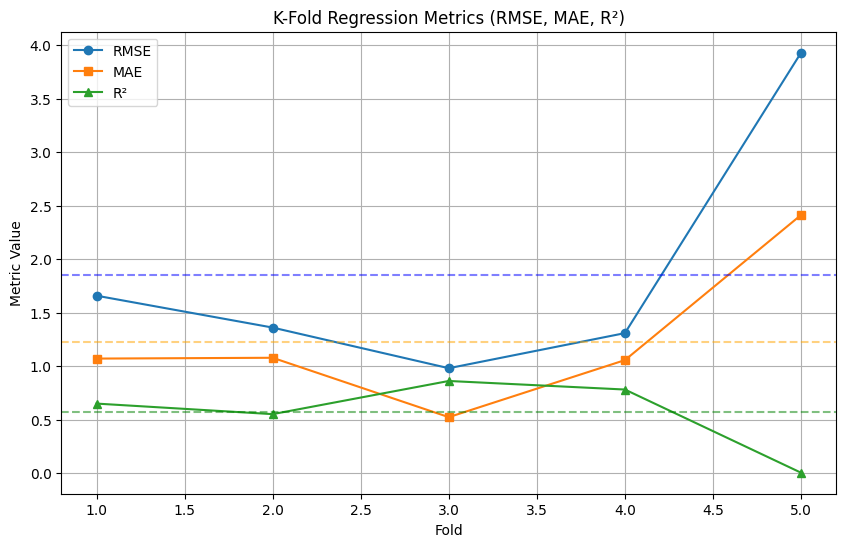

In [ ]:
loaded_results = run_ssl_pipeline_kfold_with_r2(
    labeled_df=df,
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740",
    fine_tune_epochs = 25
)

#### SSL MultiTask Only

Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_multi
Loaded pretrained backbone and projection head from saved run.

--- K-Fold 1/5 ---


[I 2025-10-07 12:50:45,527] A new study created in memory with name: no-name-fd7e0c4d-7b8f-4190-bc87-9db59ca736b7
[I 2025-10-07 12:50:46,575] Trial 0 finished with value: 1.4701033353805542 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.4701033353805542.
[I 2025-10-07 12:50:46,960] Trial 1 finished with value: 1.4971279621124267 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.4701033353805542.
[I 2025-10-07 12:50:47,365] Trial 2 finished with value: 1.4460347414016723 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.4460347414016723.
[I 2025-10-07 12:

Best params fold 1: {'n_estimators': 135, 'max_depth': 8, 'learning_rate': 0.11678558089474768, 'subsample': 0.8936108460389663, 'colsample_bytree': 0.6715143647973427}
[Fold 1] RMSE: 3.8148, MAE: 2.7552, R²: -0.8408

--- K-Fold 2/5 ---


[I 2025-10-07 12:51:13,130] A new study created in memory with name: no-name-1563d4e3-8196-47d6-9030-0801be7d1ecf
[I 2025-10-07 12:51:14,200] Trial 0 finished with value: 2.1902722120285034 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.1902722120285034.
[I 2025-10-07 12:51:14,559] Trial 1 finished with value: 2.195744752883911 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.1902722120285034.
[I 2025-10-07 12:51:14,977] Trial 2 finished with value: 2.1142508029937743 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.1142508029937743.
[I 2025-10-07 12:5

Best params fold 2: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.29596284206078843, 'subsample': 0.9234980616943328, 'colsample_bytree': 0.6608574886555885}
[Fold 2] RMSE: 2.0388, MAE: 1.3231, R²: -0.0021

--- K-Fold 3/5 ---


[I 2025-10-07 12:51:40,961] A new study created in memory with name: no-name-9c3f95f0-dea4-4d0f-a31a-087be2ccfc60
[I 2025-10-07 12:51:42,075] Trial 0 finished with value: 1.9337733507156372 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.9337733507156372.
[I 2025-10-07 12:51:42,436] Trial 1 finished with value: 1.929962146282196 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.929962146282196.
[I 2025-10-07 12:51:42,851] Trial 2 finished with value: 2.114901876449585 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 1.929962146282196.
[I 2025-10-07 12:51:4

Best params fold 3: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}
[Fold 3] RMSE: 1.2160, MAE: 0.8217, R²: 0.7897

--- K-Fold 4/5 ---


[I 2025-10-07 12:52:06,050] A new study created in memory with name: no-name-3589d897-702a-431a-8fc7-4f35ea4b608e
[I 2025-10-07 12:52:07,136] Trial 0 finished with value: 1.865040910243988 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.865040910243988.
[I 2025-10-07 12:52:07,485] Trial 1 finished with value: 1.8159724950790406 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.8159724950790406.
[I 2025-10-07 12:52:07,903] Trial 2 finished with value: 1.8949223160743713 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 1.8159724950790406.
[I 2025-10-07 12:52

Best params fold 4: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.030241001410559513, 'subsample': 0.8751050092487717, 'colsample_bytree': 0.5065883662316701}
[Fold 4] RMSE: 3.1157, MAE: 2.6016, R²: -0.2285

--- K-Fold 5/5 ---


[I 2025-10-07 12:52:37,187] A new study created in memory with name: no-name-d5ae60c3-c002-462f-b6d1-edc2083d5fb4
[I 2025-10-07 12:52:38,794] Trial 0 finished with value: 1.9399768590927124 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.9399768590927124.
[I 2025-10-07 12:52:39,908] Trial 1 finished with value: 2.027738428115845 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.9399768590927124.
[I 2025-10-07 12:52:41,221] Trial 2 finished with value: 1.8075245380401612 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.8075245380401612.
[I 2025-10-07 12:5

Best params fold 5: {'n_estimators': 146, 'max_depth': 10, 'learning_rate': 0.27047297227177763, 'subsample': 0.5148027085118481, 'colsample_bytree': 0.8259332753890892}
[Fold 5] RMSE: 3.2419, MAE: 2.3254, R²: 0.3234

=== Fold Metrics Summary ===
      fold      RMSE       MAE        R2
0      1.0  3.814776  2.755160 -0.840760
1      2.0  2.038832  1.323095 -0.002117
2      3.0  1.216004  0.821721  0.789738
3      4.0  3.115711  2.601593 -0.228472
4      5.0  3.241856  2.325407  0.323378
Mean   3.0  2.685436  1.965395  0.008354


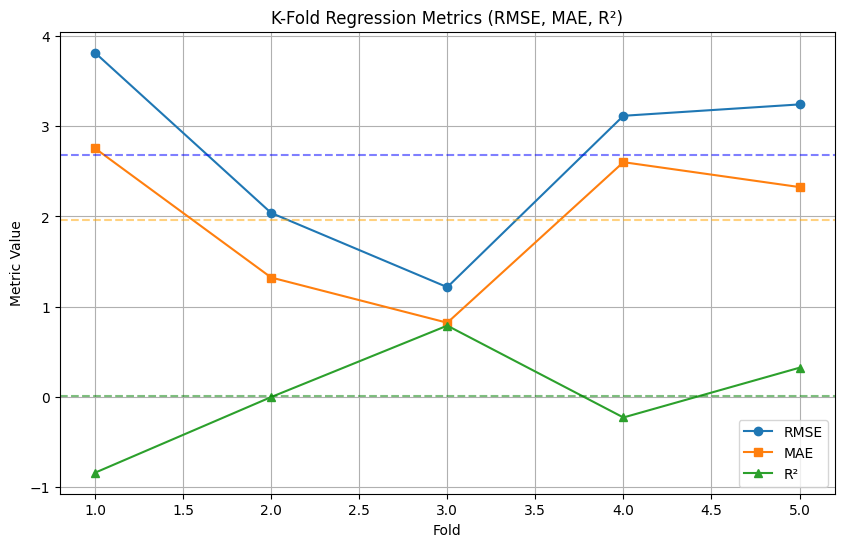

In [ ]:
loaded_results = run_ssl_pipeline_kfold_with_r2(
    labeled_df=df,
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_multi",
    fine_tune_epochs = 0
)

#### SSL Multi Task + Finetuning == Horrible R2 <0

In [ ]:
loaded_results = run_ssl_pipeline_kfold_with_r2(
    labeled_df=df,
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_multi",
    fine_tune_epochs = 25
)

Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_multi
Loaded pretrained backbone and projection head from saved run.

--- K-Fold 1/5 ---
Fold 1 Epoch 1 Loss: 0.9931
Fold 1 Epoch 2 Loss: 0.9701
Fold 1 Epoch 3 Loss: 1.0150
Fold 1 Epoch 4 Loss: 1.0004
Fold 1 Epoch 5 Loss: 0.9691
Fold 1 Epoch 6 Loss: 1.0030
Fold 1 Epoch 7 Loss: 0.9383
Fold 1 Epoch 8 Loss: 0.9814
Fold 1 Epoch 9 Loss: 0.9685


Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740
Loaded pretrained backbone and projection head from saved run.

--- K-Fold 1/5 ---
Fold 1 Epoch 1 Loss: 2.6601
Fold 1 Epoch 2 Loss: 2.0024
Fold 1 Epoch 3 Loss: 2.1261
Fold 1 Epoch 4 Loss: 2.4039
Fold 1 Epoch 5 Loss: 2.5450
Fold 1 Epoch 6 Loss: 2.2874
Fold 1 Epoch 7 Loss: 2.3637
Fold 1 Epoch 8 Loss: 2.5455
Fold 1 Epoch 9 Loss: 2.2838
Fold 1 Epoch 10 Loss: 2.2622


[I 2025-10-07 11:43:13,097] A new study created in memory with name: no-name-f56c0198-0776-42bb-8955-b7883d72a4b6
[I 2025-10-07 11:43:14,173] Trial 0 finished with value: 1.407820987701416 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.407820987701416.
[I 2025-10-07 11:43:14,521] Trial 1 finished with value: 1.6261560440063476 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.407820987701416.
[I 2025-10-07 11:43:14,911] Trial 2 finished with value: 1.3167827725410461 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.3167827725410461.
[I 2025-10-07 11:43:

Best params fold 1: {'n_estimators': 278, 'max_depth': 7, 'learning_rate': 0.02610016466426293, 'subsample': 0.5324266600311697, 'colsample_bytree': 0.8218563683119117}
[Fold 1] RMSE: 1.9346, MAE: 1.4166, R²: 0.5266

--- K-Fold 2/5 ---
Fold 2 Epoch 1 Loss: 1.8051
Fold 2 Epoch 2 Loss: 1.9291
Fold 2 Epoch 3 Loss: 1.7906
Fold 2 Epoch 4 Loss: 1.4357
Fold 2 Epoch 5 Loss: 1.5202
Fold 2 Epoch 6 Loss: 1.5954
Fold 2 Epoch 7 Loss: 1.6088
Fold 2 Epoch 8 Loss: 1.7306
Fold 2 Epoch 9 Loss: 1.6036
Fold 2 Epoch 10 Loss: 1.6402


[I 2025-10-07 11:44:19,306] A new study created in memory with name: no-name-0a9092a0-61a6-4e79-82ee-109aa2e35a80
[I 2025-10-07 11:44:20,345] Trial 0 finished with value: 1.9406578063964843 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.9406578063964843.
[I 2025-10-07 11:44:20,684] Trial 1 finished with value: 1.9136887073516846 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.9136887073516846.
[I 2025-10-07 11:44:21,087] Trial 2 finished with value: 1.622477149963379 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.622477149963379.
[I 2025-10-07 11:44

Best params fold 2: {'n_estimators': 51, 'max_depth': 6, 'learning_rate': 0.08749102207565247, 'subsample': 0.5638406774527164, 'colsample_bytree': 0.9219900508555974}
[Fold 2] RMSE: 2.4668, MAE: 2.1984, R²: -0.4670

--- K-Fold 3/5 ---
Fold 3 Epoch 1 Loss: 1.5858
Fold 3 Epoch 2 Loss: 1.4344
Fold 3 Epoch 3 Loss: 1.7467
Fold 3 Epoch 4 Loss: 1.6404
Fold 3 Epoch 5 Loss: 1.4740
Fold 3 Epoch 6 Loss: 1.6029
Fold 3 Epoch 7 Loss: 1.7919
Fold 3 Epoch 8 Loss: 1.6236
Fold 3 Epoch 9 Loss: 1.6161
Fold 3 Epoch 10 Loss: 1.5573


[I 2025-10-07 11:45:11,679] A new study created in memory with name: no-name-f66c018e-7bfa-40a3-9438-099b6c28dfc1
[I 2025-10-07 11:45:12,733] Trial 0 finished with value: 1.2837544202804565 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.2837544202804565.
[I 2025-10-07 11:45:13,087] Trial 1 finished with value: 1.596200132369995 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.2837544202804565.
[I 2025-10-07 11:45:13,488] Trial 2 finished with value: 1.3586804866790771 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 1.2837544202804565.
[I 2025-10-07 11:4

Best params fold 3: {'n_estimators': 144, 'max_depth': 8, 'learning_rate': 0.09958344834282504, 'subsample': 0.8676850494543448, 'colsample_bytree': 0.5083162241661173}
[Fold 3] RMSE: 0.4279, MAE: 0.3052, R²: 0.9740

--- K-Fold 4/5 ---
Fold 4 Epoch 1 Loss: 1.4433
Fold 4 Epoch 2 Loss: 1.3271
Fold 4 Epoch 3 Loss: 1.4881
Fold 4 Epoch 4 Loss: 1.6251
Fold 4 Epoch 5 Loss: 1.6870
Fold 4 Epoch 6 Loss: 1.4385
Fold 4 Epoch 7 Loss: 1.4586
Fold 4 Epoch 8 Loss: 1.6718
Fold 4 Epoch 9 Loss: 1.5940
Fold 4 Epoch 10 Loss: 1.3917


[I 2025-10-07 11:46:07,199] A new study created in memory with name: no-name-bdf4e1a2-bb17-41a6-bb43-fde1a9da1b60
[I 2025-10-07 11:46:08,217] Trial 0 finished with value: 1.6683461666107178 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.6683461666107178.
[I 2025-10-07 11:46:08,563] Trial 1 finished with value: 1.574157476425171 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.574157476425171.
[I 2025-10-07 11:46:08,939] Trial 2 finished with value: 1.4564182877540588 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.4564182877540588.
[I 2025-10-07 11:46

Best params fold 4: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}
[Fold 4] RMSE: 1.8214, MAE: 1.6051, R²: 0.5802

--- K-Fold 5/5 ---
Fold 5 Epoch 1 Loss: 1.6262
Fold 5 Epoch 2 Loss: 1.5129
Fold 5 Epoch 3 Loss: 1.4395
Fold 5 Epoch 4 Loss: 1.5151
Fold 5 Epoch 5 Loss: 1.5274
Fold 5 Epoch 6 Loss: 1.4094
Fold 5 Epoch 7 Loss: 1.3731
Fold 5 Epoch 8 Loss: 1.3843
Fold 5 Epoch 9 Loss: 1.4026
Fold 5 Epoch 10 Loss: 1.4330


[I 2025-10-07 11:46:58,445] A new study created in memory with name: no-name-f70c983a-67e9-4a32-8d86-9cc1c75a0f47
[I 2025-10-07 11:47:00,047] Trial 0 finished with value: 1.2215837955474853 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.2215837955474853.
[I 2025-10-07 11:47:00,642] Trial 1 finished with value: 1.186989462375641 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.186989462375641.
[I 2025-10-07 11:47:01,281] Trial 2 finished with value: 1.0646203756332397 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.0646203756332397.
[I 2025-10-07 11:47

Best params fold 5: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}
[Fold 5] RMSE: 2.8136, MAE: 1.8847, R²: 0.4903

=== Fold Metrics Summary ===
      fold      RMSE       MAE        R2
0      1.0  1.934621  1.416637  0.526576
1      2.0  2.466783  2.198400 -0.466957
2      3.0  0.427890  0.305167  0.973965
3      4.0  1.821374  1.605066  0.580194
4      5.0  2.813626  1.884661  0.490327
Mean   3.0  1.892859  1.481986  0.420821


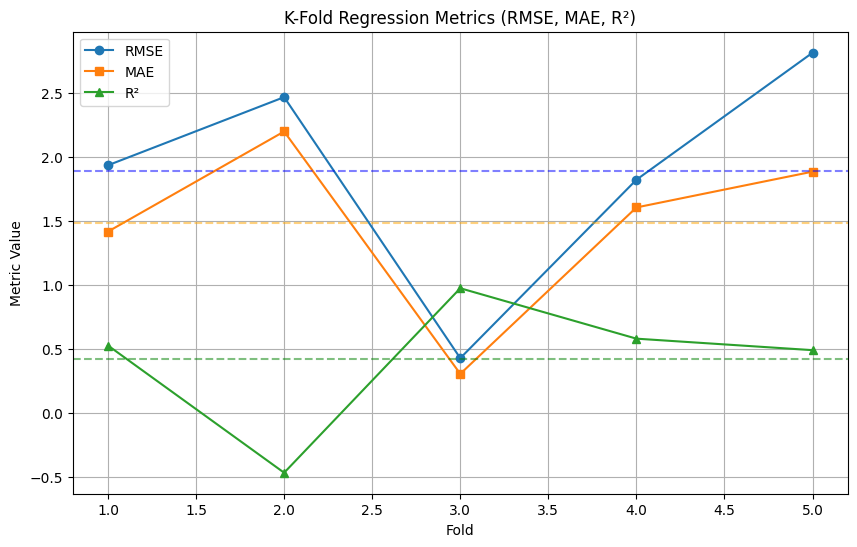

KeyError: 'rmse'

In [ ]:
loaded_results = run_ssl_pipeline_kfold_with_r2(
    labeled_df=df,
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740"
)



### Extract Features

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import torch
from torch.utils.data import DataLoader
from PIL import Image
import cv2
import optuna

# -----------------------------
# Utility Functions
# -----------------------------
def extract_rgb_hsv_features(image_path, resize_shape=(224,224)):
    """
    Extract mean Red channel and mean Saturation from a lip image.
    Returns: np.array([mean_R, mean_S])
    """
    img = Image.open(image_path).convert("RGB")
    img = img.resize(resize_shape)
    img_np = np.array(img)

    mean_r = img_np[:,:,0].mean()
    img_hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    mean_s = img_hsv[:,:,1].mean()

    return np.array([mean_r, mean_s], dtype=np.float32)

def extract_features(df, backbone=None, transform=None, device="cuda", mode="ssl+rgb"):
    """
    Extract features based on mode:
      - ssl: SSL embeddings only
      - rgb: RGB/HSV only
      - ssl+rgb: concatenate SSL embeddings and RGB/HSV
    """
    X_list, y_list = [], []
    if backbone is not None:
        backbone.eval()

    with torch.no_grad():
        for idx, row in df.iterrows():
            img_path = row['Filename']
            feats = []

            # SSL embeddings
            if mode in ["ssl", "ssl+rgb"]:
                img_tensor = transform(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
                ssl_feat = backbone(img_tensor).view(1, -1).cpu().numpy().flatten()
                feats.append(ssl_feat)

            # RGB/HSV features
            if mode in ["rgb", "ssl+rgb"]:
                rgb_hsv_feat = extract_rgb_hsv_features(img_path)
                feats.append(rgb_hsv_feat)

            X_list.append(np.concatenate(feats))
            y_list.append(row['Hb'])

    X = np.vstack(X_list)
    y = np.array(y_list, dtype=np.float32)
    return X, y

# -----------------------------
# Main K-Fold Regression Pipeline
# -----------------------------
def run_ssl_rgb_pipeline_kfold(labeled_df,
                               unlabelled_dir=None,
                               ssl_transform=None,
                               val_transform=None,
                               ssl_epochs=20,
                               ssl_batch=8,
                               fine_tune_backbone=True,
                               fine_tune_epochs=10,
                               mode="ssl+rgb",
                               optuna_trials=20,
                               n_splits=5,
                               random_seed=42,
                               run_base_dir="models",
                               load_run_dir=None,
                               device="cuda"):

    import os
    os.makedirs(run_base_dir, exist_ok=True)
    run_dir = load_run_dir if load_run_dir else os.path.join(run_base_dir, "run_"+str(np.random.randint(1e5)))
    os.makedirs(run_dir, exist_ok=True)
    print(f"Run directory: {run_dir}")

    # -----------------------
    # Load or pretrain SSL backbone
    # -----------------------
    backbone = get_ssl_backbone(pretrained=False)
    proj_head = ProjectionHead().to(device)

    if load_run_dir and os.path.exists(os.path.join(run_dir, "ssl_backbone_state_dict.pth")):
        backbone.load_state_dict(torch.load(os.path.join(run_dir, "ssl_backbone_state_dict.pth"), map_location=device))
        proj_head.load_state_dict(torch.load(os.path.join(run_dir, "ssl_projection_head_state_dict.pth"), map_location=device))
        backbone.to(device).eval()
        proj_head.to(device).eval()
        print("Loaded pretrained backbone and projection head from saved run.")
    else:
        print("=== SSL Pretraining ===")
        if unlabelled_dir:
            backbone, proj_head, ssl_losses = pretrain_ssl(unlabelled_dir, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=True)
        else:
            backbone, proj_head, ssl_losses = pretrain_ssl(labeled_df, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=False)

    # -----------------------
    # K-Fold CV
    # -----------------------
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import xgboost as xgb
    import optuna

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    fold_metrics = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(labeled_df)):
        print(f"\n--- K-Fold {fold_idx+1}/{n_splits} ---")
        train_df, test_df = labeled_df.iloc[train_idx], labeled_df.iloc[test_idx]

        # Fine-tune backbone if required
        if fine_tune_backbone and "ssl" in mode:
            dataset = HbImageDataset(train_df, transform=ssl_transform, n_views=2)
            loader = DataLoader(dataset, batch_size=ssl_batch, shuffle=True, num_workers=2, pin_memory=True)
            backbone.train()
            proj_head.train()
            optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=1e-4)
            for epoch in range(fine_tune_epochs):
                total_loss = 0.0
                for views, _ in loader:
                    v1, v2 = views[:,0].to(device), views[:,1].to(device)
                    feats1, feats2 = backbone(v1).view(v1.size(0), -1), backbone(v2).view(v2.size(0), -1)
                    z1, z2 = proj_head(feats1), proj_head(feats2)
                    loss = nt_xent_loss(z1, z2)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Fold {fold_idx+1} Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

        # -----------------------
        # Feature extraction
        # -----------------------
        X_train, y_train = extract_features(train_df, backbone if "ssl" in mode else None,
                                            transform=val_transform, device=device, mode=mode)
        X_test, y_test = extract_features(test_df, backbone if "ssl" in mode else None,
                                          transform=val_transform, device=device, mode=mode)

        # -----------------------
        # Optuna Hyperparameter Tuning
        # -----------------------
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators",50,300),
                "max_depth": trial.suggest_int("max_depth",2,10),
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.3,log=True),
                "subsample": trial.suggest_float("subsample",0.5,1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree",0.5,1.0),
                "random_state": random_seed,
                "verbosity": 0,
                "n_jobs": 1,
                "tree_method": "hist"
            }
            kf_inner = KFold(n_splits=min(5, len(train_df)), shuffle=True, random_state=random_seed)
            maes = []
            for tr_idx, val_idx in kf_inner.split(X_train):
                model = xgb.XGBRegressor(**params)
                model.fit(X_train[tr_idx], y_train[tr_idx])
                y_pred = model.predict(X_train[val_idx])
                maes.append(mean_absolute_error(y_train[val_idx], y_pred))
            return np.mean(maes)

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_seed))
        study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False)
        best_params = study.best_params
        print(f"Best params fold {fold_idx+1}: {best_params}")

        # -----------------------
        # Train final model
        # -----------------------
        final_model = xgb.XGBRegressor(**best_params, random_state=random_seed, n_jobs=-1, tree_method="hist")
        final_model.fit(X_train, y_train)
        y_pred = final_model.predict(X_test)

        # Save XGBoost model
        model_path = os.path.join(run_dir, f"xgb_fold{fold_idx+1}.json")
        final_model.save_model(model_path)
        print(f"Saved XGBoost model for fold {fold_idx+1} at {model_path}")

        # -----------------------
        # Metrics
        # -----------------------
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"[Fold {fold_idx+1}] RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        fold_metrics.append({"fold": fold_idx+1, "RMSE": rmse, "MAE": mae, "R2": r2})

    # -----------------------
    # Summary metrics
    # -----------------------
    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.loc["Mean"] = metrics_df.mean()
    print("\n=== Fold Metrics Summary ===")
    print(metrics_df)

    # Save backbone + projection head
    if "ssl" in mode:
        torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
        torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))

    return metrics_df, run_dir



#### Run

In [ ]:
import torchvision.transforms as T
import pandas as pd
from pathlib import Path

ssl_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ----------------------------
# Run the pipeline
# ----------------------------
# # Example 1: SSL embeddings only
# metrics_ssl, run_dir_ssl = run_ssl_rgb_pipeline_kfold(
#     labeled_df=df,
#     unlabelled_dir=None,       # or path to unlabelled images if available
#     ssl_transform=ssl_transform,
#     val_transform=val_transform,
#     fine_tune_backbone=True,
#     fine_tune_epochs=5,
#     mode="ssl",
#     load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740"
# )

# # Example 2: RGB/HSV features only
# metrics_rgb, run_dir_rgb = run_ssl_rgb_pipeline_kfold(
#     labeled_df=df,
#     ssl_transform=ssl_transform,   # still required for function signature
#     val_transform=val_transform,
#     mode="rgb",
#     n_splits=5,
#     optuna_trials=10,
#     random_seed=42,
#     run_base_dir="models"
# )

# Example 3: Combined SSL + RGB/HSV
metrics_ssl_rgb, run_dir_ssl_rgb = run_ssl_rgb_pipeline_kfold(
    labeled_df=df,
    ssl_transform=ssl_transform,
    val_transform=val_transform,
    mode="ssl+rgb",
    n_splits=5,
    optuna_trials=10,
    random_seed=42,
    run_base_dir="models",
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740"
)

Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740
Loaded pretrained backbone and projection head from saved run.

--- K-Fold 1/5 ---
Fold 1 Epoch 1 Loss: 1.1195
Fold 1 Epoch 2 Loss: 1.0502
Fold 1 Epoch 3 Loss: 1.0614
Fold 1 Epoch 4 Loss: 1.0643
Fold 1 Epoch 5 Loss: 0.9797
Fold 1 Epoch 6 Loss: 1.0569
Fold 1 Epoch 7 Loss: 0.9918
Fold 1 Epoch 8 Loss: 1.0422
Fold 1 Epoch 9 Loss: 0.9975
Fold 1 Epoch 10 Loss: 0.9845


[I 2025-10-07 13:26:14,190] A new study created in memory with name: no-name-8c6e8c9c-db27-4b18-93b9-0b6564f3620e
[I 2025-10-07 13:26:15,788] Trial 0 finished with value: 1.9691081762313842 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.9691081762313842.
[I 2025-10-07 13:26:16,146] Trial 1 finished with value: 1.9143864870071412 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.9143864870071412.
[I 2025-10-07 13:26:16,520] Trial 2 finished with value: 2.014492988586426 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 1.9143864870071412.
[I 2025-10-07 13:2

Best params fold 1: {'n_estimators': 202, 'max_depth': 3, 'learning_rate': 0.012476394272569451, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797}
Saved XGBoost model for fold 1 at /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740/xgb_fold1.json
[Fold 1] RMSE: 3.6573, MAE: 2.4402, R²: -0.6919

--- K-Fold 2/5 ---
Fold 2 Epoch 1 Loss: 0.7829
Fold 2 Epoch 2 Loss: 0.7560
Fold 2 Epoch 3 Loss: 0.7604
Fold 2 Epoch 4 Loss: 0.7665
Fold 2 Epoch 5 Loss: 0.7729
Fold 2 Epoch 6 Loss: 0.7358
Fold 2 Epoch 7 Loss: 0.7524
Fold 2 Epoch 8 Loss: 0.7243
Fold 2 Epoch 9 Loss: 0.7186
Fold 2 Epoch 10 Loss: 0.7109


[I 2025-10-07 13:26:52,163] A new study created in memory with name: no-name-61dde273-e5e0-49dd-a70a-2984597d2065
[I 2025-10-07 13:26:53,224] Trial 0 finished with value: 2.3083893775939943 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.3083893775939943.
[I 2025-10-07 13:26:53,568] Trial 1 finished with value: 1.705501127243042 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.705501127243042.
[I 2025-10-07 13:26:54,062] Trial 2 finished with value: 2.3222278594970702 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 1.705501127243042.
[I 2025-10-07 13:26:

Best params fold 2: {'n_estimators': 202, 'max_depth': 3, 'learning_rate': 0.012476394272569451, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797}
Saved XGBoost model for fold 2 at /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740/xgb_fold2.json
[Fold 2] RMSE: 3.5470, MAE: 2.1194, R²: -2.0331

--- K-Fold 3/5 ---
Fold 3 Epoch 1 Loss: 0.7319
Fold 3 Epoch 2 Loss: 0.7289
Fold 3 Epoch 3 Loss: 0.7313
Fold 3 Epoch 4 Loss: 0.7151
Fold 3 Epoch 5 Loss: 0.7283
Fold 3 Epoch 6 Loss: 0.7008
Fold 3 Epoch 7 Loss: 0.7180
Fold 3 Epoch 8 Loss: 0.7049
Fold 3 Epoch 9 Loss: 0.6958
Fold 3 Epoch 10 Loss: 0.7186


[I 2025-10-07 13:27:33,133] A new study created in memory with name: no-name-b89ce22e-c7c5-4448-9dd5-9ffaeedab006
[I 2025-10-07 13:27:34,226] Trial 0 finished with value: 2.5161930561065673 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.5161930561065673.
[I 2025-10-07 13:27:34,600] Trial 1 finished with value: 2.527419829368591 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.5161930561065673.
[I 2025-10-07 13:27:34,999] Trial 2 finished with value: 2.2174423694610597 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.2174423694610597.
[I 2025-10-07 13:2

Best params fold 3: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}
Saved XGBoost model for fold 3 at /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740/xgb_fold3.json
[Fold 3] RMSE: 2.7373, MAE: 1.9622, R²: -0.0654

--- K-Fold 4/5 ---
Fold 4 Epoch 1 Loss: 0.7211
Fold 4 Epoch 2 Loss: 0.7408
Fold 4 Epoch 3 Loss: 0.7148
Fold 4 Epoch 4 Loss: 0.7210
Fold 4 Epoch 5 Loss: 0.7005
Fold 4 Epoch 6 Loss: 0.7001
Fold 4 Epoch 7 Loss: 0.6965
Fold 4 Epoch 8 Loss: 0.7052
Fold 4 Epoch 9 Loss: 0.7003
Fold 4 Epoch 10 Loss: 0.7077


[I 2025-10-07 13:28:16,475] A new study created in memory with name: no-name-c36ff56d-8d95-4e54-8071-aa50625c197f
[I 2025-10-07 13:28:17,654] Trial 0 finished with value: 2.404097783565521 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.404097783565521.
[I 2025-10-07 13:28:18,247] Trial 1 finished with value: 2.3308253645896913 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.3308253645896913.
[I 2025-10-07 13:28:18,892] Trial 2 finished with value: 2.221395754814148 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.221395754814148.
[I 2025-10-07 13:28:1

Best params fold 4: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}
Saved XGBoost model for fold 4 at /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740/xgb_fold4.json
[Fold 4] RMSE: 3.4050, MAE: 3.0960, R²: -0.4672

--- K-Fold 5/5 ---
Fold 5 Epoch 1 Loss: 0.6976
Fold 5 Epoch 2 Loss: 0.6940
Fold 5 Epoch 3 Loss: 0.7175
Fold 5 Epoch 4 Loss: 0.7020
Fold 5 Epoch 5 Loss: 0.7065
Fold 5 Epoch 6 Loss: 0.7029
Fold 5 Epoch 7 Loss: 0.7009
Fold 5 Epoch 8 Loss: 0.6990
Fold 5 Epoch 9 Loss: 0.7036
Fold 5 Epoch 10 Loss: 0.7009


[I 2025-10-07 13:28:54,276] A new study created in memory with name: no-name-acc9ddd0-e0d3-4524-9b7c-ea833dc7c5b9
[I 2025-10-07 13:28:55,416] Trial 0 finished with value: 2.0219948291778564 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.0219948291778564.
[I 2025-10-07 13:28:55,779] Trial 1 finished with value: 2.1999799489974974 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.0219948291778564.
[I 2025-10-07 13:28:56,209] Trial 2 finished with value: 2.0173492670059203 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.0173492670059203.
[I 2025-10-07 13:

Best params fold 5: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.05864129169696527, 'subsample': 0.7733551396716398, 'colsample_bytree': 0.5924272277627636}
Saved XGBoost model for fold 5 at /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740/xgb_fold5.json
[Fold 5] RMSE: 3.4698, MAE: 2.0711, R²: 0.2249

=== Fold Metrics Summary ===
      fold      RMSE       MAE        R2
0      1.0  3.657303  2.440218 -0.691924
1      2.0  3.547014  2.119395 -2.033061
2      3.0  2.737258  1.962170 -0.065422
3      4.0  3.405017  3.096026 -0.467201
4      5.0  3.469792  2.071146  0.224886
Mean   3.0  3.363277  2.337791 -0.606544


#### Extract Full Features

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import optuna
# For scikit-image >=0.20
from skimage.feature.texture import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern

from scipy.stats import skew, kurtosis
import mediapipe as mp

# ---------------------------
# ROI detection (lips/conjunctiva)
# ---------------------------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def detect_lips_roi(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        xs = [landmarks[i].x for i in range(61, 89)]
        ys = [landmarks[i].y for i in range(61, 89)]
        h, w, _ = img.shape
        x1, x2 = int(min(xs)*w), int(max(xs)*w)
        y1, y2 = int(min(ys)*h), int(max(ys)*h)
        roi = img[y1:y2, x1:x2]
        return roi
    else:
        return img  # fallback: use whole image

# ---------------------------
# Rich feature extractor
# ---------------------------
def extract_rich_features(img, resize_shape=(224,224), hist_bins=16, glcm_distances=[1], glcm_angles=[0]):
    img = cv2.resize(img, resize_shape)

    # Color spaces
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

    features = []

    # --- Color statistics & histograms ---
    for channel in [img_rgb, img_hsv, img_lab]:
        for i in range(3):
            c = channel[:,:,i].flatten()
            features.extend([c.mean(), c.std(), skew(c), kurtosis(c), c.min(), c.max()])
            hist = np.histogram(c, bins=hist_bins, range=(0,255))[0]
            hist = hist / hist.sum()
            features.extend(hist)

    # --- Color ratios ---
    R, G, B = img_rgb[:,:,0], img_rgb[:,:,1], img_rgb[:,:,2]
    features.extend([(R.mean()+1e-5)/(G.mean()+1e-5), (R.mean()+1e-5)/(B.mean()+1e-5), (G.mean()+1e-5)/(B.mean()+1e-5)])
    H, S, V = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
    features.extend([(H.mean()+1e-5)/(S.mean()+1e-5), (S.mean()+1e-5)/(V.mean()+1e-5)])

    # --- Texture: GLCM features ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_q = (gray/255*15).astype(np.uint8)
    glcm = greycomatrix(gray_q, distances=glcm_distances, angles=glcm_angles, symmetric=True, normed=True)
    for prop in ['contrast', 'correlation', 'energy', 'homogeneity']:
        features.append(greycoprops(glcm, prop).mean())

    # --- LBP histogram ---
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_hist = lbp_hist / lbp_hist.sum()
    features.extend(lbp_hist)

    # --- Edge density ---
    edges = cv2.Canny(gray, 100, 200)
    features.append(edges.mean())

    return np.array(features)

# ---------------------------
# Wrapper to process dataframe
# ---------------------------
def extract_rich_features_from_df(df, img_column="Filename"):
    all_features = []
    for path in df[img_column]:
        roi = detect_lips_roi(path)
        feats = extract_rich_features(roi)
        all_features.append(feats)
    return np.array(all_features)

# ---------------------------
# Main K-Fold SSL + XGBoost pipeline
# ---------------------------
def run_ssl_pipeline_kfold_with_rich_features(labeled_df,
                                              unlabelled_dir=None,
                                              ssl_epochs=20,
                                              ssl_batch=8,
                                              fine_tune_backbone=True,
                                              fine_tune_epochs=10,
                                              use_metadata=False,
                                              optuna_trials=20,
                                              run_base_dir="models",
                                              load_run_dir=None,
                                              n_splits=5):
    run_dir = load_run_dir if load_run_dir else make_run_dir(run_base_dir)
    os.makedirs(run_dir, exist_ok=True)
    print(f"Run directory: {run_dir}")

    # -------------------
    # Load or pretrain SSL backbone
    # -------------------
    backbone = get_ssl_backbone(pretrained=False)
    proj_head = ProjectionHead().to(device)

    if load_run_dir and os.path.exists(os.path.join(run_dir, "ssl_backbone_state_dict.pth")):
        backbone.load_state_dict(torch.load(os.path.join(run_dir, "ssl_backbone_state_dict.pth"), map_location=device))
        proj_head.load_state_dict(torch.load(os.path.join(run_dir, "ssl_projection_head_state_dict.pth"), map_location=device))
        backbone.to(device).eval()
        proj_head.to(device).eval()
        print("Loaded pretrained backbone and projection head from saved run.")
    else:
        print("=== SSL Pretraining ===")
        if unlabelled_dir:
            backbone, proj_head, ssl_losses = pretrain_ssl(unlabelled_dir, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=True)
        else:
            backbone, proj_head, ssl_losses = pretrain_ssl(labeled_df, ssl_transform,
                                                           epochs=ssl_epochs, batch_size=ssl_batch,
                                                           run_dir=run_dir, unlabelled=False)

    # -------------------
    # K-Fold CV
    # -------------------
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    fold_metrics = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(labeled_df)):
        print(f"\n--- K-Fold {fold_idx+1}/{n_splits} ---")
        train_df, test_df = labeled_df.iloc[train_idx], labeled_df.iloc[test_idx]

        # Fine-tune backbone if required
        if fine_tune_backbone:
            dataset = HbImageDataset(train_df, transform=ssl_transform, n_views=2)
            loader = DataLoader(dataset, batch_size=ssl_batch, shuffle=True, num_workers=2, pin_memory=True)
            backbone.train()
            proj_head.train()
            optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()), lr=1e-4)
            for epoch in range(fine_tune_epochs):
                total_loss = 0.0
                for views, _ in loader:
                    v1, v2 = views[:,0].to(device), views[:,1].to(device)
                    feats1, feats2 = backbone(v1).view(v1.size(0), -1), backbone(v2).view(v2.size(0), -1)
                    z1, z2 = proj_head(feats1), proj_head(feats2)
                    loss = nt_xent_loss(z1, z2)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Fold {fold_idx+1} Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

        # -------------------
        # Extract embeddings and rich features
        # -------------------
        X_train_ssl, y_train = extract_embeddings(train_df, backbone, val_transform)
        X_test_ssl, y_test = extract_embeddings(test_df, backbone, val_transform)

        X_train_rich = extract_rich_features_from_df(train_df)
        X_test_rich = extract_rich_features_from_df(test_df)

        X_train = np.hstack([X_train_ssl, X_train_rich])
        X_test = np.hstack([X_test_ssl, X_test_rich])

        # -------------------
        # Optuna hyperparameter tuning
        # -------------------
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators",50,300),
                "max_depth": trial.suggest_int("max_depth",2,10),
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.3,log=True),
                "subsample": trial.suggest_float("subsample",0.5,1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree",0.5,1.0),
                "random_state": RANDOM_SEED,
                "verbosity": 0,
                "n_jobs": 1,
                "tree_method": "hist"
            }
            kf_inner = KFold(n_splits=min(5, len(train_df)), shuffle=True, random_state=RANDOM_SEED)
            maes = []
            for tr_idx, val_idx in kf_inner.split(X_train):
                model = xgb.XGBRegressor(**params)
                model.fit(X_train[tr_idx], y_train[tr_idx])
                y_pred = model.predict(X_train[val_idx])
                maes.append(mean_absolute_error(y_train[val_idx], y_pred))
            return np.mean(maes)

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
        study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False)
        best_params = study.best_params
        print(f"Best params fold {fold_idx+1}: {best_params}")

        # Train final model
        final_model = xgb.XGBRegressor(**best_params, random_state=RANDOM_SEED, n_jobs=-1, tree_method="hist")
        final_model.fit(X_train, y_train)
        y_pred = final_model.predict(X_test)

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"[Fold {fold_idx+1}] RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

        fold_metrics.append({"fold": fold_idx+1, "RMSE": rmse, "MAE": mae, "R2": r2})

    # -------------------
    # Summary metrics
    # -------------------
    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.loc["Mean"] = metrics_df.mean()
    print("\n=== Fold Metrics Summary ===")
    print(metrics_df)

    # Save metrics and models
    metrics_df.to_csv(os.path.join(run_dir, "kfold_metrics.csv"), index=False)
    torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
    torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))

    # Visualization
    plt.figure(figsize=(10,6))
    plt.plot(metrics_df['fold'][:-1], metrics_df['RMSE'][:-1], marker='o', label='RMSE')
    plt.plot(metrics_df['fold'][:-1], metrics_df['MAE'][:-1], marker='s', label='MAE')
    plt.plot(metrics_df['fold'][:-1], metrics_df['R2'][:-1], marker='^', label='R²')
    plt.axhline(metrics_df.loc["Mean", 'RMSE'], color='blue', linestyle='--', alpha=0.5)
    plt.axhline(metrics_df.loc["Mean", 'MAE'], color='orange', linestyle='--', alpha=0.5)
    plt.axhline(metrics_df.loc["Mean", 'R2'], color='green', linestyle='--', alpha=0.5)
    plt.xlabel("Fold")
    plt.ylabel("Metric Value")
    plt.title("K-Fold Regression Metrics (RMSE, MAE, R²)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(run_dir, "kfold_metrics_plot.png"))
    plt.show()

    return {
        "backbone": backbone,
        "proj_head": proj_head,
        "metrics_df": metrics_df,
        "run_dir": run_dir
    }


ImportError: cannot import name 'greycomatrix' from 'skimage.feature.texture' (/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py)

#### Run

In [ ]:
results = run_ssl_pipeline_kfold_with_rich_features(
    labeled_df=labeled_df,
    unlabelled_dir="/content/drive/MyDrive/DSA_Comp/Lip Images",        # or path to unlabeled images for SSL pretraining
    ssl_epochs=20,
    ssl_batch=8,
    fine_tune_backbone=True,
    fine_tune_epochs=10,
    use_metadata=False,
    optuna_trials=20,
    run_base_dir="models",
    n_splits=5
)


NameError: name 'run_ssl_pipeline_kfold_with_rich_features' is not defined

### Multi Task Training

In [ ]:
import os
import random
from datetime import datetime

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pillow_heif
pillow_heif.register_heif_opener()

# ---------------------------
# Configuration / Reproducibility
# ---------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------
# Utilities
# ---------------------------
def make_run_dir(base="models", prefix="run"):
    ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_dir = os.path.join(base, f"{prefix}_{ts}")
    os.makedirs(run_dir, exist_ok=True)
    return run_dir

# ---------------------------
# Dataset Classes
# ---------------------------
class HbImageDataset(Dataset):
    """Labeled dataset for SSL (ignores Hb target during SSL)"""
    def __init__(self, df, transform=None, path_col="Filename", target_col="Hb", n_views=2):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.path_col = path_col
        self.target_col = target_col
        self.n_views = n_views

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.path_col]).convert("RGB")
        views = [self.transform(img) for _ in range(self.n_views)]
        return torch.stack(views), torch.tensor(-1), True  # True indicates labeled

class CombinedSSLImageDataset(Dataset):
    """Combines labeled and unlabeled datasets for SSL pretraining"""
    def __init__(self, labeled_df=None, unlabelled_dir=None, transform=None, n_views=2):
        self.labeled_dataset = HbImageDataset(labeled_df, transform=transform, n_views=n_views) if labeled_df is not None else None

        # Unlabeled images
        self.unlabelled_paths, self.unlabelled_labels = [], []
        if unlabelled_dir is not None:
            for class_idx, folder_name in enumerate(sorted(os.listdir(unlabelled_dir))):
                folder_path = os.path.join(unlabelled_dir, folder_name)
                if not os.path.isdir(folder_path):
                    continue
                for fname in os.listdir(folder_path):
                    if fname.lower().endswith((".jpg",".jpeg",".png",".heic",".heif")):
                        self.unlabelled_paths.append(os.path.join(folder_path, fname))
                        self.unlabelled_labels.append(class_idx)

        self.transform = transform
        self.n_views = n_views
        self.labelled_len = len(self.labeled_dataset) if self.labeled_dataset else 0
        self.unlabelled_len = len(self.unlabelled_paths)
        self.total_len = self.labelled_len + self.unlabelled_len

        print(f"[INFO] Total images for SSL: {self.total_len} (Labeled={self.labelled_len}, Unlabeled={self.unlabelled_len})")

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if idx < self.labelled_len:
            return self.labeled_dataset[idx]
        else:
            un_idx = idx - self.labelled_len
            img_path = self.unlabelled_paths[un_idx]
            label = self.unlabelled_labels[un_idx]
            img = Image.open(img_path).convert("RGB")
            views = torch.stack([self.transform(img) for _ in range(self.n_views)])
            return views, torch.tensor(label), False

# ---------------------------
# Transforms
# ---------------------------
ssl_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------------------------
# Backbone and Heads
# ---------------------------
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class ClassificationHead(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

def get_ssl_backbone(pretrained=True):
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    backbone = nn.Sequential(*list(resnet.children())[:-1])
    return backbone.to(device)

# ---------------------------
# NT-Xent Loss
# ---------------------------
def nt_xent_loss(z_i, z_j, temperature=0.5):
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)
    batch_size = z_i.size(0)
    reps = torch.cat([z_i, z_j], dim=0)
    sim_matrix = torch.matmul(reps, reps.T)/temperature
    mask = torch.eye(2*batch_size, device=z_i.device).bool()
    sim_matrix = sim_matrix.masked_fill(mask, -1e9)
    labels = torch.arange(batch_size, device=z_i.device)
    labels = torch.cat([labels+batch_size, labels], dim=0)
    return nn.CrossEntropyLoss()(sim_matrix, labels)

# ---------------------------
# SSL Pretraining Function
# ---------------------------
def pretrain_ssl_with_aux(labeled_df=None, unlabelled_dir=None, transform=ssl_transform,
                          epochs=20, batch_size=8, lr=1e-3, run_dir=None):

    dataset = CombinedSSLImageDataset(labeled_df, unlabelled_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    backbone = get_ssl_backbone(pretrained=True)
    proj_head = ProjectionHead().to(device)
    class_head = ClassificationHead().to(device)

    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(proj_head.parameters()) + list(class_head.parameters()), lr=lr)

    backbone.train(); proj_head.train(); class_head.train()
    ssl_losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        for views, aux_labels, is_labeled in loader:
            v1, v2 = views[:,0].to(device), views[:,1].to(device)
            feats1, feats2 = backbone(v1).view(v1.size(0),-1), backbone(v2).view(v2.size(0),-1)
            z1, z2 = proj_head(feats1), proj_head(feats2)
            loss_ntxent = nt_xent_loss(z1, z2)

            mask_unlabeled = (~is_labeled).bool()
            if mask_unlabeled.any():
                feats_unlabeled = feats1[mask_unlabeled.to(device)]
                labels_unlabeled = aux_labels[mask_unlabeled].to(device)
                logits = class_head(feats_unlabeled)
                loss_aux = nn.CrossEntropyLoss()(logits, labels_unlabeled)
            else:
                loss_aux = 0.0

            loss = loss_ntxent + 0.5 * loss_aux
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(loader)
        ssl_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - SSL Loss: {avg_loss:.4f}")

    # Save models & losses
    if run_dir:
        os.makedirs(run_dir, exist_ok=True)
        torch.save(backbone.state_dict(), os.path.join(run_dir,"ssl_backbone.pth"))
        torch.save(proj_head.state_dict(), os.path.join(run_dir,"ssl_proj_head.pth"))
        torch.save(class_head.state_dict(), os.path.join(run_dir,"ssl_class_head.pth"))
        pd.DataFrame({"ssl_loss": ssl_losses}).to_csv(os.path.join(run_dir,"ssl_loss_history.csv"), index=False)

    return backbone, proj_head, class_head, ssl_losses

# ---------------------------
# Embedding Visualization
# ---------------------------
def visualize_embeddings(backbone, dataset, run_dir, n_samples=500):
    backbone.eval()
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    all_feats, all_labels = [], []

    with torch.no_grad():
        for views, aux_labels, is_labeled in loader:
            v = views[:,0].to(device)
            feats = backbone(v).view(v.size(0), -1)
            all_feats.append(feats.cpu().numpy())
            all_labels.append(aux_labels.numpy())

    feats = np.concatenate(all_feats, axis=0)[:n_samples]
    labels = np.concatenate(all_labels, axis=0)[:n_samples]

    # PCA
    pca = PCA(n_components=2)
    pca_emb = pca.fit_transform(feats)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
    tsne_emb = tsne.fit_transform(feats)

    # Plot function
    def plot_emb(emb, title, fname):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=labels, palette="Set1", legend="full")
        plt.title(title)
        plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
        plt.savefig(os.path.join(run_dir, fname))
        plt.close()

    plot_emb(pca_emb, "PCA Embeddings", "pca_embeddings.png")
    plot_emb(tsne_emb, "t-SNE Embeddings", "tsne_embeddings.png")
    print(f"[INFO] Embedding plots saved in {run_dir}")


Using device: cuda


#### Run Multi Task

In [ ]:
run_dir = make_run_dir("ssl_models", "ssl_hb")
backbone, proj_head, class_head, ssl_losses = pretrain_ssl_with_aux(
    labeled_df=df,
    unlabelled_dir="/content/drive/MyDrive/DSA_Comp/Lip Images",
    epochs=20,
    batch_size=8,
    run_dir=run_dir
)

# Visualize embeddings
dataset = CombinedSSLImageDataset(labeled_df=df, unlabelled_dir="/content/drive/MyDrive/DSA_Comp/Lip Images", transform=ssl_transform)
visualize_embeddings(backbone, dataset, run_dir)


[INFO] Total images for SSL: 741 (Labeled=31, Unlabeled=710)
Epoch 1/20 - SSL Loss: 1.9677
Epoch 2/20 - SSL Loss: 1.6197
Epoch 3/20 - SSL Loss: 1.6028
Epoch 4/20 - SSL Loss: 1.5310
Epoch 5/20 - SSL Loss: 1.5447
Epoch 6/20 - SSL Loss: 1.5219
Epoch 7/20 - SSL Loss: 1.5114
Epoch 8/20 - SSL Loss: 1.4577
Epoch 9/20 - SSL Loss: 1.4581
Epoch 10/20 - SSL Loss: 1.4110
Epoch 11/20 - SSL Loss: 1.4181
Epoch 12/20 - SSL Loss: 1.3995
Epoch 13/20 - SSL Loss: 1.4322
Epoch 14/20 - SSL Loss: 1.4089
Epoch 15/20 - SSL Loss: 1.3952
Epoch 16/20 - SSL Loss: 1.3899
Epoch 17/20 - SSL Loss: 1.3760
Epoch 18/20 - SSL Loss: 1.3998
Epoch 19/20 - SSL Loss: 1.4220
Epoch 20/20 - SSL Loss: 1.4262
[INFO] Total images for SSL: 741 (Labeled=31, Unlabeled=710)
[INFO] Embedding plots saved in ssl_models/ssl_hb_2025-10-07_12-26-33


### Semi Supervised Fine Tuning

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import xgboost as xgb
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

backbone_output_dim = 512



# -----------------------------
# Semi-Supervised Fine-Tune Head
# -----------------------------
class HbRegressionHead(nn.Module):
    """Regression head to predict Hb from backbone embeddings"""
    def __init__(self, backbone_output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(backbone_output_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

# -----------------------------
# Main K-Fold SSL + Semi-supervised Pipeline
# -----------------------------
def run_ssl_pipeline_kfold_semi(
    labeled_df,
    unlabelled_dir=None,
    ssl_epochs=20,
    ssl_batch=8,
    fine_tune_backbone=True,
    semi_supervised=True,
    use_metadata=False,
    optuna_trials=20,
    run_base_dir="models",
    load_run_dir=None,
    n_splits=5,
    fine_tune_epochs=2,
    ssl_transform=None,
    val_transform=None,
):
    """
    SSL + Semi-Supervised Fine-Tuning + K-Fold CV + XGBoost evaluation.

    Returns backbone, regression head, RMSE, MAE, run_dir.
    """
    run_dir = load_run_dir if load_run_dir else make_run_dir(run_base_dir)
    print(f"Run directory: {run_dir}")

    # -------------------
    # Step 1: SSL Pretraining or Load
    # -------------------
    backbone = get_ssl_backbone(pretrained=False)
    proj_head = ProjectionHead().to(device)

    if load_run_dir and os.path.exists(os.path.join(run_dir, "ssl_backbone_state_dict.pth")):
        backbone.load_state_dict(torch.load(os.path.join(run_dir, "ssl_backbone_state_dict.pth"), map_location=device))
        proj_head.load_state_dict(torch.load(os.path.join(run_dir, "ssl_projection_head_state_dict.pth"), map_location=device))
        backbone.to(device).eval()
        proj_head.to(device).eval()
        print("Loaded pretrained backbone and projection head from saved run.")
    else:
        print("=== SSL Pretraining ===")
        if unlabelled_dir:
            backbone, proj_head, ssl_losses = pretrain_ssl(
                unlabelled_dir, ssl_transform,
                epochs=ssl_epochs, batch_size=ssl_batch,
                run_dir=run_dir, unlabelled=True
            )
        else:
            backbone, proj_head, ssl_losses = pretrain_ssl(
                labeled_df, ssl_transform,
                epochs=ssl_epochs, batch_size=ssl_batch,
                run_dir=run_dir, unlabelled=False
            )

    # -------------------
    # K-Fold CV
    # -------------------
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    all_preds, all_targets = [], []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(labeled_df)):
        print(f"\n--- K-Fold {fold_idx+1}/{n_splits} ---")
        train_df, test_df = labeled_df.iloc[train_idx], labeled_df.iloc[test_idx]

        # -------------------
        # Semi-supervised fine-tuning on train fold
        # -------------------
        if fine_tune_backbone:
            dataset = HbImageDataset(train_df, transform=ssl_transform, n_views=2)
            loader = DataLoader(dataset, batch_size=ssl_batch, shuffle=True, num_workers=2, pin_memory=True)

            regression_head = HbRegressionHead(backbone_output_dim=backbone_output_dim).to(device)
            backbone.train()
            proj_head.train()
            regression_head.train()
            optimizer = torch.optim.Adam(
                list(backbone.parameters()) + list(proj_head.parameters()) + list(regression_head.parameters()),
                lr=1e-4
            )

            for epoch in range(fine_tune_epochs):
                total_loss = 0.0
                for views, hb in loader:
                    v1, v2 = views[:,0].to(device), views[:,1].to(device)
                    hb = hb.to(device)

                    # SSL contrastive embeddings
                    feats1, feats2 = backbone(v1), backbone(v2)
                    z1, z2 = proj_head(feats1), proj_head(feats2)
                    ssl_loss = nt_xent_loss(z1, z2)

                    # Hb regression loss
                    if semi_supervised:
                        hb_pred = regression_head(feats1)
                        hb_loss = nn.L1Loss()(hb_pred.squeeze(), hb)
                        loss = 0.5 * ssl_loss + 1.0 * hb_loss
                    else:
                        loss = ssl_loss

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                print(f"Fold {fold_idx+1} Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

        # -------------------
        # Extract embeddings
        # -------------------
        X_train, y_train = extract_embeddings(train_df, backbone, val_transform)
        X_test, y_test = extract_embeddings(test_df, backbone, val_transform)

        if use_metadata:
            X_train = combine_metadata(X_train, train_df)
            X_test = combine_metadata(X_test, test_df)

        # -------------------
        # Optuna hyperparameter tuning
        # -------------------
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators",50,300),
                "max_depth": trial.suggest_int("max_depth",2,10),
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.3,log=True),
                "subsample": trial.suggest_float("subsample",0.5,1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree",0.5,1.0),
                "random_state": RANDOM_SEED,
                "verbosity": 0,
                "n_jobs": 1,
                "tree_method": "hist"
            }
            kf_inner = KFold(n_splits=min(5, len(train_df)), shuffle=True, random_state=RANDOM_SEED)
            maes = []
            for tr_idx, val_idx in kf_inner.split(X_train):
                model = xgb.XGBRegressor(**params)
                model.fit(X_train[tr_idx], y_train[tr_idx])
                y_pred = model.predict(X_train[val_idx])
                maes.append(mean_absolute_error(y_train[val_idx], y_pred))
            return np.mean(maes)

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
        study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False)
        best_params = study.best_params
        print(f"Best params fold {fold_idx+1}: {best_params}")

        # -------------------
        # Train final XGBoost on train fold
        # -------------------
        final_model = xgb.XGBRegressor(**best_params, random_state=RANDOM_SEED, n_jobs=-1, tree_method="hist")
        final_model.fit(X_train, y_train)

        # -------------------
        # Predict on test fold
        # -------------------
        y_pred = final_model.predict(X_test)
        all_preds.extend(y_pred)
        all_targets.extend(y_test)

    # -------------------
    # Evaluation
    # -------------------
    all_preds, all_targets = np.array(all_preds), np.array(all_targets)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    print(f"\n=== K-Fold Evaluation ===\nRMSE: {rmse:.4f} | MAE: {mae:.4f}")

    # -------------------
    # Save artifacts
    # -------------------
    pd.DataFrame({"y_true": all_targets, "y_pred": all_preds}).to_csv(os.path.join(run_dir, "kfold_predictions.csv"), index=False)
    pd.DataFrame({"RMSE":[rmse], "MAE":[mae]}).to_csv(os.path.join(run_dir, "evaluation_metrics.csv"), index=False)
    torch.save(backbone.state_dict(), os.path.join(run_dir, "ssl_backbone_state_dict.pth"))
    torch.save(proj_head.state_dict(), os.path.join(run_dir, "ssl_projection_head_state_dict.pth"))
    torch.save(regression_head.state_dict(), os.path.join(run_dir, "regression_head_state_dict.pth"))

    return {
        "backbone": backbone,
        "proj_head": proj_head,
        "regression_head": regression_head,
        "rmse": rmse,
        "mae": mae,
        "run_dir": run_dir
    }


#### Run Training

In [ ]:
loaded_results = run_ssl_pipeline_kfold_semi(
    labeled_df=df,
    unlabelled_dir= "/content/drive/MyDrive/DSA_Comp/Lip Images",
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740",
    ssl_transform=ssl_transform,
)

print("Loaded RMSE:", loaded_results["rmse"])
print("Loaded MAE:", loaded_results["mae"])

Run directory: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_740
Loaded pretrained backbone and projection head from saved run.

--- K-Fold 1/5 ---


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4096x1 and 512x256)

# Baseline

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------------------------
# Dataset
# ---------------------------
class HbImageDataset(Dataset):
    """Simple labeled dataset for supervised learning."""
    def __init__(self, df, transform=None, path_col="Filename", target_col="Hb"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.path_col = path_col
        self.target_col = target_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.path_col]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        target = torch.tensor(row[self.target_col], dtype=torch.float32)
        return img, target

# ---------------------------
# Transforms
# ---------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------------------------
# Simple ResNet-based regressor
# ---------------------------
class HbRegressor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.head = nn.Linear(512, 1)

    def forward(self, x):
        x = self.backbone(x).view(x.size(0), -1)
        return self.head(x)

# ---------------------------
# Baseline K-Fold training
# ---------------------------
def run_baseline_kfold(labeled_df, n_splits=5, batch_size=8, epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_preds, all_targets = [], []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(labeled_df)):
        print(f"\n--- Fold {fold_idx+1}/{n_splits} ---")
        train_df, val_df = labeled_df.iloc[train_idx], labeled_df.iloc[val_idx]

        train_dataset = HbImageDataset(train_df, transform=train_transform)
        val_dataset = HbImageDataset(val_df, transform=val_transform)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        model = HbRegressor(pretrained=True).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()  # Baseline regression loss

        # Training loop
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for imgs, targets in train_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                preds = model(imgs).squeeze(1)
                loss = criterion(preds, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * imgs.size(0)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader.dataset):.4f}")

        # Validation
        model.eval()
        fold_preds, fold_targets = [], []
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                preds = model(imgs).squeeze(1)
                fold_preds.extend(preds.cpu().numpy())
                fold_targets.extend(targets.cpu().numpy())

        all_preds.extend(fold_preds)
        all_targets.extend(fold_targets)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    print(f"\n=== Baseline K-Fold Results ===\nRMSE: {rmse:.4f} | MAE: {mae:.4f}")

    return rmse, mae, all_preds, all_targets


### Run Baseline

In [ ]:
# Run the baseline
rmse, mae, preds, targets = run_baseline_kfold(
    labeled_df=df,
    n_splits=5,       # 5-fold CV
    batch_size=8,     # adjust if memory limited
    epochs=10,        # you can increase to 20-30 for better results
    lr=1e-4           # learning rate
)



--- Fold 1/5 ---
Epoch 1/10 - Loss: 112.3794
Epoch 2/10 - Loss: 102.3416
Epoch 3/10 - Loss: 97.3596
Epoch 4/10 - Loss: 91.0890
Epoch 5/10 - Loss: 86.7641
Epoch 6/10 - Loss: 83.0270
Epoch 7/10 - Loss: 78.6522
Epoch 8/10 - Loss: 73.1325
Epoch 9/10 - Loss: 69.0567
Epoch 10/10 - Loss: 65.7167

--- Fold 2/5 ---
Epoch 1/10 - Loss: 137.4318
Epoch 2/10 - Loss: 127.8954
Epoch 3/10 - Loss: 118.9164
Epoch 4/10 - Loss: 113.7754
Epoch 5/10 - Loss: 106.5062
Epoch 6/10 - Loss: 102.0925
Epoch 7/10 - Loss: 95.0964
Epoch 8/10 - Loss: 91.7221
Epoch 9/10 - Loss: 86.0973
Epoch 10/10 - Loss: 80.2952

--- Fold 3/5 ---
Epoch 1/10 - Loss: 148.7835
Epoch 2/10 - Loss: 136.5297
Epoch 3/10 - Loss: 128.5645
Epoch 4/10 - Loss: 121.2703
Epoch 5/10 - Loss: 116.2511
Epoch 6/10 - Loss: 107.3866
Epoch 7/10 - Loss: 103.1872
Epoch 8/10 - Loss: 96.8651
Epoch 9/10 - Loss: 89.8014
Epoch 10/10 - Loss: 82.3832

--- Fold 4/5 ---
Epoch 1/10 - Loss: 136.1932
Epoch 2/10 - Loss: 126.7223
Epoch 3/10 - Loss: 116.9806
Epoch 4/10 - Los

#### Run Training

In [ ]:
loaded_results = run_ssl_supervised_pipeline(
    labeled_df=df,
    load_run_dir="/content/drive/MyDrive/DSA_Comp/ssl_models/ssl_combined"
)

print("Loaded RMSE:", loaded_results["rmse"])
print("Loaded MAE:", loaded_results["mae"])

Loading models and artifacts from: /content/drive/MyDrive/DSA_Comp/ssl_models/ssl_combined
Loaded backbone and projection head from saved run.
=== Extracting embeddings ===


[I 2025-10-07 08:34:44,587] A new study created in memory with name: no-name-23d03952-dbc4-4f24-9fef-635c732203b5


X_train shape: (31, 513)
=== Optuna Hyperparameter Tuning ===


[I 2025-10-07 08:34:46,912] Trial 0 finished with value: 2.52391272061046 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.52391272061046.
[I 2025-10-07 08:34:47,559] Trial 1 finished with value: 2.276321439450648 and parameters: {'n_estimators': 120, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.276321439450648.
[I 2025-10-07 08:34:48,187] Trial 2 finished with value: 2.6511290631156266 and parameters: {'n_estimators': 59, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 2.276321439450648.
[I 2025-10-07 08:34:49,302] Trial 3 finished with value: 2.2532069096061695 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learni

Best params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.04104975015072629, 'subsample': 0.7367194768156402, 'colsample_bytree': 0.6758582224857361}
RMSE: 0.0919 | MAE: 0.0378
Loaded RMSE: 0.09189393613908409
Loaded MAE: 0.037828829139471054


### Baseline XGBoost

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# ---------------------------
# Dataset
# ---------------------------
class HbImageDataset(Dataset):
    """Labeled dataset for supervised learning (CNN embeddings → XGBoost)."""
    def __init__(self, df, transform=None, path_col="Filename", target_col="Hb"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.path_col = path_col
        self.target_col = target_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.path_col]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        target = torch.tensor(row[self.target_col], dtype=torch.float32)
        return img, target

# ---------------------------
# Transforms
# ---------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------------------------
# Pretrained CNN Backbone for Embeddings
# ---------------------------
def get_cnn_backbone(pretrained=True):
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
    return backbone

def extract_embeddings(df, backbone, transform, batch_size=8):
    dataset = HbImageDataset(df, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    device = next(backbone.parameters()).device
    backbone.eval()
    embeddings = []
    targets = []

    with torch.no_grad():
        for imgs, t in loader:
            imgs = imgs.to(device)
            feats = backbone(imgs).view(imgs.size(0), -1)
            embeddings.append(feats.cpu().numpy())
            targets.extend(t.numpy())

    embeddings = np.vstack(embeddings)
    targets = np.array(targets)
    return embeddings, targets

# ---------------------------
# Supervised CNN → XGBoost pipeline with K-Fold
# ---------------------------
def run_cnn_xgb_kfold(labeled_df, n_splits=5, batch_size=8, xgb_trials=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = get_cnn_backbone(pretrained=True).to(device)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_preds, all_targets = [], []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(labeled_df)):
        print(f"\n--- Fold {fold_idx+1}/{n_splits} ---")
        train_df, val_df = labeled_df.iloc[train_idx], labeled_df.iloc[val_idx]

        # Extract embeddings
        X_train, y_train = extract_embeddings(train_df, backbone, train_transform, batch_size)
        X_val, y_val = extract_embeddings(val_df, backbone, val_transform, batch_size)

        # -------------------
        # Hyperparameter tuning via Optuna (minimize MAE)
        # -------------------
        import optuna
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 2, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "verbosity": 0,
                "n_jobs": 1,
                "tree_method": "hist",
                "random_state": 42
            }
            # simple holdout within train for MAE
            val_split = int(0.8*len(X_train))
            model = xgb.XGBRegressor(**params)
            model.fit(X_train[:val_split], y_train[:val_split])
            preds = model.predict(X_train[val_split:])
            return mean_absolute_error(y_train[val_split:], preds)

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(objective, n_trials=xgb_trials, show_progress_bar=False)
        best_params = study.best_params
        print(f"Fold {fold_idx+1} Best params: {best_params}")

        # -------------------
        # Train final XGBoost model
        # -------------------
        model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1, tree_method="hist")
        model.fit(X_train, y_train)

        # Predict on validation fold
        preds = model.predict(X_val)
        all_preds.extend(preds)
        all_targets.extend(y_val)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)

    print(f"\n=== CNN + XGBoost K-Fold Results ===\nRMSE: {rmse:.4f} | MAE: {mae:.4f}")

    return {
        "backbone": backbone,
        "rmse": rmse,
        "mae": mae,
        "preds": all_preds,
        "targets": all_targets
    }


#### Run XGBoost Baseline

In [ ]:
results = run_cnn_xgb_kfold(
    labeled_df=df,      # your DataFrame
    n_splits=5,         # 5-Fold CV
    batch_size=8,       # batch size for embeddings extraction
    xgb_trials=20       # number of Optuna trials to tune XGBoost per fold
)



--- Fold 1/5 ---


[I 2025-10-07 10:21:01,577] A new study created in memory with name: no-name-f92afb87-0f41-4fbe-90f8-3c6cd87bcf0b
[I 2025-10-07 10:21:01,797] Trial 0 finished with value: 2.1456875801086426 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.1456875801086426.
[I 2025-10-07 10:21:01,872] Trial 1 finished with value: 2.193974256515503 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.1456875801086426.
[I 2025-10-07 10:21:01,952] Trial 2 finished with value: 2.3329265117645264 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.1456875801086426.
[I 2025-10-07 10:2

Fold 1 Best params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.13905024297763677, 'subsample': 0.7314110483180468, 'colsample_bytree': 0.6930907592254294}

--- Fold 2/5 ---


[I 2025-10-07 10:21:07,950] A new study created in memory with name: no-name-0a97d986-a507-43f0-82d5-a6826b735684
[I 2025-10-07 10:21:08,285] Trial 0 finished with value: 3.3055756092071533 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 3.3055756092071533.
[I 2025-10-07 10:21:08,424] Trial 1 finished with value: 3.2188477516174316 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 3.2188477516174316.
[I 2025-10-07 10:21:08,557] Trial 2 finished with value: 3.2583541870117188 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 3.2188477516174316.
[I 2025-10-07 10:

Fold 2 Best params: {'n_estimators': 115, 'max_depth': 8, 'learning_rate': 0.13436119963045842, 'subsample': 0.6427754537375224, 'colsample_bytree': 0.8102888477597007}

--- Fold 3/5 ---


[I 2025-10-07 10:21:15,789] A new study created in memory with name: no-name-402bef08-0e4c-42e0-99e3-e5982a8723ab
[I 2025-10-07 10:21:16,002] Trial 0 finished with value: 3.3055598735809326 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 3.3055598735809326.
[I 2025-10-07 10:21:16,081] Trial 1 finished with value: 2.9866271018981934 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 2.9866271018981934.
[I 2025-10-07 10:21:16,165] Trial 2 finished with value: 2.9204630851745605 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 2.9204630851745605.
[I 2025-10-07 10:

Fold 3 Best params: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}

--- Fold 4/5 ---


[I 2025-10-07 10:21:22,446] A new study created in memory with name: no-name-072ff4e9-7042-4a36-8212-124eb1793ac0
[I 2025-10-07 10:21:22,816] Trial 0 finished with value: 2.0801196098327637 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.0801196098327637.
[I 2025-10-07 10:21:22,932] Trial 1 finished with value: 1.8143589496612549 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.8143589496612549.
[I 2025-10-07 10:21:23,063] Trial 2 finished with value: 2.0264151096343994 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 1.8143589496612549.
[I 2025-10-07 10:

Fold 4 Best params: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}

--- Fold 5/5 ---


[I 2025-10-07 10:21:29,061] A new study created in memory with name: no-name-92a03a1f-ad4d-4064-b0e5-e1fb51bee4fb
[I 2025-10-07 10:21:29,258] Trial 0 finished with value: 1.6283514499664307 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.6283514499664307.
[I 2025-10-07 10:21:29,331] Trial 1 finished with value: 1.705529808998108 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.6283514499664307.
[I 2025-10-07 10:21:29,422] Trial 2 finished with value: 1.5926430225372314 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.5926430225372314.
[I 2025-10-07 10:2

Fold 5 Best params: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.05864129169696527, 'subsample': 0.7733551396716398, 'colsample_bytree': 0.5924272277627636}

=== CNN + XGBoost K-Fold Results ===
RMSE: 3.3126 | MAE: 2.3565


### Baseline XGBoost + Finetuning

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# ---------------------------
# Dataset
# ---------------------------
class HbImageDataset(Dataset):
    """Simple labeled dataset for supervised learning (CNN embeddings → XGBoost)."""
    def __init__(self, df, transform=None, path_col="Filename", target_col="Hb"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.path_col = path_col
        self.target_col = target_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.path_col]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        target = torch.tensor(row[self.target_col], dtype=torch.float32)
        return img, target

# ---------------------------
# Transforms
# ---------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------------------------
# Pretrained CNN Backbone
# ---------------------------
def get_cnn_backbone(pretrained=True):
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    backbone = nn.Sequential(*list(resnet.children())[:-1])
    return backbone

# ---------------------------
# Fine-tune CNN per fold
# ---------------------------
def fine_tune_backbone(backbone, train_df, transform, device, epochs=2, batch_size=8, lr=1e-4):
    dataset = HbImageDataset(train_df, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    head = nn.Linear(512, 1)
    model = nn.Sequential(backbone, nn.Flatten(), head).to(device)  # <-- Move entire model here

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs).view(-1)
            loss = criterion(preds, targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
        print(f"Fine-tune Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(loader.dataset):.4f}")

    # Return only fine-tuned backbone weights
    return model[0]  # backbone is first element of Sequential



# ---------------------------
# Extract embeddings
# ---------------------------
def extract_embeddings(df, backbone, transform, device, batch_size=8):
    dataset = HbImageDataset(df, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    backbone = backbone.to(device)
    backbone.eval()
    embeddings = []
    targets = []

    with torch.no_grad():
        for imgs, t in loader:
            imgs = imgs.to(device)
            feats = backbone(imgs).view(imgs.size(0), -1)
            embeddings.append(feats.cpu().numpy())
            targets.extend(t.numpy())

    embeddings = np.vstack(embeddings)
    targets = np.array(targets)
    return embeddings, targets

# ---------------------------
# CNN → XGBoost K-Fold pipeline
# ---------------------------
def run_cnn_xgb_kfold_finetune(labeled_df, n_splits=5, batch_size=8, fine_tune_epochs=2, xgb_trials=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_preds, all_targets = [], []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(labeled_df)):
        print(f"\n--- Fold {fold_idx+1}/{n_splits} ---")
        train_df, val_df = labeled_df.iloc[train_idx], labeled_df.iloc[val_idx]

        # Initialize fresh backbone per fold to avoid leakage
        backbone = get_cnn_backbone(pretrained=True)

        # Fine-tune backbone on this fold's training data only
        backbone = fine_tune_backbone(backbone, train_df, train_transform, device, epochs=fine_tune_epochs, batch_size=batch_size)

        # Extract embeddings
        X_train, y_train = extract_embeddings(train_df, backbone, train_transform, device, batch_size)
        X_val, y_val = extract_embeddings(val_df, backbone, val_transform, device, batch_size)

        # -------------------
        # Hyperparameter tuning via Optuna (minimize MAE)
        # -------------------
        import optuna
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 2, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "verbosity": 0,
                "n_jobs": 1,
                "tree_method": "hist",
                "random_state": 42
            }
            val_split = int(0.8*len(X_train))
            model = xgb.XGBRegressor(**params)
            model.fit(X_train[:val_split], y_train[:val_split])
            preds = model.predict(X_train[val_split:])
            return mean_absolute_error(y_train[val_split:], preds)

        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(objective, n_trials=xgb_trials, show_progress_bar=False)
        best_params = study.best_params
        print(f"Fold {fold_idx+1} Best params: {best_params}")

        # Train final XGBoost model
        model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1, tree_method="hist")
        model.fit(X_train, y_train)

        # Predict on validation fold
        preds = model.predict(X_val)
        all_preds.extend(preds)
        all_targets.extend(y_val)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)

    print(f"\n=== CNN + XGBoost K-Fold with Fine-Tune Results ===\nRMSE: {rmse:.4f} | MAE: {mae:.4f}")

    return {
        "rmse": rmse,
        "mae": mae,
        "preds": all_preds,
        "targets": all_targets
    }


#### Run Finetune

In [ ]:
results = run_cnn_xgb_kfold_finetune(
    labeled_df=df,      # your DataFrame
    n_splits=5,         # 5-Fold CV
    batch_size=8,       # batch size for embeddings extraction
    xgb_trials=20       # number of Optuna trials to tune XGBoost per fold
)



--- Fold 1/5 ---
Fine-tune Epoch 1/2 - Loss: 140.2715
Fine-tune Epoch 2/2 - Loss: 130.4629


[I 2025-10-07 10:31:44,201] A new study created in memory with name: no-name-cc89fe00-30fc-4200-ac9f-50cec6d3f4fd
[I 2025-10-07 10:31:44,395] Trial 0 finished with value: 1.891453742980957 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.891453742980957.
[I 2025-10-07 10:31:44,527] Trial 1 finished with value: 1.9258248805999756 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 1.891453742980957.
[I 2025-10-07 10:31:44,712] Trial 2 finished with value: 1.6853649616241455 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 2 with value: 1.6853649616241455.
[I 2025-10-07 10:31:

Fold 1 Best params: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.05864129169696527, 'subsample': 0.7733551396716398, 'colsample_bytree': 0.5924272277627636}

--- Fold 2/5 ---
Fine-tune Epoch 1/2 - Loss: 138.5878
Fine-tune Epoch 2/2 - Loss: 125.6013


[I 2025-10-07 10:31:59,209] A new study created in memory with name: no-name-90f0fe28-fb0d-4b8b-9ba7-4691cd1be1a3
[I 2025-10-07 10:31:59,413] Trial 0 finished with value: 2.9473876953125 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 2.9473876953125.
[I 2025-10-07 10:31:59,523] Trial 1 finished with value: 3.2474594116210938 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 2.9473876953125.
[I 2025-10-07 10:31:59,655] Trial 2 finished with value: 3.045907974243164 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 2.9473876953125.
[I 2025-10-07 10:31:59,868] Tr

Fold 2 Best params: {'n_estimators': 136, 'max_depth': 5, 'learning_rate': 0.06463513151371238, 'subsample': 0.6758580632546128, 'colsample_bytree': 0.6557853050977308}

--- Fold 3/5 ---
Fine-tune Epoch 1/2 - Loss: 151.9076
Fine-tune Epoch 2/2 - Loss: 139.4186


[I 2025-10-07 10:32:11,057] A new study created in memory with name: no-name-7f339f59-2fea-4410-802e-e10975e2edf2
[I 2025-10-07 10:32:11,265] Trial 0 finished with value: 3.5185558795928955 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 3.5185558795928955.
[I 2025-10-07 10:32:11,342] Trial 1 finished with value: 3.8417365550994873 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 3.5185558795928955.
[I 2025-10-07 10:32:11,429] Trial 2 finished with value: 4.030134677886963 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 3.5185558795928955.
[I 2025-10-07 10:3

Fold 3 Best params: {'n_estimators': 178, 'max_depth': 6, 'learning_rate': 0.030241001410559513, 'subsample': 0.6673975881116181, 'colsample_bytree': 0.5031369754022077}

--- Fold 4/5 ---
Fine-tune Epoch 1/2 - Loss: 151.4980
Fine-tune Epoch 2/2 - Loss: 139.7704


[I 2025-10-07 10:32:23,616] A new study created in memory with name: no-name-913174f2-460f-4f99-9905-200e418f63fa
[I 2025-10-07 10:32:23,803] Trial 0 finished with value: 1.904070258140564 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.904070258140564.
[I 2025-10-07 10:32:23,875] Trial 1 finished with value: 1.3831326961517334 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.3831326961517334.
[I 2025-10-07 10:32:23,957] Trial 2 finished with value: 2.5242691040039062 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 1.3831326961517334.
[I 2025-10-07 10:32

Fold 4 Best params: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}

--- Fold 5/5 ---
Fine-tune Epoch 1/2 - Loss: 151.4926
Fine-tune Epoch 2/2 - Loss: 140.9805


[I 2025-10-07 10:32:34,684] A new study created in memory with name: no-name-0e03ea4b-7fcf-4599-a95e-f8cba67dfbdd
[I 2025-10-07 10:32:34,903] Trial 0 finished with value: 1.3128811120986938 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 1.3128811120986938.
[I 2025-10-07 10:32:34,980] Trial 1 finished with value: 1.1019995212554932 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 1.1019995212554932.
[I 2025-10-07 10:32:35,069] Trial 2 finished with value: 2.492915391921997 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 1.1019995212554932.
[I 2025-10-07 10:3

Fold 5 Best params: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}

=== CNN + XGBoost K-Fold with Fine-Tune Results ===
RMSE: 2.7820 | MAE: 1.9527


#### Results: MAE 1.713 - 1.913

### Baseline Partial Finetune

In [ ]:
# ----------------------------------------------
# cnn_xgb_finetune_pipeline_fixed.py
# ----------------------------------------------
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
import xgboost as xgb
from tqdm import tqdm

# ============================================================
# 1️⃣ Dataset class
# ============================================================
class ImageRegressionDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["Filename"]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(row["Hb"], dtype=torch.float32)
        return img, label

# ============================================================
# 2️⃣ Partial Fine-Tuning of ResNet18 Backbone
# ============================================================
def fine_tune_backbone_partial(backbone, train_df, transform, device, epochs=3, batch_size=8, lr=1e-4):
    print(f"[INFO] Starting partial fine-tuning on {len(train_df)} labeled samples...")

    # Freeze low-level layers (conv1 to layer3)
    for name, param in backbone.named_parameters():
        if not name.startswith("layer4") and not name.startswith("fc"):
            param.requires_grad = False

    # Replace final classification head with regression head
    in_features = backbone.fc.in_features
    backbone.fc = nn.Linear(in_features, 1)  # regression head

    dataset = ImageRegressionDataset(train_df, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, backbone.parameters()), lr=lr)
    criterion = nn.MSELoss()

    backbone.to(device)
    backbone.train()

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(loader, desc=f"[Fine-Tune Epoch {epoch+1}/{epochs}]")
        for imgs, targets in pbar:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = backbone(imgs).view(-1)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            pbar.set_postfix({"MSE": loss.item()})
        avg_loss = total_loss / len(dataset)
        print(f"[INFO] Fine-tune Epoch {epoch+1} Avg MSE: {avg_loss:.4f}")

    print("[INFO] Partial fine-tuning complete.")
    return backbone

# ============================================================
# 3️⃣ Embedding Extraction
# ============================================================
def extract_embeddings(backbone, df, transform, device, batch_size=8):
    backbone.eval()
    embeddings, labels = [], []

    # Remove final FC layer for feature extraction
    feature_extractor = nn.Sequential(*list(backbone.children())[:-1]).to(device)

    loader = DataLoader(ImageRegressionDataset(df, transform), batch_size=batch_size, shuffle=False, num_workers=2)

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Extracting embeddings"):
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)  # shape: [B, C, 1, 1]
            pooled = feats.view(feats.size(0), -1)  # flatten to [B, C]
            embeddings.append(pooled.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# ============================================================
# 4️⃣ XGBoost Regression with Optuna Optimization
# ============================================================
def tune_xgb_with_optuna(X_train, y_train, X_val, y_val, n_trials=20):
    def objective(trial):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "tree_method": "hist",
            "device": "cuda",
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict(X_val)
        return mean_absolute_error(y_val, preds)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    print("[Optuna] Best trial:", study.best_trial.params)
    return study.best_trial.params

# ============================================================
# 5️⃣ Full CNN + XGBoost K-Fold Training Pipeline
# ============================================================
def run_cnn_xgb_kfold_finetune(labeled_df, n_splits=5, batch_size=8, xgb_trials=20):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(labeled_df), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")
        train_df, val_df = labeled_df.iloc[train_idx], labeled_df.iloc[val_idx]

        print(f"[INFO] Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

        # Load pretrained CNN
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        backbone = fine_tune_backbone_partial(backbone, train_df, transform, device, epochs=3, batch_size=batch_size)

        # Extract embeddings
        X_train, y_train = extract_embeddings(backbone, train_df, transform, device, batch_size)
        X_val, y_val = extract_embeddings(backbone, val_df, transform, device, batch_size)

        # Tune and train XGBoost
        best_params = tune_xgb_with_optuna(X_train, y_train, X_val, y_val, n_trials=xgb_trials)
        xgb_model = xgb.XGBRegressor(**best_params)
        xgb_model.fit(X_train, y_train)

        preds = xgb_model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)

        print(f"[Fold {fold}] MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
        metrics.append({"fold": fold, "MAE": mae, "MSE": mse, "R2": r2})

    results_df = pd.DataFrame(metrics)
    print("\n===== Final Cross-Validation Results =====")
    print(results_df)
    print("\nMean MAE:", results_df["MAE"].mean())
    print("Mean R²:", results_df["R2"].mean())
    return results_df

# ============================================================
# ✅ Example Usage
# ============================================================
# df = pd.DataFrame({"Filename": [...], "Hb": [...]})
# results = run_cnn_xgb_kfold_finetune(df, n_splits=5, batch_size=8, xgb_trials=20)


#### Run Partial Finetune

In [ ]:
results = run_cnn_xgb_kfold_finetune(df, n_splits=5, batch_size=8, xgb_trials=20)


--- Fold 1/5 ---
[INFO] Training samples: 24, Validation samples: 7
[INFO] Starting partial fine-tuning on 24 labeled samples...


[Fine-Tune Epoch 1/3]: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s, MSE=102]


[INFO] Fine-tune Epoch 1 Avg MSE: 118.8106


[Fine-Tune Epoch 2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s, MSE=86.1]


[INFO] Fine-tune Epoch 2 Avg MSE: 109.0581


[Fine-Tune Epoch 3/3]: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s, MSE=143]


[INFO] Fine-tune Epoch 3 Avg MSE: 102.8792
[INFO] Partial fine-tuning complete.


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
[I 2025-10-07 10:45:17,355] A new study created in memory with name: no-name-ded93f1d-69ed-41e6-90a6-ec22b02ef8e4
[I 2025-10-07 10:45:18,040] Trial 0 finished with value: 2.5282208919525146 and parameters: {'learning_rate': 0.10628642072138945, 'max_depth': 10, 'n_estimators': 503, 'subsample': 0.7806445548156578, 'colsample_bytree': 0.9543908779493089}. Best is trial 0 with value: 2.5282208919525146.
[I 2025-10-07 10:45:18,193] Trial 1 finished with value: 2.4054229259490967 and parameters: {'learning_rate': 0.010225114487514026, 'max_depth': 3, 'n_estimators': 121, 'subsample': 0.5261623186073643, 'colsample_bytree': 0.9971644973548036}. Best is trial 1 with value: 2.4054229259490967.
[I 2025-10-07 10:45:19,286] Trial 2 finished with value: 2.2773120403289795 and parameters: {'learning_rate': 0.0013584716385151097, 'max_depth': 4, 'n_estimators': 892, 'subsample': 0.5076558530139025, 'colsample_bytree': 0.8528321651

[Optuna] Best trial: {'learning_rate': 0.019631969229529356, 'max_depth': 3, 'n_estimators': 909, 'subsample': 0.7936856367061684, 'colsample_bytree': 0.5286283298512617}
[Fold 1] MAE: 2.3651, MSE: 10.5899, R²: -0.3395

--- Fold 2/5 ---
[INFO] Training samples: 25, Validation samples: 6
[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/3]: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, MSE=296]


[INFO] Fine-tune Epoch 1 Avg MSE: 154.7171


[Fine-Tune Epoch 2/3]: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, MSE=137]


[INFO] Fine-tune Epoch 2 Avg MSE: 144.1015


[Fine-Tune Epoch 3/3]: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, MSE=103]


[INFO] Fine-tune Epoch 3 Avg MSE: 133.2663
[INFO] Partial fine-tuning complete.


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
[I 2025-10-07 10:45:42,951] A new study created in memory with name: no-name-b689eb41-8662-407a-a879-44b9e6c91942
[I 2025-10-07 10:45:43,919] Trial 0 finished with value: 1.9157780408859253 and parameters: {'learning_rate': 0.015658911031296643, 'max_depth': 3, 'n_estimators': 702, 'subsample': 0.7781136767555128, 'colsample_bytree': 0.9690346274684678}. Best is trial 0 with value: 1.9157780408859253.
[I 2025-10-07 10:45:44,232] Trial 1 finished with value: 1.3736966848373413 and parameters: {'learning_rate': 0.16262534672766799, 'max_depth': 5, 'n_estimators': 287, 'subsample': 0.7172648473093197, 'colsample_bytree': 0.7837943766299444}. Best is trial 1 with value: 1.3736966848373413.
[I 2025-10-07 10:45:44,391] Trial 2 finished with value: 2.0241477489471436 and parameters: {'learning_rate': 0.20584421051952387, 'max_depth': 3, 'n_estimators': 142, 'subsample': 0.6813393404894234, 'colsample_bytree': 0.7075077821469

[Optuna] Best trial: {'learning_rate': 0.07722841085364743, 'max_depth': 9, 'n_estimators': 370, 'subsample': 0.8720960843276309, 'colsample_bytree': 0.8711482794117209}
[Fold 2] MAE: 2.5455, MSE: 15.3192, R²: -2.6931

--- Fold 3/5 ---
[INFO] Training samples: 25, Validation samples: 6
[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/3]: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, MSE=160]


[INFO] Fine-tune Epoch 1 Avg MSE: 162.6356


[Fine-Tune Epoch 2/3]: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, MSE=70.7]


[INFO] Fine-tune Epoch 2 Avg MSE: 150.8600


[Fine-Tune Epoch 3/3]: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, MSE=306]


[INFO] Fine-tune Epoch 3 Avg MSE: 142.4914
[INFO] Partial fine-tuning complete.


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
[I 2025-10-07 10:46:07,515] A new study created in memory with name: no-name-dea8c8b5-4984-4a8f-85e8-537b59fc97e3
[I 2025-10-07 10:46:08,174] Trial 0 finished with value: 1.4189726114273071 and parameters: {'learning_rate': 0.001482342015661435, 'max_depth': 3, 'n_estimators': 442, 'subsample': 0.9981719490404464, 'colsample_bytree': 0.946741006875577}. Best is trial 0 with value: 1.4189726114273071.
[I 2025-10-07 10:46:08,740] Trial 1 finished with value: 1.365996241569519 and parameters: {'learning_rate': 0.0024016517213080856, 'max_depth': 7, 'n_estimators': 412, 'subsample': 0.7593530029753062, 'colsample_bytree': 0.84368296555529}. Best is trial 1 with value: 1.365996241569519.
[I 2025-10-07 10:46:09,361] Trial 2 finished with value: 1.4943219423294067 and parameters: {'learning_rate': 0.1816818537245002, 'max_depth': 8, 'n_estimators': 700, 'subsample': 0.7002167187422006, 'colsample_bytree': 0.5275480992467898}

[Optuna] Best trial: {'learning_rate': 0.004249999871114709, 'max_depth': 9, 'n_estimators': 997, 'subsample': 0.821044185306938, 'colsample_bytree': 0.798904314681874}
[Fold 3] MAE: 0.9262, MSE: 2.2136, R²: 0.6852

--- Fold 4/5 ---
[INFO] Training samples: 25, Validation samples: 6
[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/3]: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, MSE=118]


[INFO] Fine-tune Epoch 1 Avg MSE: 129.4066


[Fine-Tune Epoch 2/3]: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, MSE=104]


[INFO] Fine-tune Epoch 2 Avg MSE: 116.5616


[Fine-Tune Epoch 3/3]: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s, MSE=90.2]


[INFO] Fine-tune Epoch 3 Avg MSE: 110.2613
[INFO] Partial fine-tuning complete.


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
[I 2025-10-07 10:46:40,036] A new study created in memory with name: no-name-ec0ecadc-f486-42c0-b435-a0995d32ae4a
[I 2025-10-07 10:46:41,496] Trial 0 finished with value: 1.8457821607589722 and parameters: {'learning_rate': 0.01875415249219911, 'max_depth': 5, 'n_estimators': 977, 'subsample': 0.929479081892802, 'colsample_bytree': 0.9693223318895019}. Best is trial 0 with value: 1.8457821607589722.
[I 2025-10-07 10:46:42,595] Trial 1 finished with value: 1.5634962320327759 and parameters: {'learning_rate': 0.004314083120910284, 'max_depth': 7, 'n_estimators': 781, 'subsample': 0.7321631534224585, 'colsample_bytree': 0.8287292383272415}. Best is trial 1 with value: 1.5634962320327759.
[I 2025-10-07 10:46:43,304] Trial 2 finished with value: 1.6653695106506348 and parameters: {'learning_rate': 0.008868012780031593, 'max_depth': 5, 'n_estimators': 510, 'subsample': 0.5606600392780365, 'colsample_bytree': 0.8724555912050

[Optuna] Best trial: {'learning_rate': 0.06942220609420352, 'max_depth': 7, 'n_estimators': 759, 'subsample': 0.7586656301726735, 'colsample_bytree': 0.8533259765703324}
[Fold 4] MAE: 1.3803, MSE: 3.5034, R²: 0.5567

--- Fold 5/5 ---
[INFO] Training samples: 25, Validation samples: 6
[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/3]: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, MSE=156]


[INFO] Fine-tune Epoch 1 Avg MSE: 164.9930


[Fine-Tune Epoch 2/3]: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, MSE=147]


[INFO] Fine-tune Epoch 2 Avg MSE: 152.2047


[Fine-Tune Epoch 3/3]: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s, MSE=144]


[INFO] Fine-tune Epoch 3 Avg MSE: 143.2243
[INFO] Partial fine-tuning complete.


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
[I 2025-10-07 10:47:05,436] A new study created in memory with name: no-name-905932fe-bdda-491b-b812-40d0f34f6c06
[I 2025-10-07 10:47:06,446] Trial 0 finished with value: 3.220717191696167 and parameters: {'learning_rate': 0.08098644119159887, 'max_depth': 5, 'n_estimators': 819, 'subsample': 0.5095696910714566, 'colsample_bytree': 0.7187989940017574}. Best is trial 0 with value: 3.220717191696167.
[I 2025-10-07 10:47:06,763] Trial 1 finished with value: 3.056748628616333 and parameters: {'learning_rate': 0.25720590750014644, 'max_depth': 4, 'n_estimators': 311, 'subsample': 0.6264743415772844, 'colsample_bytree': 0.7364074628463547}. Best is trial 1 with value: 3.056748628616333.
[I 2025-10-07 10:47:07,380] Trial 2 finished with value: 3.3562557697296143 and parameters: {'learning_rate': 0.0011666727239423025, 'max_depth': 7, 'n_estimators': 453, 'subsample': 0.5941985738301898, 'colsample_bytree': 0.5448887434108394

[Optuna] Best trial: {'learning_rate': 0.009833198738342173, 'max_depth': 7, 'n_estimators': 434, 'subsample': 0.9011334440278174, 'colsample_bytree': 0.6069609355061361}
[Fold 5] MAE: 2.2891, MSE: 12.1819, R²: 0.2157

===== Final Cross-Validation Results =====
   fold       MAE        MSE        R2
0     1  2.365095  10.589876 -0.339522
1     2  2.545492  15.319171 -2.693097
2     3  0.926240   2.213629  0.685229
3     4  1.380315   3.503357  0.556662
4     5  2.289130  12.181928  0.215714

Mean MAE: 1.9012542843818665
Mean R²: -0.31500294208526614


In [ ]:
# ----------------------------------------------
# cnn_xgb_finetune_pipeline_fixed.py
# ----------------------------------------------
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
import xgboost as xgb
from tqdm import tqdm

# ============================================================
# 1️⃣ Dataset class
# ============================================================
class ImageRegressionDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["Filename"]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(row["Hb"], dtype=torch.float32)
        return img, label

# ============================================================
# 2️⃣ Partial Fine-Tuning of ResNet18 Backbone
# ============================================================
def fine_tune_backbone_partial(backbone, train_df, transform, device, epochs=3, batch_size=8, lr=1e-4):
    print(f"[INFO] Starting partial fine-tuning on {len(train_df)} labeled samples...")

    # Freeze low-level layers (conv1 to layer3)
    for name, param in backbone.named_parameters():
        if not name.startswith("layer4") and not name.startswith("fc"):
            param.requires_grad = False

    # Replace final classification head with regression head
    in_features = backbone.fc.in_features
    backbone.fc = nn.Linear(in_features, 1)  # regression head

    dataset = ImageRegressionDataset(train_df, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, backbone.parameters()), lr=lr)
    criterion = nn.MSELoss()

    backbone.to(device)
    backbone.train()

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(loader, desc=f"[Fine-Tune Epoch {epoch+1}/{epochs}]")
        for imgs, targets in pbar:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = backbone(imgs).view(-1)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            pbar.set_postfix({"MSE": loss.item()})
        avg_loss = total_loss / len(dataset)
        print(f"[INFO] Fine-tune Epoch {epoch+1} Avg MSE: {avg_loss:.4f}")

    print("[INFO] Partial fine-tuning complete.")
    return backbone

# ============================================================
# 3️⃣ Embedding Extraction
# ============================================================
def extract_embeddings(backbone, df, transform, device, batch_size=8):
    backbone.eval()
    embeddings, labels = [], []

    # Remove final FC layer for feature extraction
    feature_extractor = nn.Sequential(*list(backbone.children())[:-1]).to(device)

    loader = DataLoader(ImageRegressionDataset(df, transform), batch_size=batch_size, shuffle=False, num_workers=2)

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Extracting embeddings"):
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)  # shape: [B, C, 1, 1]
            pooled = feats.view(feats.size(0), -1)  # flatten to [B, C]
            embeddings.append(pooled.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# ============================================================
# 4️⃣ XGBoost Regression with Optuna Optimization
# ============================================================
def tune_xgb_with_optuna(X_train, y_train, X_val, y_val, n_trials=20):
    def objective(trial):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "tree_method": "hist",
            "device": "cuda",
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict(X_val)
        return mean_absolute_error(y_val, preds)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    print("[Optuna] Best trial:", study.best_trial.params)
    return study.best_trial.params

# ============================================================
# 5️⃣ Full CNN + XGBoost K-Fold Training Pipeline
# ============================================================
def run_cnn_xgb_kfold_finetune(labeled_df, n_splits=5, batch_size=8, xgb_trials=20):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(labeled_df), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")
        train_df, val_df = labeled_df.iloc[train_idx], labeled_df.iloc[val_idx]

        print(f"[INFO] Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

        # Load pretrained CNN
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        backbone = fine_tune_backbone_partial(backbone, train_df, transform, device, epochs=3, batch_size=batch_size)

        # Extract embeddings
        X_train, y_train = extract_embeddings(backbone, train_df, transform, device, batch_size)
        X_val, y_val = extract_embeddings(backbone, val_df, transform, device, batch_size)

        # Tune and train XGBoost
        best_params = tune_xgb_with_optuna(X_train, y_train, X_val, y_val, n_trials=xgb_trials)
        xgb_model = xgb.XGBRegressor(**best_params)
        xgb_model.fit(X_train, y_train)

        preds = xgb_model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)

        print(f"[Fold {fold}] MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
        metrics.append({"fold": fold, "MAE": mae, "MSE": mse, "R2": r2})

    results_df = pd.DataFrame(metrics)
    print("\n===== Final Cross-Validation Results =====")
    print(results_df)
    print("\nMean MAE:", results_df["MAE"].mean())
    print("Mean R²:", results_df["R2"].mean())
    return results_df

# ============================================================
# ✅ Example Usage
# ============================================================
# df = pd.DataFrame({"Filename": [...], "Hb": [...]})
# results = run_cnn_xgb_kfold_finetune(df, n_splits=5, batch_size=8, xgb_trials=20)


#### Run Resnet 50

In [ ]:
results = run_cnn_xgb_kfold_finetune(df, n_splits=5, batch_size=8, xgb_trials=20, fine_tune_epochs=25)


--- Fold 1/5 ---
[INFO] Training samples: 24, Validation samples: 7


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[INFO] Starting partial fine-tuning on 24 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s, MSE=142]


[INFO] Fine-tune Epoch 1 Avg MSE: 129.4603


[Fine-Tune Epoch 2/25]: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s, MSE=133]


[INFO] Fine-tune Epoch 2 Avg MSE: 128.7813


[Fine-Tune Epoch 3/25]: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, MSE=158]


[INFO] Fine-tune Epoch 3 Avg MSE: 127.7159


[Fine-Tune Epoch 4/25]: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s, MSE=119]


[INFO] Fine-tune Epoch 4 Avg MSE: 127.3334


[Fine-Tune Epoch 5/25]: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, MSE=117]


[INFO] Fine-tune Epoch 5 Avg MSE: 126.4998


[Fine-Tune Epoch 6/25]: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s, MSE=127]


[INFO] Fine-tune Epoch 6 Avg MSE: 125.8486


[Fine-Tune Epoch 7/25]: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s, MSE=107]


[INFO] Fine-tune Epoch 7 Avg MSE: 125.1377


[Fine-Tune Epoch 8/25]: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, MSE=130]


[INFO] Fine-tune Epoch 8 Avg MSE: 124.5194


[Fine-Tune Epoch 9/25]: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s, MSE=126]


[INFO] Fine-tune Epoch 9 Avg MSE: 123.5079


[Fine-Tune Epoch 10/25]: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s, MSE=144]


[INFO] Fine-tune Epoch 10 Avg MSE: 122.9080


[Fine-Tune Epoch 11/25]: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s, MSE=102]


[INFO] Fine-tune Epoch 11 Avg MSE: 122.0862


[Fine-Tune Epoch 12/25]: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s, MSE=132]


[INFO] Fine-tune Epoch 12 Avg MSE: 121.5300


[Fine-Tune Epoch 13/25]: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s, MSE=133]


[INFO] Fine-tune Epoch 13 Avg MSE: 120.3557


[Fine-Tune Epoch 14/25]: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, MSE=105]


[INFO] Fine-tune Epoch 14 Avg MSE: 120.2222


[Fine-Tune Epoch 15/25]: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s, MSE=111]


[INFO] Fine-tune Epoch 15 Avg MSE: 119.1572


[Fine-Tune Epoch 16/25]: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s, MSE=126]


[INFO] Fine-tune Epoch 16 Avg MSE: 118.7814


[Fine-Tune Epoch 17/25]: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s, MSE=115]


[INFO] Fine-tune Epoch 17 Avg MSE: 118.2162


[Fine-Tune Epoch 18/25]: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s, MSE=124]


[INFO] Fine-tune Epoch 18 Avg MSE: 117.0482


[Fine-Tune Epoch 19/25]: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s, MSE=134]


[INFO] Fine-tune Epoch 19 Avg MSE: 116.4044


[Fine-Tune Epoch 20/25]: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s, MSE=106]


[INFO] Fine-tune Epoch 20 Avg MSE: 116.6245


[Fine-Tune Epoch 21/25]: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s, MSE=109]


[INFO] Fine-tune Epoch 21 Avg MSE: 115.5312


[Fine-Tune Epoch 22/25]: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s, MSE=104]


[INFO] Fine-tune Epoch 22 Avg MSE: 113.8825


[Fine-Tune Epoch 23/25]: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s, MSE=102]


[INFO] Fine-tune Epoch 23 Avg MSE: 113.7362


[Fine-Tune Epoch 24/25]: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s, MSE=109]


[INFO] Fine-tune Epoch 24 Avg MSE: 112.5439


[Fine-Tune Epoch 25/25]: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s, MSE=133]


[INFO] Fine-tune Epoch 25 Avg MSE: 111.8908
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/resnet50_fold1.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
[I 2025-10-07 11:30:53,932] A new study created in memory with name: no-name-ba248724-fcd7-4d15-bfb1-bc36b77bb5ee
[I 2025-10-07 11:30:55,813] Trial 0 finished with value: 2.591339588165283 and parameters: {'learning_rate': 0.023545715686934598, 'max_depth': 10, 'n_estimators': 693, 'subsample': 0.9774636909746819, 'colsample_bytree': 0.9737207102446345}. Best is trial 0 with value: 2.591339588165283.
[I 2025-10-07 11:30:57,035] Trial 1 finished with value: 2.732860565185547 and parameters: {'learning_rate': 0.02201342078903638, 'max_depth': 10, 'n_estimators': 448, 'subsample': 0.9004961234975744, 'colsample_bytree': 0.8513019424248427}. Best is trial 0 with value: 2.591339588165283.
[I 2025-10-07 11:30:57,469] Trial 2 finished with value: 2.3939573764801025 and parameters: {'learning_rate': 0.029730565060848504, 'max_depth': 9, 'n_estimators': 192, 'subsample': 0.8419012835837372, 'colsample_bytree': 0.53887129209845

[Optuna] Best trial: {'learning_rate': 0.09078566577605175, 'max_depth': 8, 'n_estimators': 351, 'subsample': 0.9994742754864497, 'colsample_bytree': 0.633116324223718}
[Fold 1 | Model: resnet50] MAE: 2.7078, MSE: 11.5725, R²: -0.4638

--- Fold 2/5 ---
[INFO] Training samples: 25, Validation samples: 6
[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, MSE=112]


[INFO] Fine-tune Epoch 1 Avg MSE: 152.2493


[Fine-Tune Epoch 2/25]: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, MSE=138]


[INFO] Fine-tune Epoch 2 Avg MSE: 151.4536


[Fine-Tune Epoch 3/25]: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, MSE=110]


[INFO] Fine-tune Epoch 3 Avg MSE: 150.2723


[Fine-Tune Epoch 4/25]: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, MSE=110]


[INFO] Fine-tune Epoch 4 Avg MSE: 149.1583


[Fine-Tune Epoch 5/25]: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, MSE=127]


[INFO] Fine-tune Epoch 5 Avg MSE: 147.8352


[Fine-Tune Epoch 6/25]: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, MSE=137]


[INFO] Fine-tune Epoch 6 Avg MSE: 147.3941


[Fine-Tune Epoch 7/25]: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, MSE=14.3]


[INFO] Fine-tune Epoch 7 Avg MSE: 145.9208


[Fine-Tune Epoch 8/25]: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, MSE=106]


[INFO] Fine-tune Epoch 8 Avg MSE: 144.7046


[Fine-Tune Epoch 9/25]: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, MSE=132]


[INFO] Fine-tune Epoch 9 Avg MSE: 143.7267


[Fine-Tune Epoch 10/25]: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, MSE=283]


[INFO] Fine-tune Epoch 10 Avg MSE: 143.0756


[Fine-Tune Epoch 11/25]: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, MSE=120]


[INFO] Fine-tune Epoch 11 Avg MSE: 141.7724


[Fine-Tune Epoch 12/25]: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, MSE=119]


[INFO] Fine-tune Epoch 12 Avg MSE: 140.6394


[Fine-Tune Epoch 13/25]: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s, MSE=101]


[INFO] Fine-tune Epoch 13 Avg MSE: 140.1532


[Fine-Tune Epoch 14/25]: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, MSE=49.9]


[INFO] Fine-tune Epoch 14 Avg MSE: 138.6619


[Fine-Tune Epoch 15/25]: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, MSE=101]


[INFO] Fine-tune Epoch 15 Avg MSE: 138.2973


[Fine-Tune Epoch 16/25]: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, MSE=125]


[INFO] Fine-tune Epoch 16 Avg MSE: 136.8976


[Fine-Tune Epoch 17/25]: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, MSE=97.5]


[INFO] Fine-tune Epoch 17 Avg MSE: 134.6764


[Fine-Tune Epoch 18/25]: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, MSE=125]


[INFO] Fine-tune Epoch 18 Avg MSE: 134.6853


[Fine-Tune Epoch 19/25]: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, MSE=95.6]


[INFO] Fine-tune Epoch 19 Avg MSE: 134.7872


[Fine-Tune Epoch 20/25]: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, MSE=121]


[INFO] Fine-tune Epoch 20 Avg MSE: 133.1675


[Fine-Tune Epoch 21/25]: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, MSE=96.9]


[INFO] Fine-tune Epoch 21 Avg MSE: 131.8146


[Fine-Tune Epoch 22/25]: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, MSE=269]


[INFO] Fine-tune Epoch 22 Avg MSE: 131.4289


[Fine-Tune Epoch 23/25]: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, MSE=257]


[INFO] Fine-tune Epoch 23 Avg MSE: 130.1714


[Fine-Tune Epoch 24/25]: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, MSE=96.6]


[INFO] Fine-tune Epoch 24 Avg MSE: 129.2335


[Fine-Tune Epoch 25/25]: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, MSE=114]


[INFO] Fine-tune Epoch 25 Avg MSE: 128.3980
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/resnet50_fold2.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
[I 2025-10-07 11:32:05,144] A new study created in memory with name: no-name-26da0fa6-10df-4059-93b8-726b665f0609
[I 2025-10-07 11:32:06,533] Trial 0 finished with value: 1.745378851890564 and parameters: {'learning_rate': 0.006847711458764985, 'max_depth': 8, 'n_estimators': 492, 'subsample': 0.8000480330181036, 'colsample_bytree': 0.9776552012583959}. Best is trial 0 with value: 1.745378851890564.
[I 2025-10-07 11:32:07,725] Trial 1 finished with value: 1.7926640510559082 and parameters: {'learning_rate': 0.018973984063499667, 'max_depth': 10, 'n_estimators': 525, 'subsample': 0.5385942414941265, 'colsample_bytree': 0.97389233826799}. Best is trial 0 with value: 1.745378851890564.
[I 2025-10-07 11:32:09,707] Trial 2 finished with value: 1.5742541551589966 and parameters: {'learning_rate': 0.03262443706075405, 'max_depth': 8, 'n_estimators': 999, 'subsample': 0.7190874054318949, 'colsample_bytree': 0.8613707388759572

[Optuna] Best trial: {'learning_rate': 0.008516820716727967, 'max_depth': 9, 'n_estimators': 628, 'subsample': 0.5968764703880347, 'colsample_bytree': 0.9030293926940496}
[Fold 2 | Model: resnet50] MAE: 2.0842, MSE: 7.1822, R²: -0.7315

--- Fold 3/5 ---
[INFO] Training samples: 25, Validation samples: 6
[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, MSE=114]


[INFO] Fine-tune Epoch 1 Avg MSE: 145.6545


[Fine-Tune Epoch 2/25]: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, MSE=142]


[INFO] Fine-tune Epoch 2 Avg MSE: 144.4617


[Fine-Tune Epoch 3/25]: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, MSE=141]


[INFO] Fine-tune Epoch 3 Avg MSE: 143.6072


[Fine-Tune Epoch 4/25]: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s, MSE=140]


[INFO] Fine-tune Epoch 4 Avg MSE: 142.3879


[Fine-Tune Epoch 5/25]: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, MSE=248]


[INFO] Fine-tune Epoch 5 Avg MSE: 141.2575


[Fine-Tune Epoch 6/25]: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, MSE=246]


[INFO] Fine-tune Epoch 6 Avg MSE: 140.3074


[Fine-Tune Epoch 7/25]: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, MSE=108]


[INFO] Fine-tune Epoch 7 Avg MSE: 139.3036


[Fine-Tune Epoch 8/25]: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, MSE=107]


[INFO] Fine-tune Epoch 8 Avg MSE: 138.3965


[Fine-Tune Epoch 9/25]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, MSE=134]


[INFO] Fine-tune Epoch 9 Avg MSE: 137.1914


[Fine-Tune Epoch 10/25]: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, MSE=42.2]


[INFO] Fine-tune Epoch 10 Avg MSE: 136.5644


[Fine-Tune Epoch 11/25]: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, MSE=105]


[INFO] Fine-tune Epoch 11 Avg MSE: 135.8864


[Fine-Tune Epoch 12/25]: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, MSE=280]


[INFO] Fine-tune Epoch 12 Avg MSE: 134.5666


[Fine-Tune Epoch 13/25]: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, MSE=12.4]


[INFO] Fine-tune Epoch 13 Avg MSE: 133.8696


[Fine-Tune Epoch 14/25]: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, MSE=279]


[INFO] Fine-tune Epoch 14 Avg MSE: 132.6595


[Fine-Tune Epoch 15/25]: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, MSE=125]


[INFO] Fine-tune Epoch 15 Avg MSE: 131.9413


[Fine-Tune Epoch 16/25]: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, MSE=12.2]


[INFO] Fine-tune Epoch 16 Avg MSE: 130.9099


[Fine-Tune Epoch 17/25]: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, MSE=271]


[INFO] Fine-tune Epoch 17 Avg MSE: 129.2843


[Fine-Tune Epoch 18/25]: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, MSE=97.7]


[INFO] Fine-tune Epoch 18 Avg MSE: 128.9479


[Fine-Tune Epoch 19/25]: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, MSE=273]


[INFO] Fine-tune Epoch 19 Avg MSE: 127.6952


[Fine-Tune Epoch 20/25]: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, MSE=123]


[INFO] Fine-tune Epoch 20 Avg MSE: 127.3519


[Fine-Tune Epoch 21/25]: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, MSE=95.1]


[INFO] Fine-tune Epoch 21 Avg MSE: 126.7321


[Fine-Tune Epoch 22/25]: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, MSE=46.4]


[INFO] Fine-tune Epoch 22 Avg MSE: 124.6280


[Fine-Tune Epoch 23/25]: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, MSE=96.3]


[INFO] Fine-tune Epoch 23 Avg MSE: 123.9430


[Fine-Tune Epoch 24/25]: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, MSE=121]


[INFO] Fine-tune Epoch 24 Avg MSE: 123.4200


[Fine-Tune Epoch 25/25]: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, MSE=220]


[INFO] Fine-tune Epoch 25 Avg MSE: 122.6746
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/resnet50_fold3.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
[I 2025-10-07 11:33:27,516] A new study created in memory with name: no-name-ddff18c1-e34c-43f0-9dba-2505aa4c6ab1
[I 2025-10-07 11:33:27,995] Trial 0 finished with value: 1.769784927368164 and parameters: {'learning_rate': 0.1408812434367209, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.857835112207183, 'colsample_bytree': 0.7475553848125814}. Best is trial 0 with value: 1.769784927368164.
[I 2025-10-07 11:33:28,858] Trial 1 finished with value: 1.8850960731506348 and parameters: {'learning_rate': 0.0010290059296897624, 'max_depth': 8, 'n_estimators': 503, 'subsample': 0.5318409053393016, 'colsample_bytree': 0.826394804595616}. Best is trial 0 with value: 1.769784927368164.
[I 2025-10-07 11:33:29,924] Trial 2 finished with value: 1.9451647996902466 and parameters: {'learning_rate': 0.0015566915870451447, 'max_depth': 4, 'n_estimators': 563, 'subsample': 0.9710290591491757, 'colsample_bytree': 0.6753912769017685

[Optuna] Best trial: {'learning_rate': 0.09062022525704612, 'max_depth': 5, 'n_estimators': 622, 'subsample': 0.8941152972229804, 'colsample_bytree': 0.6059986817135103}
[Fold 3 | Model: resnet50] MAE: 1.3307, MSE: 4.7515, R²: 0.3244

--- Fold 4/5 ---
[INFO] Training samples: 25, Validation samples: 6
[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, MSE=116]


[INFO] Fine-tune Epoch 1 Avg MSE: 145.7534


[Fine-Tune Epoch 2/25]: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s, MSE=114]


[INFO] Fine-tune Epoch 2 Avg MSE: 144.9649


[Fine-Tune Epoch 3/25]: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, MSE=114]


[INFO] Fine-tune Epoch 3 Avg MSE: 143.7485


[Fine-Tune Epoch 4/25]: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, MSE=113]


[INFO] Fine-tune Epoch 4 Avg MSE: 143.0216


[Fine-Tune Epoch 5/25]: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, MSE=112]


[INFO] Fine-tune Epoch 5 Avg MSE: 141.8617


[Fine-Tune Epoch 6/25]: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, MSE=75.7]


[INFO] Fine-tune Epoch 6 Avg MSE: 140.6320


[Fine-Tune Epoch 7/25]: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, MSE=292]


[INFO] Fine-tune Epoch 7 Avg MSE: 139.6734


[Fine-Tune Epoch 8/25]: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, MSE=291]


[INFO] Fine-tune Epoch 8 Avg MSE: 138.9948


[Fine-Tune Epoch 9/25]: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, MSE=43.9]


[INFO] Fine-tune Epoch 9 Avg MSE: 137.7851


[Fine-Tune Epoch 10/25]: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, MSE=44]


[INFO] Fine-tune Epoch 10 Avg MSE: 136.6670


[Fine-Tune Epoch 11/25]: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, MSE=106]


[INFO] Fine-tune Epoch 11 Avg MSE: 136.0041


[Fine-Tune Epoch 12/25]: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, MSE=41.9]


[INFO] Fine-tune Epoch 12 Avg MSE: 134.8642


[Fine-Tune Epoch 13/25]: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s, MSE=105]


[INFO] Fine-tune Epoch 13 Avg MSE: 133.8064


[Fine-Tune Epoch 14/25]: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, MSE=172]


[INFO] Fine-tune Epoch 14 Avg MSE: 132.7265


[Fine-Tune Epoch 15/25]: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, MSE=103]


[INFO] Fine-tune Epoch 15 Avg MSE: 131.8445


[Fine-Tune Epoch 16/25]: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s, MSE=69.9]


[INFO] Fine-tune Epoch 16 Avg MSE: 130.8102


[Fine-Tune Epoch 17/25]: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, MSE=103]


[INFO] Fine-tune Epoch 17 Avg MSE: 130.1026


[Fine-Tune Epoch 18/25]: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, MSE=124]


[INFO] Fine-tune Epoch 18 Avg MSE: 129.0848


[Fine-Tune Epoch 19/25]: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, MSE=100]


[INFO] Fine-tune Epoch 19 Avg MSE: 128.2815


[Fine-Tune Epoch 20/25]: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, MSE=115]


[INFO] Fine-tune Epoch 20 Avg MSE: 127.6609


[Fine-Tune Epoch 21/25]: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, MSE=10.3]


[INFO] Fine-tune Epoch 21 Avg MSE: 125.8658


[Fine-Tune Epoch 22/25]: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s, MSE=99.5]


[INFO] Fine-tune Epoch 22 Avg MSE: 125.7234


[Fine-Tune Epoch 23/25]: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, MSE=63.5]


[INFO] Fine-tune Epoch 23 Avg MSE: 123.9079


[Fine-Tune Epoch 24/25]: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s, MSE=111]


[INFO] Fine-tune Epoch 24 Avg MSE: 123.7306


[Fine-Tune Epoch 25/25]: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, MSE=117]


[INFO] Fine-tune Epoch 25 Avg MSE: 122.9762
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/resnet50_fold4.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
[I 2025-10-07 11:34:50,025] A new study created in memory with name: no-name-da774a1a-6839-4838-8fd6-ee175cdead85
[I 2025-10-07 11:34:51,710] Trial 0 finished with value: 2.6910908222198486 and parameters: {'learning_rate': 0.024440560828165946, 'max_depth': 5, 'n_estimators': 747, 'subsample': 0.8590708675240623, 'colsample_bytree': 0.8137621145281999}. Best is trial 0 with value: 2.6910908222198486.
[I 2025-10-07 11:34:52,467] Trial 1 finished with value: 3.3393356800079346 and parameters: {'learning_rate': 0.12127504398092667, 'max_depth': 3, 'n_estimators': 765, 'subsample': 0.9148511291557254, 'colsample_bytree': 0.8353011707083404}. Best is trial 0 with value: 2.6910908222198486.
[I 2025-10-07 11:34:53,856] Trial 2 finished with value: 2.8034565448760986 and parameters: {'learning_rate': 0.041585059411482383, 'max_depth': 6, 'n_estimators': 900, 'subsample': 0.8924795022701371, 'colsample_bytree': 0.811767900914

[Optuna] Best trial: {'learning_rate': 0.010888660242347532, 'max_depth': 4, 'n_estimators': 136, 'subsample': 0.5313146850819168, 'colsample_bytree': 0.9467926941587284}
[Fold 4 | Model: resnet50] MAE: 2.1078, MSE: 7.8304, R²: 0.0091

--- Fold 5/5 ---
[INFO] Training samples: 25, Validation samples: 6
[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s, MSE=49]


[INFO] Fine-tune Epoch 1 Avg MSE: 152.0789


[Fine-Tune Epoch 2/25]: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, MSE=113]


[INFO] Fine-tune Epoch 2 Avg MSE: 150.8209


[Fine-Tune Epoch 3/25]: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, MSE=141]


[INFO] Fine-tune Epoch 3 Avg MSE: 150.0072


[Fine-Tune Epoch 4/25]: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, MSE=183]


[INFO] Fine-tune Epoch 4 Avg MSE: 149.0843


[Fine-Tune Epoch 5/25]: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, MSE=137]


[INFO] Fine-tune Epoch 5 Avg MSE: 147.9632


[Fine-Tune Epoch 6/25]: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, MSE=110]


[INFO] Fine-tune Epoch 6 Avg MSE: 147.1152


[Fine-Tune Epoch 7/25]: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s, MSE=109]


[INFO] Fine-tune Epoch 7 Avg MSE: 146.0937


[Fine-Tune Epoch 8/25]: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, MSE=108]


[INFO] Fine-tune Epoch 8 Avg MSE: 144.8625


[Fine-Tune Epoch 9/25]: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s, MSE=106]


[INFO] Fine-tune Epoch 9 Avg MSE: 143.7800


[Fine-Tune Epoch 10/25]: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, MSE=107]


[INFO] Fine-tune Epoch 10 Avg MSE: 142.8439


[Fine-Tune Epoch 11/25]: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, MSE=42.4]


[INFO] Fine-tune Epoch 11 Avg MSE: 141.8308


[Fine-Tune Epoch 12/25]: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s, MSE=131]


[INFO] Fine-tune Epoch 12 Avg MSE: 140.9527


[Fine-Tune Epoch 13/25]: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s, MSE=282]


[INFO] Fine-tune Epoch 13 Avg MSE: 140.0153


[Fine-Tune Epoch 14/25]: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s, MSE=102]


[INFO] Fine-tune Epoch 14 Avg MSE: 138.8719


[Fine-Tune Epoch 15/25]: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s, MSE=118]


[INFO] Fine-tune Epoch 15 Avg MSE: 137.7853


[Fine-Tune Epoch 16/25]: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s, MSE=167]


[INFO] Fine-tune Epoch 16 Avg MSE: 136.9168


[Fine-Tune Epoch 17/25]: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, MSE=101]


[INFO] Fine-tune Epoch 17 Avg MSE: 135.6434


[Fine-Tune Epoch 18/25]: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, MSE=115]


[INFO] Fine-tune Epoch 18 Avg MSE: 134.6027


[Fine-Tune Epoch 19/25]: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, MSE=114]


[INFO] Fine-tune Epoch 19 Avg MSE: 134.3758


[Fine-Tune Epoch 20/25]: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s, MSE=66]


[INFO] Fine-tune Epoch 20 Avg MSE: 133.9016


[Fine-Tune Epoch 21/25]: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s, MSE=162]


[INFO] Fine-tune Epoch 21 Avg MSE: 131.7944


[Fine-Tune Epoch 22/25]: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s, MSE=95]


[INFO] Fine-tune Epoch 22 Avg MSE: 131.1345


[Fine-Tune Epoch 23/25]: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, MSE=110]


[INFO] Fine-tune Epoch 23 Avg MSE: 130.5603


[Fine-Tune Epoch 24/25]: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s, MSE=63.7]


[INFO] Fine-tune Epoch 24 Avg MSE: 129.4284


[Fine-Tune Epoch 25/25]: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, MSE=118]


[INFO] Fine-tune Epoch 25 Avg MSE: 128.0171
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/resnet50_fold5.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
[I 2025-10-07 11:35:56,425] A new study created in memory with name: no-name-7c093a21-db9d-4e35-9405-0c11e8a0bdce
[I 2025-10-07 11:35:57,310] Trial 0 finished with value: 4.117879867553711 and parameters: {'learning_rate': 0.0030243151012140576, 'max_depth': 3, 'n_estimators': 510, 'subsample': 0.8255938879672129, 'colsample_bytree': 0.9134576913287256}. Best is trial 0 with value: 4.117879867553711.
[I 2025-10-07 11:35:58,141] Trial 1 finished with value: 3.7299187183380127 and parameters: {'learning_rate': 0.00123880295606621, 'max_depth': 5, 'n_estimators': 398, 'subsample': 0.6867424518808924, 'colsample_bytree': 0.8185695449639436}. Best is trial 1 with value: 3.7299187183380127.
[I 2025-10-07 11:35:59,511] Trial 2 finished with value: 4.141952991485596 and parameters: {'learning_rate': 0.015305649447025135, 'max_depth': 8, 'n_estimators': 686, 'subsample': 0.6117024723020394, 'colsample_bytree': 0.62251101987970

[Optuna] Best trial: {'learning_rate': 0.001003241945525446, 'max_depth': 6, 'n_estimators': 299, 'subsample': 0.6947448033104751, 'colsample_bytree': 0.5264612127261321}
[Fold 5 | Model: resnet50] MAE: 3.6527, MSE: 20.0974, R²: -0.2939

===== Final Cross-Validation Results =====
   fold     Model       MAE        MSE        R2
0     1  resnet50  2.707836  11.572522 -0.463818
1     2  resnet50  2.084199   7.182236 -0.731471
2     3  resnet50  1.330685   4.751451  0.324358
3     4  resnet50  2.107787   7.830439  0.009084
4     5  resnet50  3.652715  20.097351 -0.293890

Mean MAE: 2.3766442060470583
Mean R²: -0.23114733695983886


### Baseline Xception Model

In [ ]:
# ----------------------------------------------
# cnn_xgb_finetune_pipeline_timm.py
# ----------------------------------------------
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
import xgboost as xgb
from tqdm import tqdm
import timm

# ============================================================
# 1️⃣ Dataset class
# ============================================================
class ImageRegressionDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["Filename"]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(row["Hb"], dtype=torch.float32)
        return img, label

# ============================================================
# 2️⃣ Partial Fine-Tuning
# ============================================================
def fine_tune_backbone_partial(backbone, train_df, transform, device,
                               epochs=10, batch_size=8, lr=1e-4):
    print(f"[INFO] Starting partial fine-tuning on {len(train_df)} labeled samples...")

    # Freeze all layers except the last stage
    for name, param in backbone.named_parameters():
        param.requires_grad = False
    # Replace final classification head with regression head
    if hasattr(backbone, "fc"):
        in_features = backbone.fc.in_features
        backbone.fc = nn.Linear(in_features, 1)
    elif hasattr(backbone, "classifier"):  # timm models often use 'classifier'
        in_features = backbone.classifier.in_features
        backbone.classifier = nn.Linear(in_features, 1)
    else:
        raise ValueError("Unknown backbone classifier head.")

    dataset = ImageRegressionDataset(train_df, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, backbone.parameters()), lr=lr)
    criterion = nn.MSELoss()

    backbone.to(device)
    backbone.train()

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(loader, desc=f"[Fine-Tune Epoch {epoch+1}/{epochs}]")
        for imgs, targets in pbar:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = backbone(imgs).view(-1)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            pbar.set_postfix({"MSE": loss.item()})
        avg_loss = total_loss / len(dataset)
        print(f"[INFO] Fine-tune Epoch {epoch+1} Avg MSE: {avg_loss:.4f}")

    print("[INFO] Partial fine-tuning complete.")
    return backbone

# ============================================================
# 3️⃣ Embedding Extraction
# ============================================================
def extract_embeddings(backbone, df, transform, device, batch_size=8):
    backbone.eval()
    embeddings, labels = [], []

    # Remove final FC layer for features
    feature_extractor = nn.Sequential(*list(backbone.children())[:-1]).to(device)

    loader = DataLoader(ImageRegressionDataset(df, transform), batch_size=batch_size, shuffle=False, num_workers=2)

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Extracting embeddings"):
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)
            pooled = feats.view(feats.size(0), -1)
            embeddings.append(pooled.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# ============================================================
# 4️⃣ XGBoost + Optuna
# ============================================================
def tune_xgb_with_optuna(X_train, y_train, X_val, y_val, n_trials=20):
    def objective(trial):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "tree_method": "hist",
            "device": "cuda",
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict(X_val)
        return mean_absolute_error(y_val, preds)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    print("[Optuna] Best trial:", study.best_trial.params)
    return study.best_trial.params

# ============================================================
# 5️⃣ Full CNN + XGBoost K-Fold Training Pipeline
# ============================================================
def run_cnn_xgb_kfold_finetune(labeled_df, backbone_name="resnet50",
                               train_transform=None, val_transform=None,
                               n_splits=5, batch_size=8, fine_tune_epochs=10, xgb_trials=20,
                               save_dir="saved_models"):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    os.makedirs(save_dir, exist_ok=True)

    # Default transforms
    if train_transform is None:
        train_transform = transforms.Compose([
            transforms.Resize((299, 299)),  # Xception requires 299x299
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    if val_transform is None:
        val_transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(labeled_df), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")
        train_df, val_df = labeled_df.iloc[train_idx], labeled_df.iloc[val_idx]
        print(f"[INFO] Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

        # Load pretrained backbone from timm
        backbone = timm.create_model(backbone_name, pretrained=True)
        backbone = fine_tune_backbone_partial(backbone, train_df, train_transform, device,
                                              epochs=fine_tune_epochs, batch_size=batch_size)

        # Save fine-tuned CNN
        model_path = os.path.join(save_dir, f"{backbone_name}_fold{fold}.pth")
        torch.save(backbone.state_dict(), model_path)
        print(f"[INFO] Saved fine-tuned model to {model_path}")

        # Extract embeddings
        X_train, y_train = extract_embeddings(backbone, train_df, train_transform, device, batch_size)
        X_val, y_val = extract_embeddings(backbone, val_df, val_transform, device, batch_size)

        # Tune and train XGBoost
        best_params = tune_xgb_with_optuna(X_train, y_train, X_val, y_val, n_trials=xgb_trials)
        xgb_model = xgb.XGBRegressor(**best_params)
        xgb_model.fit(X_train, y_train)

        preds = xgb_model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)

        print(f"[Fold {fold} | Model: {backbone_name}] MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
        metrics.append({"fold": fold, "Model": backbone_name, "MAE": mae, "MSE": mse, "R2": r2})

    results_df = pd.DataFrame(metrics)
    print("\n===== Final Cross-Validation Results =====")
    print(results_df)
    print("\nMean MAE:", results_df["MAE"].mean())
    print("Mean R²:", results_df["R2"].mean())
    return results_df

# ============================================================
# ✅ Example Usage
# ============================================================
# df = pd.DataFrame({"Filename": [...], "Hb": [...]})
# results = run_cnn_xgb_kfold_finetune(df, backbone_name="xception", n_splits=5)


#### Run Xception Model

In [ ]:
results = run_cnn_xgb_kfold_finetune(df, backbone_name="xception", n_splits=5, fine_tune_epochs=25)


--- Fold 1/5 ---
[INFO] Training samples: 24, Validation samples: 7


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


[INFO] Starting partial fine-tuning on 24 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s, MSE=106]


[INFO] Fine-tune Epoch 1 Avg MSE: 129.3709


[Fine-Tune Epoch 2/25]: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s, MSE=103]


[INFO] Fine-tune Epoch 2 Avg MSE: 127.1344


[Fine-Tune Epoch 3/25]: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, MSE=128]


[INFO] Fine-tune Epoch 3 Avg MSE: 124.7919


[Fine-Tune Epoch 4/25]: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s, MSE=159]


[INFO] Fine-tune Epoch 4 Avg MSE: 122.6717


[Fine-Tune Epoch 5/25]: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s, MSE=128]


[INFO] Fine-tune Epoch 5 Avg MSE: 120.4003


[Fine-Tune Epoch 6/25]: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s, MSE=76.2]


[INFO] Fine-tune Epoch 6 Avg MSE: 118.4971


[Fine-Tune Epoch 7/25]: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, MSE=115]


[INFO] Fine-tune Epoch 7 Avg MSE: 116.5324


[Fine-Tune Epoch 8/25]: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s, MSE=103]


[INFO] Fine-tune Epoch 8 Avg MSE: 113.8931


[Fine-Tune Epoch 9/25]: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, MSE=112]


[INFO] Fine-tune Epoch 9 Avg MSE: 112.6821


[Fine-Tune Epoch 10/25]: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s, MSE=120]


[INFO] Fine-tune Epoch 10 Avg MSE: 110.3127


[Fine-Tune Epoch 11/25]: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, MSE=121]


[INFO] Fine-tune Epoch 11 Avg MSE: 108.2825


[Fine-Tune Epoch 12/25]: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s, MSE=109]


[INFO] Fine-tune Epoch 12 Avg MSE: 106.5545


[Fine-Tune Epoch 13/25]: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s, MSE=111]


[INFO] Fine-tune Epoch 13 Avg MSE: 105.0159


[Fine-Tune Epoch 14/25]: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s, MSE=128]


[INFO] Fine-tune Epoch 14 Avg MSE: 102.6842


[Fine-Tune Epoch 15/25]: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, MSE=84.3]


[INFO] Fine-tune Epoch 15 Avg MSE: 100.9702


[Fine-Tune Epoch 16/25]: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s, MSE=107]


[INFO] Fine-tune Epoch 16 Avg MSE: 98.8031


[Fine-Tune Epoch 17/25]: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s, MSE=88.6]


[INFO] Fine-tune Epoch 17 Avg MSE: 97.4014


[Fine-Tune Epoch 18/25]: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s, MSE=74.9]


[INFO] Fine-tune Epoch 18 Avg MSE: 95.4275


[Fine-Tune Epoch 19/25]: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, MSE=83.9]


[INFO] Fine-tune Epoch 19 Avg MSE: 93.5705


[Fine-Tune Epoch 20/25]: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s, MSE=73.4]


[INFO] Fine-tune Epoch 20 Avg MSE: 92.2379


[Fine-Tune Epoch 21/25]: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s, MSE=59.7]


[INFO] Fine-tune Epoch 21 Avg MSE: 90.3462


[Fine-Tune Epoch 22/25]: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s, MSE=92.3]


[INFO] Fine-tune Epoch 22 Avg MSE: 89.8045


[Fine-Tune Epoch 23/25]: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, MSE=118]


[INFO] Fine-tune Epoch 23 Avg MSE: 87.1032


[Fine-Tune Epoch 24/25]: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, MSE=111]


[INFO] Fine-tune Epoch 24 Avg MSE: 84.5417


[Fine-Tune Epoch 25/25]: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, MSE=68.8]


[INFO] Fine-tune Epoch 25 Avg MSE: 83.2143
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/xception_fold1.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
[I 2025-10-07 11:22:29,138] A new study created in memory with name: no-name-31e89255-90cc-44c6-afae-6abf71c80e3f
[I 2025-10-07 11:22:30,119] Trial 0 finished with value: 1.9423929452896118 and parameters: {'learning_rate': 0.26585569921746516, 'max_depth': 5, 'n_estimators': 586, 'subsample': 0.5727301694610369, 'colsample_bytree': 0.6601851815106143}. Best is trial 0 with value: 1.9423929452896118.
[I 2025-10-07 11:22:31,349] Trial 1 finished with value: 2.01274037361145 and parameters: {'learning_rate': 0.008754592929394912, 'max_depth': 4, 'n_estimators': 621, 'subsample': 0.5759102968028385, 'colsample_bytree': 0.958668745352345}. Best is trial 0 with value: 1.9423929452896118.
[I 2025-10-07 11:22:32,157] Trial 2 finished with value: 2.4566471576690674 and parameters: {'learning_rate': 0.0846666425442602, 'max_depth': 5, 'n_estimators': 623, 'subsample': 0.9027536309094647, 'colsample_bytree': 0.755905430993711}.

[Optuna] Best trial: {'learning_rate': 0.2847596393377112, 'max_depth': 6, 'n_estimators': 118, 'subsample': 0.8106096262471523, 'colsample_bytree': 0.8541615181079478}
[Fold 1 | Model: xception] MAE: 2.0752, MSE: 4.5690, R²: 0.4221

--- Fold 2/5 ---
[INFO] Training samples: 25, Validation samples: 6


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, MSE=112]


[INFO] Fine-tune Epoch 1 Avg MSE: 152.6645


[Fine-Tune Epoch 2/25]: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, MSE=292]


[INFO] Fine-tune Epoch 2 Avg MSE: 149.3465


[Fine-Tune Epoch 3/25]: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, MSE=107]


[INFO] Fine-tune Epoch 3 Avg MSE: 146.0686


[Fine-Tune Epoch 4/25]: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, MSE=54.1]


[INFO] Fine-tune Epoch 4 Avg MSE: 143.1269


[Fine-Tune Epoch 5/25]: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, MSE=280]


[INFO] Fine-tune Epoch 5 Avg MSE: 140.1743


[Fine-Tune Epoch 6/25]: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, MSE=50.8]


[INFO] Fine-tune Epoch 6 Avg MSE: 136.9542


[Fine-Tune Epoch 7/25]: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, MSE=133]


[INFO] Fine-tune Epoch 7 Avg MSE: 134.3782


[Fine-Tune Epoch 8/25]: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, MSE=96.5]


[INFO] Fine-tune Epoch 8 Avg MSE: 131.6004


[Fine-Tune Epoch 9/25]: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, MSE=62.3]


[INFO] Fine-tune Epoch 9 Avg MSE: 128.3365


[Fine-Tune Epoch 10/25]: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s, MSE=7.36]


[INFO] Fine-tune Epoch 10 Avg MSE: 125.8022


[Fine-Tune Epoch 11/25]: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, MSE=84.3]


[INFO] Fine-tune Epoch 11 Avg MSE: 123.3440


[Fine-Tune Epoch 12/25]: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, MSE=84.9]


[INFO] Fine-tune Epoch 12 Avg MSE: 120.4062


[Fine-Tune Epoch 13/25]: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, MSE=109]


[INFO] Fine-tune Epoch 13 Avg MSE: 118.0290


[Fine-Tune Epoch 14/25]: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, MSE=54.1]


[INFO] Fine-tune Epoch 14 Avg MSE: 115.6502


[Fine-Tune Epoch 15/25]: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, MSE=241]


[INFO] Fine-tune Epoch 15 Avg MSE: 113.1379


[Fine-Tune Epoch 16/25]: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s, MSE=193]


[INFO] Fine-tune Epoch 16 Avg MSE: 110.5828


[Fine-Tune Epoch 17/25]: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, MSE=186]


[INFO] Fine-tune Epoch 17 Avg MSE: 107.6525


[Fine-Tune Epoch 18/25]: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, MSE=69.9]


[INFO] Fine-tune Epoch 18 Avg MSE: 105.4512


[Fine-Tune Epoch 19/25]: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, MSE=70.8]


[INFO] Fine-tune Epoch 19 Avg MSE: 103.0542


[Fine-Tune Epoch 20/25]: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, MSE=65.2]


[INFO] Fine-tune Epoch 20 Avg MSE: 99.9097


[Fine-Tune Epoch 21/25]: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, MSE=112]


[INFO] Fine-tune Epoch 21 Avg MSE: 99.6577


[Fine-Tune Epoch 22/25]: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, MSE=29.8]


[INFO] Fine-tune Epoch 22 Avg MSE: 96.2531


[Fine-Tune Epoch 23/25]: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, MSE=40.8]


[INFO] Fine-tune Epoch 23 Avg MSE: 94.6983


[Fine-Tune Epoch 24/25]: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, MSE=85.6]


[INFO] Fine-tune Epoch 24 Avg MSE: 91.9950


[Fine-Tune Epoch 25/25]: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s, MSE=213]


[INFO] Fine-tune Epoch 25 Avg MSE: 91.3779
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/xception_fold2.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
[I 2025-10-07 11:23:47,355] A new study created in memory with name: no-name-32c25a07-bd78-4fad-a33d-f5e50f79ad6b
[I 2025-10-07 11:23:47,696] Trial 0 finished with value: 1.9923020601272583 and parameters: {'learning_rate': 0.03304103760465188, 'max_depth': 6, 'n_estimators': 133, 'subsample': 0.6127821058142462, 'colsample_bytree': 0.6561444374937805}. Best is trial 0 with value: 1.9923020601272583.
[I 2025-10-07 11:23:48,578] Trial 1 finished with value: 2.1763784885406494 and parameters: {'learning_rate': 0.1406510317359297, 'max_depth': 6, 'n_estimators': 728, 'subsample': 0.8113231153699112, 'colsample_bytree': 0.8965410702818304}. Best is trial 0 with value: 1.9923020601272583.
[I 2025-10-07 11:23:49,518] Trial 2 finished with value: 2.4892661571502686 and parameters: {'learning_rate': 0.08288109833655186, 'max_depth': 8, 'n_estimators': 507, 'subsample': 0.5540954728649181, 'colsample_bytree': 0.888892377216757

[Optuna] Best trial: {'learning_rate': 0.00939048162885377, 'max_depth': 7, 'n_estimators': 923, 'subsample': 0.6434640419728024, 'colsample_bytree': 0.9491850547608716}
[Fold 2 | Model: xception] MAE: 1.8770, MSE: 5.7855, R²: -0.3947

--- Fold 3/5 ---
[INFO] Training samples: 25, Validation samples: 6


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, MSE=142]


[INFO] Fine-tune Epoch 1 Avg MSE: 146.2105


[Fine-Tune Epoch 2/25]: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, MSE=110]


[INFO] Fine-tune Epoch 2 Avg MSE: 143.1499


[Fine-Tune Epoch 3/25]: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, MSE=137]


[INFO] Fine-tune Epoch 3 Avg MSE: 140.1269


[Fine-Tune Epoch 4/25]: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, MSE=285]


[INFO] Fine-tune Epoch 4 Avg MSE: 137.3260


[Fine-Tune Epoch 5/25]: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, MSE=102]


[INFO] Fine-tune Epoch 5 Avg MSE: 134.4126


[Fine-Tune Epoch 6/25]: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s, MSE=52.9]


[INFO] Fine-tune Epoch 6 Avg MSE: 131.2085


[Fine-Tune Epoch 7/25]: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it, MSE=126]


[INFO] Fine-tune Epoch 7 Avg MSE: 128.6615


[Fine-Tune Epoch 8/25]: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it, MSE=49.7]


[INFO] Fine-tune Epoch 8 Avg MSE: 125.9654


[Fine-Tune Epoch 9/25]: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, MSE=92.9]


[INFO] Fine-tune Epoch 9 Avg MSE: 123.1828


[Fine-Tune Epoch 10/25]: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, MSE=119]


[INFO] Fine-tune Epoch 10 Avg MSE: 121.1091


[Fine-Tune Epoch 11/25]: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, MSE=276]


[INFO] Fine-tune Epoch 11 Avg MSE: 118.1478


[Fine-Tune Epoch 12/25]: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, MSE=115]


[INFO] Fine-tune Epoch 12 Avg MSE: 115.5423


[Fine-Tune Epoch 13/25]: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, MSE=107]


[INFO] Fine-tune Epoch 13 Avg MSE: 113.0085


[Fine-Tune Epoch 14/25]: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s, MSE=244]


[INFO] Fine-tune Epoch 14 Avg MSE: 110.3368


[Fine-Tune Epoch 15/25]: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, MSE=3.72]


[INFO] Fine-tune Epoch 15 Avg MSE: 107.9513


[Fine-Tune Epoch 16/25]: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, MSE=119]


[INFO] Fine-tune Epoch 16 Avg MSE: 105.8063


[Fine-Tune Epoch 17/25]: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, MSE=76.2]


[INFO] Fine-tune Epoch 17 Avg MSE: 103.4168


[Fine-Tune Epoch 18/25]: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, MSE=184]


[INFO] Fine-tune Epoch 18 Avg MSE: 101.1240


[Fine-Tune Epoch 19/25]: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, MSE=77.3]


[INFO] Fine-tune Epoch 19 Avg MSE: 99.4902


[Fine-Tune Epoch 20/25]: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, MSE=225]


[INFO] Fine-tune Epoch 20 Avg MSE: 97.0278


[Fine-Tune Epoch 21/25]: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, MSE=1.69]


[INFO] Fine-tune Epoch 21 Avg MSE: 94.5588


[Fine-Tune Epoch 22/25]: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, MSE=122]


[INFO] Fine-tune Epoch 22 Avg MSE: 92.5174


[Fine-Tune Epoch 23/25]: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, MSE=69.5]


[INFO] Fine-tune Epoch 23 Avg MSE: 89.9647


[Fine-Tune Epoch 24/25]: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, MSE=67.9]


[INFO] Fine-tune Epoch 24 Avg MSE: 88.1071


[Fine-Tune Epoch 25/25]: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, MSE=16.1]


[INFO] Fine-tune Epoch 25 Avg MSE: 86.2693
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/xception_fold3.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
[I 2025-10-07 11:25:27,900] A new study created in memory with name: no-name-17f6bf9a-a4b4-47c9-9057-18644f6d1038
[I 2025-10-07 11:25:29,037] Trial 0 finished with value: 1.7966408729553223 and parameters: {'learning_rate': 0.001612028738096862, 'max_depth': 9, 'n_estimators': 468, 'subsample': 0.8645992180782063, 'colsample_bytree': 0.7660840947543395}. Best is trial 0 with value: 1.7966408729553223.
[I 2025-10-07 11:25:30,572] Trial 1 finished with value: 1.797258734703064 and parameters: {'learning_rate': 0.029746248048136564, 'max_depth': 6, 'n_estimators': 588, 'subsample': 0.7628463117210817, 'colsample_bytree': 0.8384596807793037}. Best is trial 0 with value: 1.7966408729553223.
[I 2025-10-07 11:25:32,211] Trial 2 finished with value: 1.85639226436615 and parameters: {'learning_rate': 0.0025643234995539606, 'max_depth': 9, 'n_estimators': 753, 'subsample': 0.8054327871708449, 'colsample_bytree': 0.9066077460355

[Optuna] Best trial: {'learning_rate': 0.006304530893857061, 'max_depth': 3, 'n_estimators': 995, 'subsample': 0.6958490201496997, 'colsample_bytree': 0.9966755741548922}
[Fold 3 | Model: xception] MAE: 1.4968, MSE: 6.3027, R²: 0.1038

--- Fold 4/5 ---
[INFO] Training samples: 25, Validation samples: 6


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, MSE=79.7]


[INFO] Fine-tune Epoch 1 Avg MSE: 146.4870


[Fine-Tune Epoch 2/25]: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, MSE=113]


[INFO] Fine-tune Epoch 2 Avg MSE: 143.3644


[Fine-Tune Epoch 3/25]: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, MSE=292]


[INFO] Fine-tune Epoch 3 Avg MSE: 140.3864


[Fine-Tune Epoch 4/25]: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, MSE=128]


[INFO] Fine-tune Epoch 4 Avg MSE: 137.2348


[Fine-Tune Epoch 5/25]: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s, MSE=239]


[INFO] Fine-tune Epoch 5 Avg MSE: 134.2850


[Fine-Tune Epoch 6/25]: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, MSE=129]


[INFO] Fine-tune Epoch 6 Avg MSE: 131.5315


[Fine-Tune Epoch 7/25]: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s, MSE=278]


[INFO] Fine-tune Epoch 7 Avg MSE: 128.3075


[Fine-Tune Epoch 8/25]: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, MSE=271]


[INFO] Fine-tune Epoch 8 Avg MSE: 125.5695


[Fine-Tune Epoch 9/25]: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, MSE=111]


[INFO] Fine-tune Epoch 9 Avg MSE: 122.5822


[Fine-Tune Epoch 10/25]: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, MSE=90.8]


[INFO] Fine-tune Epoch 10 Avg MSE: 120.0773


[Fine-Tune Epoch 11/25]: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s, MSE=88.3]


[INFO] Fine-tune Epoch 11 Avg MSE: 116.8475


[Fine-Tune Epoch 12/25]: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, MSE=111]


[INFO] Fine-tune Epoch 12 Avg MSE: 114.3423


[Fine-Tune Epoch 13/25]: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, MSE=81.7]


[INFO] Fine-tune Epoch 13 Avg MSE: 111.3900


[Fine-Tune Epoch 14/25]: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, MSE=83.5]


[INFO] Fine-tune Epoch 14 Avg MSE: 109.7349


[Fine-Tune Epoch 15/25]: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s, MSE=200]


[INFO] Fine-tune Epoch 15 Avg MSE: 106.8534


[Fine-Tune Epoch 16/25]: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, MSE=58.3]


[INFO] Fine-tune Epoch 16 Avg MSE: 103.5332


[Fine-Tune Epoch 17/25]: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s, MSE=3.6]


[INFO] Fine-tune Epoch 17 Avg MSE: 101.4879


[Fine-Tune Epoch 18/25]: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, MSE=82.3]


[INFO] Fine-tune Epoch 18 Avg MSE: 100.2885


[Fine-Tune Epoch 19/25]: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, MSE=101]


[INFO] Fine-tune Epoch 19 Avg MSE: 97.9517


[Fine-Tune Epoch 20/25]: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, MSE=136]


[INFO] Fine-tune Epoch 20 Avg MSE: 95.0770


[Fine-Tune Epoch 21/25]: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, MSE=93.9]


[INFO] Fine-tune Epoch 21 Avg MSE: 93.5303


[Fine-Tune Epoch 22/25]: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s, MSE=65.9]


[INFO] Fine-tune Epoch 22 Avg MSE: 90.5519


[Fine-Tune Epoch 23/25]: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, MSE=60.8]


[INFO] Fine-tune Epoch 23 Avg MSE: 89.2105


[Fine-Tune Epoch 24/25]: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, MSE=58.9]


[INFO] Fine-tune Epoch 24 Avg MSE: 86.5991


[Fine-Tune Epoch 25/25]: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, MSE=56.7]


[INFO] Fine-tune Epoch 25 Avg MSE: 84.3841
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/xception_fold4.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
[I 2025-10-07 11:26:59,310] A new study created in memory with name: no-name-9bfc6476-e485-46a5-acb0-e7c15932f677
[I 2025-10-07 11:26:59,815] Trial 0 finished with value: 2.1397669315338135 and parameters: {'learning_rate': 0.004874540579357328, 'max_depth': 7, 'n_estimators': 237, 'subsample': 0.5355230803137337, 'colsample_bytree': 0.5978633512403578}. Best is trial 0 with value: 2.1397669315338135.
[I 2025-10-07 11:27:00,092] Trial 1 finished with value: 1.2956093549728394 and parameters: {'learning_rate': 0.20427598201798255, 'max_depth': 7, 'n_estimators': 163, 'subsample': 0.9850605599620197, 'colsample_bytree': 0.8085439590348433}. Best is trial 1 with value: 1.2956093549728394.
[I 2025-10-07 11:27:01,090] Trial 2 finished with value: 1.9431190490722656 and parameters: {'learning_rate': 0.0010403731762642463, 'max_depth': 6, 'n_estimators': 445, 'subsample': 0.9243631883448116, 'colsample_bytree': 0.87034563982

[Optuna] Best trial: {'learning_rate': 0.20427598201798255, 'max_depth': 7, 'n_estimators': 163, 'subsample': 0.9850605599620197, 'colsample_bytree': 0.8085439590348433}
[Fold 4 | Model: xception] MAE: 2.1240, MSE: 5.3903, R²: 0.3179

--- Fold 5/5 ---
[INFO] Training samples: 25, Validation samples: 6


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


[INFO] Starting partial fine-tuning on 25 labeled samples...


[Fine-Tune Epoch 1/25]: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s, MSE=112]


[INFO] Fine-tune Epoch 1 Avg MSE: 150.0670


[Fine-Tune Epoch 2/25]: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s, MSE=109]


[INFO] Fine-tune Epoch 2 Avg MSE: 147.1511


[Fine-Tune Epoch 3/25]: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s, MSE=243]


[INFO] Fine-tune Epoch 3 Avg MSE: 143.8255


[Fine-Tune Epoch 4/25]: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s, MSE=72.4]


[INFO] Fine-tune Epoch 4 Avg MSE: 140.5941


[Fine-Tune Epoch 5/25]: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s, MSE=278]


[INFO] Fine-tune Epoch 5 Avg MSE: 137.8427


[Fine-Tune Epoch 6/25]: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, MSE=124]


[INFO] Fine-tune Epoch 6 Avg MSE: 134.6917


[Fine-Tune Epoch 7/25]: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, MSE=65.5]


[INFO] Fine-tune Epoch 7 Avg MSE: 131.9708


[Fine-Tune Epoch 8/25]: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s, MSE=122]


[INFO] Fine-tune Epoch 8 Avg MSE: 128.6058


[Fine-Tune Epoch 9/25]: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s, MSE=279]


[INFO] Fine-tune Epoch 9 Avg MSE: 126.7788


[Fine-Tune Epoch 10/25]: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s, MSE=88.2]


[INFO] Fine-tune Epoch 10 Avg MSE: 123.4538


[Fine-Tune Epoch 11/25]: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s, MSE=117]


[INFO] Fine-tune Epoch 11 Avg MSE: 120.3473


[Fine-Tune Epoch 12/25]: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s, MSE=253]


[INFO] Fine-tune Epoch 12 Avg MSE: 118.1038


[Fine-Tune Epoch 13/25]: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, MSE=79.3]


[INFO] Fine-tune Epoch 13 Avg MSE: 115.5255


[Fine-Tune Epoch 14/25]: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, MSE=76.9]


[INFO] Fine-tune Epoch 14 Avg MSE: 112.3434


[Fine-Tune Epoch 15/25]: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, MSE=83.3]


[INFO] Fine-tune Epoch 15 Avg MSE: 111.5282


[Fine-Tune Epoch 16/25]: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s, MSE=50.5]


[INFO] Fine-tune Epoch 16 Avg MSE: 107.4598


[Fine-Tune Epoch 17/25]: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s, MSE=95.4]


[INFO] Fine-tune Epoch 17 Avg MSE: 105.6579


[Fine-Tune Epoch 18/25]: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s, MSE=70.3]


[INFO] Fine-tune Epoch 18 Avg MSE: 103.2576


[Fine-Tune Epoch 19/25]: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s, MSE=36.8]


[INFO] Fine-tune Epoch 19 Avg MSE: 101.4084


[Fine-Tune Epoch 20/25]: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s, MSE=94.3]


[INFO] Fine-tune Epoch 20 Avg MSE: 98.2740


[Fine-Tune Epoch 21/25]: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, MSE=87.9]


[INFO] Fine-tune Epoch 21 Avg MSE: 97.0331


[Fine-Tune Epoch 22/25]: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, MSE=61.7]


[INFO] Fine-tune Epoch 22 Avg MSE: 93.8528


[Fine-Tune Epoch 23/25]: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, MSE=74]


[INFO] Fine-tune Epoch 23 Avg MSE: 91.5046


[Fine-Tune Epoch 24/25]: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s, MSE=60.3]


[INFO] Fine-tune Epoch 24 Avg MSE: 90.7877


[Fine-Tune Epoch 25/25]: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s, MSE=248]


[INFO] Fine-tune Epoch 25 Avg MSE: 90.3373
[INFO] Partial fine-tuning complete.
[INFO] Saved fine-tuned model to saved_models/xception_fold5.pth


Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
[I 2025-10-07 11:28:09,414] A new study created in memory with name: no-name-a99b9031-4317-43ea-b69e-575372386d5f
[I 2025-10-07 11:28:10,128] Trial 0 finished with value: 3.3820858001708984 and parameters: {'learning_rate': 0.0032055587561326338, 'max_depth': 5, 'n_estimators': 373, 'subsample': 0.5012351716311688, 'colsample_bytree': 0.721252813151927}. Best is trial 0 with value: 3.3820858001708984.
[I 2025-10-07 11:28:10,330] Trial 1 finished with value: 3.0146732330322266 and parameters: {'learning_rate': 0.029548769454754802, 'max_depth': 6, 'n_estimators': 116, 'subsample': 0.5057895694911403, 'colsample_bytree': 0.512961129840998}. Best is trial 1 with value: 3.0146732330322266.
[I 2025-10-07 11:28:11,106] Trial 2 finished with value: 3.2332470417022705 and parameters: {'learning_rate': 0.07532478975913214, 'max_depth': 8, 'n_estimators': 314, 'subsample': 0.6753356979137533, 'colsample_bytree': 0.9265976937230

[Optuna] Best trial: {'learning_rate': 0.1710756301210561, 'max_depth': 9, 'n_estimators': 490, 'subsample': 0.8722831730244445, 'colsample_bytree': 0.7005554548921529}
[Fold 5 | Model: xception] MAE: 2.6404, MSE: 14.1769, R²: 0.0873

===== Final Cross-Validation Results =====
   fold     Model       MAE        MSE        R2
0     1  xception  2.075172   4.569046  0.422058
1     2  xception  1.876989   5.785467 -0.394742
2     3  xception  1.496834   6.302677  0.103778
3     4  xception  2.123972   5.390264  0.317880
4     5  xception  2.640420  14.176872  0.087277

Mean MAE: 2.0426774263381957
Mean R²: 0.10725014209747315


### Modular Partial Finetuning Testing

In [ ]:
# --------------------------------------------------
# cnn_xgb_dynamic_pipeline.py
# --------------------------------------------------
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
import xgboost as xgb
from tqdm import tqdm

# ============================================================
# 1️⃣ Dataset class
# ============================================================
class ImageRegressionDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["Filename"]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(row["Hb"], dtype=torch.float32)
        return img, label

# ============================================================
# 2️⃣ Backbone Factory
# ============================================================
def get_backbone(backbone_name, pretrained=True, device="cuda"):
    """Return CNN backbone and input size for the model"""
    backbone_name = backbone_name.lower()
    if backbone_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        input_size = 224
    elif backbone_name == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
        input_size = 224
    elif backbone_name.startswith("efficientnet"):
        # EfficientNet B0–B3
        weights_attr = getattr(models, f"{backbone_name.upper()}_Weights", None)
        model = getattr(models, backbone_name)(weights=weights_attr.IMAGENET1K_V1 if pretrained else None)
        input_size = 224
    elif backbone_name == "xception":
        # Xception via pretrained torch hub (TensorFlow implementation)
        model = torch.hub.load('tensorflow/models', 'xception', pretrained=True)
        input_size = 299
    else:
        raise ValueError(f"Unsupported backbone: {backbone_name}")

    model.to(device)
    return model, input_size

# ============================================================
# 3️⃣ Partial fine-tuning
# ============================================================
def fine_tune_backbone_partial(backbone, train_df, transform, device, epochs=3, batch_size=8, lr=1e-4):
    print(f"[INFO] Starting partial fine-tuning on {len(train_df)} labeled samples...")

    # Freeze all layers except last block and FC
    for name, param in backbone.named_parameters():
        if "layer4" not in name and "fc" not in name:
            param.requires_grad = False

    # Replace final head with regression
    if hasattr(backbone, "fc"):
        in_features = backbone.fc.in_features
        backbone.fc = nn.Linear(in_features, 1)
    elif hasattr(backbone, "classifier"):
        if isinstance(backbone.classifier, nn.Linear):
            in_features = backbone.classifier.in_features
            backbone.classifier = nn.Linear(in_features, 1)
        else:
            # For complex classifiers like Xception
            backbone.classifier = nn.Linear(backbone.classifier[1].in_features, 1)
    else:
        raise ValueError("Backbone has unknown classifier head")

    dataset = ImageRegressionDataset(train_df, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, backbone.parameters()), lr=lr)
    criterion = nn.MSELoss()

    backbone.train()
    backbone.to(device)

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(loader, desc=f"[Fine-Tune Epoch {epoch+1}/{epochs}]")
        for imgs, targets in pbar:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = backbone(imgs).view(-1)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            pbar.set_postfix({"MSE": loss.item()})
        avg_loss = total_loss / len(dataset)
        print(f"[INFO] Fine-tune Epoch {epoch+1} Avg MSE: {avg_loss:.4f}")

    print("[INFO] Partial fine-tuning complete.")
    return backbone

# ============================================================
# 4️⃣ Feature extraction
# ============================================================
def extract_embeddings(backbone, df, transform, device, batch_size=8):
    backbone.eval()
    embeddings, labels = [], []

    # Remove final classifier for feature extraction
    if hasattr(backbone, "fc"):
        feature_extractor = nn.Sequential(*list(backbone.children())[:-1]).to(device)
    elif hasattr(backbone, "classifier"):
        feature_extractor = nn.Sequential(*list(backbone.children())[:-1]).to(device)
    else:
        raise ValueError("Unknown backbone head")

    loader = DataLoader(ImageRegressionDataset(df, transform), batch_size=batch_size, shuffle=False, num_workers=2)

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Extracting embeddings"):
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)
            pooled = feats.view(feats.size(0), -1)
            embeddings.append(pooled.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# ============================================================
# 5️⃣ XGBoost with Optuna
# ============================================================
def tune_xgb_with_optuna(X_train, y_train, X_val, y_val, n_trials=20):
    def objective(trial):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "tree_method": "hist",
            "device": "cuda",
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict(X_val)
        return mean_absolute_error(y_val, preds)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    print("[Optuna] Best trial:", study.best_trial.params)
    return study.best_trial.params

# ============================================================
# 6️⃣ Full pipeline
# ============================================================
def run_cnn_xgb_kfold_finetune(
    labeled_df,
    backbone_name="resnet50",
    n_splits=5,
    batch_size=8,
    fine_tune_epochs=3,
    xgb_trials=20,
    device=None,
    save_dir="models"
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)

    backbone, input_size = get_backbone(backbone_name, pretrained=True, device=device)
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(labeled_df), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")
        train_df, val_df = labeled_df.iloc[train_idx], labeled_df.iloc[val_idx]

        print(f"[INFO] Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

        backbone_fold = fine_tune_backbone_partial(backbone, train_df, transform, device, epochs=fine_tune_epochs, batch_size=batch_size)
        X_train, y_train = extract_embeddings(backbone_fold, train_df, transform, device, batch_size)
        X_val, y_val = extract_embeddings(backbone_fold, val_df, transform, device, batch_size)

        best_params = tune_xgb_with_optuna(X_train, y_train, X_val, y_val, n_trials=xgb_trials)
        xgb_model = xgb.XGBRegressor(**best_params)
        xgb_model.fit(X_train, y_train)

        preds = xgb_model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        print(f"[Fold {fold}] MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
        metrics.append({"fold": fold, "MAE": mae, "MSE": mse, "R2": r2, "Backbone": backbone_name})

        # Save CNN backbone
        torch.save(backbone_fold.state_dict(), os.path.join(save_dir, f"{backbone_name}_fold{fold}.pth"))
        # Save XGBoost model
        joblib.dump(xgb_model, os.path.join(save_dir, f"xgb_{backbone_name}_fold{fold}.joblib"))

    results_df = pd.DataFrame(metrics)
    print("\n===== Final Cross-Validation Results =====")
    print(results_df)
    print("\nMean MAE:", results_df["MAE"].mean())
    print("Mean R²:", results_df["R2"].mean())
    return results_df


#### Run Modular Pipeline

In [ ]:
run_cnn_xgb_kfold_finetune(df, backbone_fn=models.resnet50)
run_cnn_xgb_kfold_finetune(df, backbone_fn=models.densenet121)


TypeError: run_cnn_xgb_kfold_finetune() got an unexpected keyword argument 'backbone_fn'

# Resnet 34 has weaker performance and is much slower


In [ ]:
from sklearn.model_selection import LeaveOneOut

def run_pipeline_loocv(df,
                        path_col="Filename",
                        target_col="Hb",
                        ssl_epochs=20,
                        ssl_batch=8,
                        ssl_lr=1e-3,
                        extract_batch=8,
                        optuna_trials=30,
                        run_base_dir="models"):
    run_dir = make_run_dir(base=run_base_dir)
    print(f"Run artifacts will be saved in: {run_dir}")

    n_samples = len(df)
    print(f"Dataset size: {n_samples} samples")

    # Save original dataset
    df.reset_index(drop=True).to_csv(os.path.join(run_dir, "df_full.csv"), index=False)

    # ---------------------------
    # SSL Pretraining on full dataset
    # ---------------------------
    print("\n=== SSL Pretraining ===")
    backbone, proj_head, ssl_losses = pretrain_ssl(df, ssl_transform,
                                                   epochs=ssl_epochs,
                                                   batch_size=ssl_batch,
                                                   lr=ssl_lr,
                                                   num_workers=2,
                                                   run_dir=run_dir,
                                                   save_projection=True)

    # ---------------------------
    # Extract embeddings for entire dataset
    # ---------------------------
    print("\n=== Extracting Embeddings for LOOCV ===")
    X_all, y_all = extract_embeddings(df, backbone, val_transform,
                                      path_col=path_col, target_col=target_col,
                                      batch_size=extract_batch, num_workers=2)
    X_all = combine_metadata(X_all, df)
    print(f"Feature matrix shape: {X_all.shape}")

    # Save embeddings
    np.save(os.path.join(run_dir, "X_all.npy"), X_all)
    np.save(os.path.join(run_dir, "y_all.npy"), y_all)
    print("✅ Saved extracted embeddings for full dataset.")

    # ---------------------------
    # LOOCV Evaluation
    # ---------------------------
    print("\n=== LOOCV Hyperparameter Tuning + Evaluation ===")
    loo = LeaveOneOut()
    y_preds = np.zeros_like(y_all)

    # Optuna study for hyperparameter selection
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    # Use a simple subsample for tuning (all data minus 1 for LOOCV can be slow)
    study.optimize(lambda t: objective(t, X_all, y_all, cv_splits=min(5, n_samples-1)), n_trials=optuna_trials)
    best_params = study.best_params
    print(f"Best XGBoost params: {best_params}")

    try:
        joblib.dump(study, os.path.join(run_dir, "optuna_study.pkl"))
        print("✅ Optuna study saved.")
    except Exception as e:
        print(f"Warning: couldn't save Optuna study object: {e}")

    # Train and predict using LOOCV
    rmses = []
    maes = []
    for train_idx, val_idx in loo.split(X_all):
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]

        xgb_params = best_params.copy()
        xgb_params.update({"random_state": RANDOM_SEED, "n_jobs": -1, "tree_method": "hist"})
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        y_preds[val_idx] = y_pred
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        maes.append(mean_absolute_error(y_val, y_pred))

    rmse_val = np.mean(rmses)
    mae_val = np.mean(maes)
    print(f"LOOCV RMSE: {rmse_val:.4f}")
    print(f"LOOCV MAE: {mae_val:.4f}")

    # Save evaluation metrics
    metrics_df = pd.DataFrame({
        "RMSE": [rmse_val],
        "MAE": [mae_val],
        "n_samples": [n_samples],
        "optuna_trials": [optuna_trials]
    })
    metrics_df.to_csv(os.path.join(run_dir, "evaluation_metrics.csv"), index=False)
    print(f"✅ Evaluation metrics saved.")

    # Scatter plot
    plt.figure(figsize=(8,6))
    plt.scatter(y_all, y_preds, alpha=0.6)
    minv, maxv = float(np.min(y_all)), float(np.max(y_all))
    plt.plot([minv, maxv], [minv, maxv], 'r--', lw=2)
    plt.xlabel("Actual Hb")
    plt.ylabel("Predicted Hb")
    plt.title(f"SSL Embeddings + XGBoost LOOCV\nRMSE: {rmse_val:.4f} | MAE: {mae_val:.4f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "loocv_validation_plot.png"), dpi=300)
    plt.close()
    print(f"✅ LOOCV validation plot saved.")

    # Save model metadata / summary
    summary = {
        "run_dir": run_dir,
        "timestamp": datetime.now().isoformat(),
        "device": str(device),
        "ssl_epochs": ssl_epochs,
        "ssl_batch": ssl_batch,
        "optuna_trials": optuna_trials,
        "best_params": best_params,
        "rmse_val": rmse_val,
        "mae_val": mae_val,
        "n_samples": n_samples
    }
    pd.Series(summary).to_json(os.path.join(run_dir, "run_summary.json"))

    print("\n=== LOOCV Run complete ===")
    return {
        "run_dir": run_dir,
        "backbone_state_dict": os.path.join(run_dir, "ssl_backbone_state_dict.pth"),
        "proj_head_state_dict": os.path.join(run_dir, "ssl_projection_head_state_dict.pth"),
        "metrics": os.path.join(run_dir, "evaluation_metrics.csv")
    }


In [ ]:
results = run_pipeline_loocv(df,
                           path_col="Filename",
                           target_col="Hb",
                           ssl_epochs=20,
                           ssl_batch=8,
                           ssl_lr=1e-3,
                           extract_batch=8,
                           optuna_trials=30,
                           run_base_dir="models")

print("Artifacts saved to:", results["run_dir"])

Run artifacts will be saved in: models/run_2025-10-06_15-58-35
Dataset size: 31 samples

=== SSL Pretraining ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 56.3MB/s]


Epoch 1/20 - SSL Loss: 1.7780
Epoch 2/20 - SSL Loss: 1.6152
Epoch 3/20 - SSL Loss: 1.4395
Epoch 4/20 - SSL Loss: 1.5888
Epoch 5/20 - SSL Loss: 1.4263
Epoch 6/20 - SSL Loss: 1.4234
Epoch 7/20 - SSL Loss: 1.5212
Epoch 8/20 - SSL Loss: 1.6132
Epoch 9/20 - SSL Loss: 1.8122
Epoch 10/20 - SSL Loss: 1.4418
Epoch 11/20 - SSL Loss: 1.4537
Epoch 12/20 - SSL Loss: 1.6981
Epoch 13/20 - SSL Loss: 1.2882
Epoch 14/20 - SSL Loss: 1.4169
Epoch 15/20 - SSL Loss: 1.2274
Epoch 16/20 - SSL Loss: 1.3953
Epoch 17/20 - SSL Loss: 1.3130
Epoch 18/20 - SSL Loss: 1.3658
Epoch 19/20 - SSL Loss: 1.3964
Epoch 20/20 - SSL Loss: 1.6397
✅ SSL backbone state_dict saved to models/run_2025-10-06_15-58-35/ssl_backbone_state_dict.pth
✅ SSL projection head state_dict saved to models/run_2025-10-06_15-58-35/ssl_projection_head_state_dict.pth

=== Extracting Embeddings for LOOCV ===


[I 2025-10-06 15:59:55,921] A new study created in memory with name: no-name-dffe7dc9-8c79-43c7-90e8-14888d819ce7


Feature matrix shape: (31, 513)
✅ Saved extracted embeddings for full dataset.

=== LOOCV Hyperparameter Tuning + Evaluation ===


[I 2025-10-06 15:59:57,663] Trial 0 finished with value: 3.060211280569418 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 3.060211280569418.
[I 2025-10-06 15:59:58,239] Trial 1 finished with value: 3.0538722616530363 and parameters: {'n_estimators': 120, 'max_depth': 2, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 3.0538722616530363.
[I 2025-10-06 15:59:58,827] Trial 2 finished with value: 3.2767687527109843 and parameters: {'n_estimators': 59, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 3.0538722616530363.
[I 2025-10-06 16:00:00,388] Trial 3 finished with value: 2.9975918128786456 and parameters: {'n_estimators': 132, 'max_depth': 4, 'l

Best XGBoost params: {'n_estimators': 447, 'max_depth': 9, 'learning_rate': 0.03812162884608817, 'subsample': 0.5544242831476445, 'colsample_bytree': 0.7581379014222452}
✅ Optuna study saved.
LOOCV RMSE: 1.8309
LOOCV MAE: 1.8309
✅ Evaluation metrics saved.
✅ LOOCV validation plot saved.

=== LOOCV Run complete ===
Artifacts saved to: models/run_2025-10-06_15-58-35
